In [36]:
# Cell 0: Universal Configuration for All Cancers

import pandas as pd
import numpy as np
from pathlib import Path
import os
import warnings

CANCER_TYPE = "PRAD"  

#  Cancer Configuration 
CANCER_CONFIGS = {
    "PAAD": {"name": "Pancreatic Adenocarcinoma", "abbreviation": "PAAD", "color": "#FF6B6B", "file_suffix": "PAAD", "organ": "Pancreas"},
    "STAD": {"name": "Stomach Adenocarcinoma", "abbreviation": "STAD", "color": "#4ECDC4", "file_suffix": "STAD", "organ": "Stomach"},
    "PRAD": {"name": "Prostate Adenocarcinoma", "abbreviation": "PRAD", "color": "#CDEE13", "file_suffix": "PRAD", "organ": "Prostate"},
}

if CANCER_TYPE not in CANCER_CONFIGS:
    raise ValueError(f"Unsupported CANCER_TYPE '{CANCER_TYPE}' – choose from {list(CANCER_CONFIGS.keys())}")

config = CANCER_CONFIGS[CANCER_TYPE]


BASE_DIR = Path("/Users/dyuth/Desktop/Data Science Project/Data")
DEA_DIR = Path("/Users/dyuth/Desktop/Data Science Project/dea")
BASE_DIR.mkdir(parents=True, exist_ok=True)
DEA_DIR.mkdir(parents=True, exist_ok=True)


PATHS = {
    "cancer_expression": BASE_DIR / f"TOIL_RSEM_TPM_{CANCER_TYPE}.csv",
    "gtex_expression": BASE_DIR / "TOIL_GTEX_RSEM_TPM_5_CANCERS.csv.zip",
    "gtex_phenotype": BASE_DIR / "TOIL_GTEX_PHENOTYPE_5_CANCERS.csv",
    "survival_data": BASE_DIR / "Survival_SupplementalTable_S1_20171025_xena_sp.csv",
    "gene_mapping": BASE_DIR / "rel_ENS_SYM_gencode.v31.csv",
    "gene_edges": BASE_DIR / "gene_attribute_edges.txt",
    "tissue_matched_normal": BASE_DIR / f"GTEX_{config['organ']}_Matched_Normal_{CANCER_TYPE}.csv",
    "original_gtex": BASE_DIR / "GTEX_Merged_ExprONLY_Filtered_ProteinCoding_MIR100HG_FINAL.csv",
    "cancer_expr_processed": BASE_DIR / f"expr_for_dea_TOIL_RSEM_TPM_{CANCER_TYPE}.csv",
    "cancer_expr_normalized": BASE_DIR / f"expr_for_dea_TOIL_RSEM_TPM_{CANCER_TYPE}_NORMALIZED.csv",
    "gtex_expr_processed": BASE_DIR / "expr_for_dea_TOIL_GTEX_RSEM_TPM_5_CANCERS.csv",
    "gtex_expr_normalized": BASE_DIR / "expr_for_dea_TOIL_GTEX_RSEM_TPM_5_CANCERS_NORMALIZED.csv",
    "survival_filtered": BASE_DIR / f"Survival_{CANCER_TYPE}_Only.csv",
    "merged_final": BASE_DIR / f"{CANCER_TYPE}_Merged_ExprANDSurvival_FINAL.csv",
    "merged_stratified": BASE_DIR / f"{CANCER_TYPE}_Merged_ExprANDSurvival_STRATIFIED.csv",
    "cancer_filtered": BASE_DIR / f"{CANCER_TYPE}_Merged_Filtered_ProteinCoding_MIR100HG_FIXED.csv",
    "gene_mapping_filtered": BASE_DIR / "Filtered_HGNC_ProteinCoding_MIR100HG.csv",
    "dea_normal": DEA_DIR / "limma_DEA_Bonf0.001_logFC1.5_4532genes.csv",
    "dea_normal_complete": DEA_DIR / "limma_DEA_results_complete_normal.csv",
    "dea_cancer": DEA_DIR / f"limma_DEA_{CANCER_TYPE}_Bonf0.001_logFC1.5_1576genes.csv",
    "dea_cancer_complete": DEA_DIR / f"limma_DEA_results_complete_{CANCER_TYPE}.csv",
    "dea_tissue_matched": DEA_DIR / f"limma_DEA_{config['organ']}_matched_{CANCER_TYPE}.csv",
    "dea_tissue_matched_complete": DEA_DIR / f"limma_DEA_complete_{config['organ']}_matched_{CANCER_TYPE}.csv",
    "output_dir": BASE_DIR / f"mir100hg_analysis_{CANCER_TYPE.lower()}",
    "dea_dir": str(DEA_DIR)
}


ANALYSIS_PARAMS = {
    "cancer_type": CANCER_TYPE,
    "cancer_name": config["name"],
    "cancer_color": config["color"],
    "target_organ": config["organ"],
    "significance_threshold": 0.001,
    "logfc_threshold": 1.5,
    "mir100hg_stratification": "quartile",
    "downsampling_n": 100,
    "random_seed": 42,
    "use_tissue_matched_normal": True,
    "fallback_to_original": True,
    "log_transform": True,
    "normalize_method": "quantile"
}


ORGAN_MAPPING = {"PRAD": "Prostate", "PAAD": "Pancreas", "STAD": "Stomach"}
assert ORGAN_MAPPING[CANCER_TYPE] == config["organ"]


globals().update({
    "CANCER_TYPE": CANCER_TYPE,
    "CANCER_NAME": config["name"],
    "CANCER_COLOR": config["color"],
    "TARGET_ORGAN": config["organ"],
    "PATHS": PATHS,
    "ANALYSIS_PARAMS": ANALYSIS_PARAMS,
    "ORGAN_MAPPING": ORGAN_MAPPING
})

print(f"[OK] Configured pipeline for {CANCER_NAME} ({CANCER_TYPE}) targeting {TARGET_ORGAN}\n")
print(f"Output directory: {PATHS['output_dir']}")


def hr(title):
    print(title)


[OK] Configured pipeline for Prostate Adenocarcinoma (PRAD) targeting Prostate

Output directory: /Users/dyuth/Desktop/Data Science Project/Data/mir100hg_analysis_prad


In [37]:

from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


OUT_DIR = Path(PATHS["output_dir"])
OUT_DIR.mkdir(parents=True, exist_ok=True)

def stamp_run_meta(extra: dict | None = None):
    meta = {
        "cancer_type": CANCER_TYPE,
        "output_dir": str(OUT_DIR),
        "timestamp": datetime.now().isoformat(timespec="seconds")
    }
    if extra:
        meta.update(extra)
    with open(OUT_DIR / f"run_meta_{CANCER_TYPE}.json", "w") as f:
        json.dump(meta, f, indent=2)

def cancer_path(stem: str, ext: str) -> Path:
    return OUT_DIR / f"{stem}_{CANCER_TYPE}.{ext}"


def save_df(df: pd.DataFrame, stem: str, index: bool=False) -> Path:
    p = cancer_path(stem, "csv")
    df.to_csv(p, index=index)
    print(f"↳ saved: {p.name}  [{df.shape[0]}×{df.shape[1]}]")
    return p

def load_df(stem: str, must_exist: bool=True) -> pd.DataFrame:
    p = cancer_path(stem, "csv")
    if must_exist and not p.exists():
        raise FileNotFoundError(f"Missing required file: {p}")
    df = pd.read_csv(p)
    print(f"↳ loaded: {p.name}  [{df.shape[0]}×{df.shape[1]}]")
    return df


def save_json(obj, stem: str) -> Path:
    p = cancer_path(stem, "json")
    with open(p, "w") as f:
        json.dump(obj, f, indent=2)
    print(f"↳ saved: {p.name}")
    return p

def load_json(stem: str):
    p = cancer_path(stem, "json")
    with open(p, "r") as f:
        data = json.load(f)
    print(f"↳ loaded: {p.name}")
    return data

def savefig_current(stem: str, dpi: int=300, bbox_inches: str="tight") -> Path:
    p = cancer_path(stem, "png")
    plt.savefig(p, dpi=dpi, bbox_inches=bbox_inches)
    print(f"↳ saved plot: {p.name}")
    return p


def require_path(key: str) -> Path:
    p = Path(PATHS[key])
    if not p.exists():
        raise FileNotFoundError(f"Required input not found for '{key}': {p}")
    return p

print(f"CANCER_TYPE={CANCER_TYPE}  OUT_DIR={OUT_DIR}")
stamp_run_meta()


CANCER_TYPE=PRAD  OUT_DIR=/Users/dyuth/Desktop/Data Science Project/Data/mir100hg_analysis_prad


In [38]:
#Load and preprocess cancer expression data

import pandas as pd
import numpy as np
from pathlib import Path

CANCER_PATH = PATHS["cancer_expression"]

hr(f"Loading {CANCER_TYPE} expression dataset")
if not CANCER_PATH.exists():
    raise FileNotFoundError(f"File not found: {CANCER_PATH}")

try:
    expr_df_raw = pd.read_csv(CANCER_PATH)
    print(f"Loaded: {CANCER_PATH.name} ({CANCER_TYPE})")
except Exception as e:
    print(f"Error loading file: {e}")
    raise

# Display basic info
hr("Original dataframe overview")
print(f"Shape (rows, cols): {expr_df_raw.shape}")
print("\nColumn sample:")
print(expr_df_raw.columns[:10].tolist(), "..." if expr_df_raw.shape[1] > 10 else "")
print("\nDtype counts:")
print(expr_df_raw.dtypes.value_counts())
print("\nMemory usage:", round(expr_df_raw.memory_usage(deep=True).sum() / (1024**2), 2))

# Missing values summary
hr("Missing values")
na_counts = expr_df_raw.isna().sum()
total_na = int(na_counts.sum())
print(f"Total missing cells: {total_na}")
if total_na > 0:
    print("Top columns by missing count:")
    print(na_counts.sort_values(ascending=False).head(10))

# Data preview
hr("Head")
print(expr_df_raw.head(3))
hr("Tail")
print(expr_df_raw.tail(3))

# Descriptive stats
hr("Descriptive statistics")
numeric_cols_raw = expr_df_raw.select_dtypes(include=['number'])
if not numeric_cols_raw.empty:
    with pd.option_context("display.max_columns", 12):
        print(numeric_cols_raw.describe().T.head(12))
else:
    print("No numeric columns found in raw data.")

# Transpose if gene symbols are present
expr_df_samples = None
if "HGNC_symbol" in expr_df_raw.columns:
    hr("Cleaning data before transpose")
    expr_df_clean = expr_df_raw.dropna(subset=['HGNC_symbol']).drop_duplicates(subset=['HGNC_symbol'], keep='first')
    print(f"Cleaned: {len(expr_df_raw) - len(expr_df_clean)} rows removed")

    hr("Transposing to samples × genes")
    try:
        tcga_expr_samples = expr_df_clean.set_index("HGNC_symbol").T
        tcga_expr_samples.index.name = "sample"
        tcga_expr_samples.reset_index(inplace=True)

        gene_cols = tcga_expr_samples.columns[1:]
        tcga_expr_samples[gene_cols] = tcga_expr_samples[gene_cols].apply(pd.to_numeric, errors='coerce')
        tcga_expr_samples = tcga_expr_samples.replace(-9.9658, np.nan)

        hr("Overview after transpose")
        print(f"Shape: {tcga_expr_samples.shape}")
        print(f"Columns: {tcga_expr_samples.columns[:10].tolist()}...")
        print("\nDtype counts:")
        print(tcga_expr_samples.dtypes.value_counts())

        hr("Missing values (samples × genes)")
        na_counts_t = tcga_expr_samples.isna().sum()
        total_na_t = int(na_counts_t.sum())
        print(f"Total missing cells: {total_na_t}")
        if total_na_t > 0:
            print("Top columns by missing count:")
            print(na_counts_t.sort_values(ascending=False).head(10))

        hr("Head (samples × genes)")
        with pd.option_context("display.max_columns", 12):
            print(tcga_expr_samples.head(3))

        hr("Descriptive statistics")
        numeric_cols = tcga_expr_samples.select_dtypes(include="number")
        if not numeric_cols.empty:
            with pd.option_context("display.max_rows", 12):
                print(numeric_cols.describe().T.head(12))
        else:
            print("No numeric columns found after transpose.")

    except Exception as e:
        print(f"Error during transpose operation: {e}")
        tcga_expr_samples = None
else:
    hr("Note")
    print("Column HGNC_symbol not found so skipped transpose.")

hr("Filtering genes with excessive missing values")

missing_threshold = 0.5
gene_cols = tcga_expr_samples.columns[1:]
missing_rates = tcga_expr_samples[gene_cols].isnull().sum() / len(tcga_expr_samples)
genes_to_keep = missing_rates[missing_rates <= missing_threshold].index

print(f"Genes before filtering: {len(gene_cols)}")
print(f"Genes after filtering: {len(genes_to_keep)}")

cols_to_keep = ['sample'] + genes_to_keep.tolist()
tcga_expr_samples = tcga_expr_samples[cols_to_keep]

# Removing header row
if tcga_expr_samples.iloc[0]['sample'] == 'Unnamed: 0':
    print("Removing corrupted first row")
    tcga_expr_samples = tcga_expr_samples.iloc[1:].reset_index(drop=True)

if tcga_expr_samples is not None:
    try:
        out_path = PATHS["cancer_expr_processed"]
        if tcga_expr_samples.columns[0] != "sample":
            tcga_expr_samples = tcga_expr_samples.rename(columns={tcga_expr_samples.columns[0]: "sample"})
        tcga_expr_samples.loc[0, "sample"] = ""
        tcga_expr_samples.to_csv(out_path, index=False)
        print(f"Saved: {out_path}")
    except Exception as e:
        print(f"Error saving file: {e}")
else:
    print("No data to save.")


Loading PRAD expression dataset
Loaded: TOIL_RSEM_TPM_PRAD.csv (PRAD)
Original dataframe overview
Shape (rows, cols): (56404, 497)

Column sample:
['Unnamed: 0', 'HGNC_symbol', 'TCGA_EJ_7125', 'TCGA_CH_5751', 'TCGA_KK_A7B3', 'TCGA_EJ_8468', 'TCGA_ZG_A8QW', 'TCGA_J4_A83K', 'TCGA_ZG_A9MC', 'TCGA_HC_7742'] ...

Dtype counts:
float64    495
object       2
Name: count, dtype: int64

Memory usage: 219.82
Missing values
Total missing cells: 16344
Top columns by missing count:
HGNC_symbol     16344
TCGA_KK_A8IH        0
TCGA_CH_5739        0
TCGA_CH_5737        0
TCGA_J4_A67T        0
TCGA_HC_7737        0
TCGA_EJ_5519        0
TCGA_YL_A8HK        0
TCGA_KK_A8IG        0
TCGA_V1_A8WL        0
dtype: int64
Head
        Unnamed: 0 HGNC_symbol  TCGA_EJ_7125  TCGA_CH_5751  TCGA_KK_A7B3  \
0  ENSG00000000003      TSPAN6        5.7498        4.9860        4.5614   
1  ENSG00000000005        TNMD       -3.8160       -5.0116       -3.8160   
2  ENSG00000000419        DPM1        4.7704        5.0233  

In [39]:
#GTEX dataset loading, cleaning, transpose, and save

import pandas as pd
import numpy as np
import zipfile
from pathlib import Path

ZIP_PATH = PATHS["gtex_expression"]
EXTRACT_DIR = ZIP_PATH.parent

hr("Extracting and loading GTEX dataset")

if not ZIP_PATH.exists():
    raise FileNotFoundError(f"GTEX ZIP file not found: {ZIP_PATH}")

try:
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        csv_files = [f for f in z.namelist() if f.endswith(".csv")]
        if not csv_files:
            raise FileNotFoundError("No CSV file found inside the ZIP.")
        csv_filename = csv_files[0]
        print(f"Found CSV: {csv_filename}")
        print(f"ZIP size: {ZIP_PATH.stat().st_size / (1024**2):.1f} MB")
        with z.open(csv_filename) as f:
            expr_df_raw = pd.read_csv(f)
except Exception as e:
    print(f"Error loading GTEX data: {e}")
    raise

hr("GTEX dataframe overview")
print(f"Shape: {expr_df_raw.shape}")
print("Columns sample:", expr_df_raw.columns[:10].tolist(), "..." if expr_df_raw.shape[1] > 10 else "")
print(f"Data types: {expr_df_raw.dtypes.value_counts().to_dict()}")
print(f"Memory usage: {expr_df_raw.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

na_counts = expr_df_raw.isna().sum()
total_na = na_counts.sum()
print(f"Missing values: {total_na}")
if total_na > 0:
    print("Top columns with missing values:")
    print(na_counts[na_counts > 0].sort_values(ascending=False).head())

expr_df_samples = None

if "HGNC_symbol" in expr_df_raw.columns:
    hr("Cleaning data before transpose")
    expr_df_clean = expr_df_raw.dropna(subset=['HGNC_symbol']).drop_duplicates(subset=['HGNC_symbol'], keep='first')
    print(f"Removed {len(expr_df_raw) - len(expr_df_clean)} rows with missing/duplicate gene symbols")

    hr("Transposing to samples × genes")
    gtex_expr_samples = expr_df_clean.set_index("HGNC_symbol").T.copy()
    gtex_expr_samples.index.name = "sample"
    gtex_expr_samples.reset_index(inplace=True)

    gene_cols = gtex_expr_samples.columns[1:]
    gtex_expr_samples[gene_cols] = gtex_expr_samples[gene_cols].apply(pd.to_numeric, errors='coerce')
    gtex_expr_samples = gtex_expr_samples.replace(-9.9658, np.nan)

    hr("Data validation before filtering")
    print("Sample expression values (after conversion):")
    print(gtex_expr_samples[['sample', 'TSPAN6', 'DPM1', 'GCLC']].head())

    print("Values equal to -9.9658:", (gtex_expr_samples == -9.9658).sum().sum())
    print("NaN values after replacement:", gtex_expr_samples.isnull().sum().sum())

    hr("Filtering genes with excessive missing values")
    missing_threshold = 0.8
    missing_rates = gtex_expr_samples[gene_cols].isnull().sum() / len(gtex_expr_samples)
    genes_to_keep = missing_rates[missing_rates <= missing_threshold].index
    print(f"Genes before filtering: {len(gene_cols)}")
    print(f"Genes after filtering (≤{missing_threshold*100}% missing): {len(genes_to_keep)}")

    cols_to_keep = ['sample'] + genes_to_keep.tolist()
    gtex_expr_samples = gtex_expr_samples[cols_to_keep]

    if gtex_expr_samples.iloc[0]['sample'] == 'Unnamed: 0':
        print("Removing corrupted first row")
        gtex_expr_samples = gtex_expr_samples.iloc[1:].reset_index(drop=True)

    gtex_expr_samples.loc[0, 'sample'] = ""

    hr("Saving the processed GTEX data")
    try:
        out_path = PATHS["gtex_expr_processed"]
        gtex_expr_samples.to_csv(out_path, index=False)
        print(f"Saved to: {out_path}")
        print(f"   Shape: {gtex_expr_samples.shape}")
        print(f"   File size: {out_path.stat().st_size / (1024**2):.1f} MB")

        print("\nValidating saved file:")
        test_load = pd.read_csv(out_path)
        print(f"   Confirmed shape: {test_load.shape}")
        print(f"   Data types: {test_load.dtypes.value_counts().to_dict()}")
    except Exception as e:
        print(f"Error saving processed GTEX data: {e}")
        raise

    hr("GTEX overview after processing")
    print(f"Shape: {gtex_expr_samples.shape}")
    print(f"Columns: 'sample' + {gtex_expr_samples.shape[1]-1} gene columns")
    print(f"Memory usage: {gtex_expr_samples.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

    sample_ids = gtex_expr_samples['sample'].dropna()
    print(f"Sample count: {len(sample_ids)}")
    print("Sample ID examples:")
    print(sample_ids.head(5).tolist())

    numeric_cols = gtex_expr_samples.select_dtypes(include='number')
    if not numeric_cols.empty:
        print(f"\nExpression data overview:")
        print(f"Gene columns: {len(numeric_cols.columns)}")
        print(f"Value range: {np.nanmin(numeric_cols.values):.2f} to {np.nanmax(numeric_cols.values):.2f}")
        print(f"Mean expression: {np.nanmean(numeric_cols.values):.2f}")

hr("Final data validation")
if gtex_expr_samples is not None:
    print("Data types after processing:")
    print(gtex_expr_samples.dtypes.value_counts().to_dict())
    print("\nSample of final data:")
    print(gtex_expr_samples[['sample', 'TSPAN6', 'DPM1', 'GCLC']].head())
    print(f"\nSuccessfully processed GTEX data:")
    print(f" {gtex_expr_samples.shape[0]} samples")
    print(f" {gtex_expr_samples.shape[1]-1} genes")
    print(f" Saved to: {PATHS['gtex_expr_processed']}")
else:
    print("GTEX processing failed")



Extracting and loading GTEX dataset
Found CSV: TOIL_GTEX_RSEM_TPM_5_CANCERS.csv
ZIP size: 99.6 MB
GTEX dataframe overview
Shape: (56404, 1543)
Columns sample: ['Unnamed: 0', 'HGNC_symbol', 'GTEX_111CU_0326_SM_5GZXO', 'GTEX_111CU_0526_SM_5EGHK', 'GTEX_111CU_0926_SM_5EGIK', 'GTEX_111CU_1126_SM_5EGIM', 'GTEX_111CU_1526_SM_5N9FS', 'GTEX_111CU_1926_SM_5GZYZ', 'GTEX_111FC_0126_SM_5N9DL', 'GTEX_111FC_1126_SM_5GZWU'] ...
Data types: {dtype('float64'): 1541, dtype('O'): 2}
Memory usage: 669.9 MB
Missing values: 16344
Top columns with missing values:
HGNC_symbol    16344
dtype: int64
Cleaning data before transpose
Removed 16359 rows with missing/duplicate gene symbols
Transposing to samples × genes
Data validation before filtering
Sample expression values (after conversion):
HGNC_symbol                    sample  TSPAN6    DPM1    GCLC
0                          Unnamed: 0     NaN     NaN     NaN
1            GTEX_111CU_0326_SM_5GZXO  3.7039  5.5641  3.4687
2            GTEX_111CU_0526_SM_5EGHK 

Running Data Quality Assessment
 Data Quality Assessment - PRAD

Basic Dataset Comparison:
Dataset  Samples  Genes  Missing_Pct  Memory_MB
   TCGA      495  22287     4.914320  84.200664
   GTEX     1541  25107    14.667042 295.298651

Gene Overlap Analysis:
  TCGA_only_genes: 308
  GTEX_only_genes: 3,128
  Common_genes: 21,979
  Total_unique_genes: 25,415
  Overlap_percentage: 86.5%

Expression Distribution Analysis:
          TCGA    GTEX
mean     0.936   1.059
median   1.975   1.562
std      0.989   1.311
min     -7.850  -6.506
max     11.597  12.238


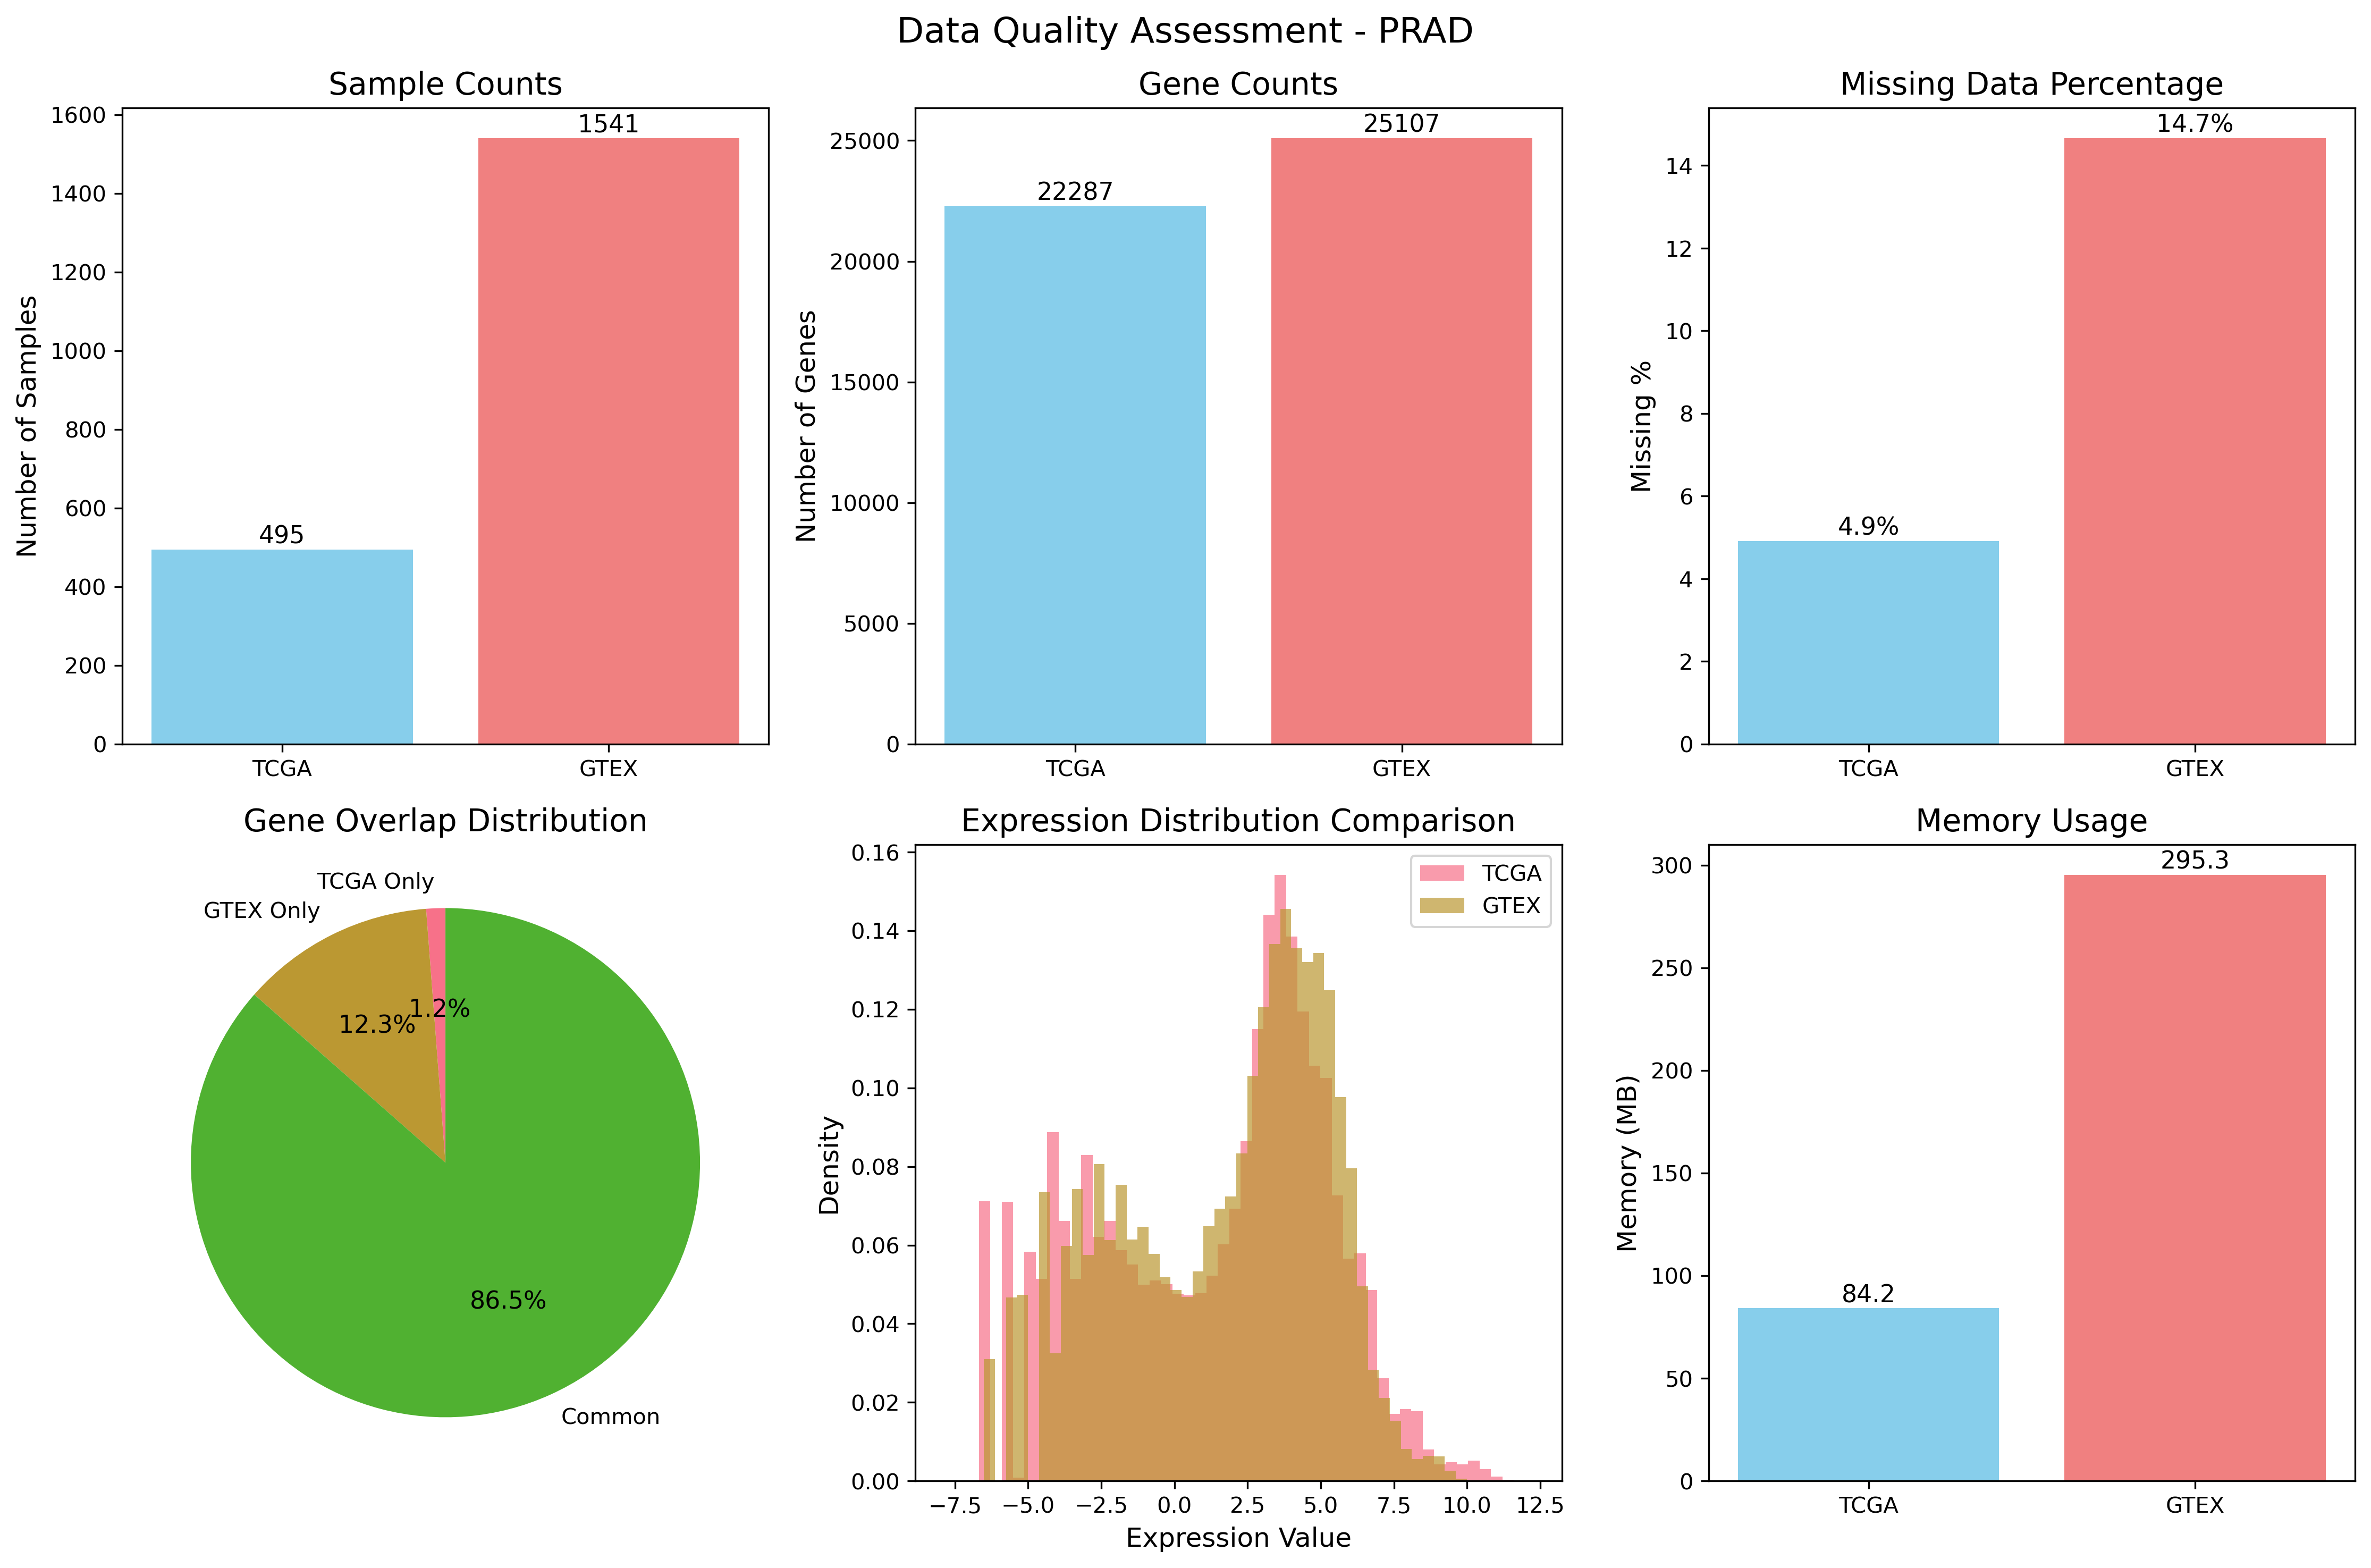

quality flags
No major quality issues detected


In [40]:

#Checking data quality

import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_data_quality_assessment(tcga_data, gtex_data, cancer_type=""):
    

    print(f" Data Quality Assessment - {cancer_type}")
 
    
    # Basic metrics
    quality_metrics = {
        'Dataset': ['TCGA', 'GTEX'],
        'Samples': [tcga_data.shape[0], gtex_data.shape[0]],
        'Genes': [tcga_data.shape[1]-1, gtex_data.shape[1]-1],
        'Missing_Pct': [
            tcga_data.select_dtypes(include='number').isnull().sum().sum() / tcga_data.select_dtypes(include='number').size * 100,
            gtex_data.select_dtypes(include='number').isnull().sum().sum() / gtex_data.select_dtypes(include='number').size * 100
        ],
        'Memory_MB': [
            tcga_data.memory_usage(deep=True).sum() / (1024**2),
            gtex_data.memory_usage(deep=True).sum() / (1024**2)
        ]
    }
    
    quality_df = pd.DataFrame(quality_metrics)
    print("\nBasic Dataset Comparison:")
    print(quality_df.to_string(index=False))
    

    tcga_genes = set(tcga_data.columns[1:])  
    gtex_genes = set(gtex_data.columns[1:])  
    
    overlap_metrics = {
        'TCGA_only_genes': len(tcga_genes - gtex_genes),
        'GTEX_only_genes': len(gtex_genes - tcga_genes),
        'Common_genes': len(tcga_genes & gtex_genes),
        'Total_unique_genes': len(tcga_genes | gtex_genes),
        'Overlap_percentage': len(tcga_genes & gtex_genes) / len(tcga_genes | gtex_genes) * 100
    }
    
    print(f"\nGene Overlap Analysis:")
    for metric, value in overlap_metrics.items():
        if 'percentage' in metric:
            print(f"  {metric}: {value:.1f}%")
        else:
            print(f"  {metric}: {value:,}")
    
  
    print(f"\nExpression Distribution Analysis:")
    

    tcga_numeric = tcga_data.select_dtypes(include='number')
    gtex_numeric = gtex_data.select_dtypes(include='number')
    

    common_genes = list(tcga_genes & gtex_genes)
    if len(common_genes) > 100:
        sample_genes = list(np.random.choice(common_genes, 100, replace=False))  # Convert to list
    else:
        sample_genes = common_genes
    
  
    tcga_stats = {}
    gtex_stats = {}
    
    if len(sample_genes) > 0:  
        try:
            tcga_stats = {
                'mean': tcga_numeric[sample_genes].mean().mean(),
                'median': tcga_numeric[sample_genes].median().median(),
                'std': tcga_numeric[sample_genes].std().mean(),
                'min': tcga_numeric[sample_genes].min().min(),
                'max': tcga_numeric[sample_genes].max().max()
            }
            
            gtex_stats = {
                'mean': gtex_numeric[sample_genes].mean().mean(),
                'median': gtex_numeric[sample_genes].median().median(),
                'std': gtex_numeric[sample_genes].std().mean(),
                'min': gtex_numeric[sample_genes].min().min(),
                'max': gtex_numeric[sample_genes].max().max()
            }
            
            distribution_df = pd.DataFrame({
                'TCGA': tcga_stats,
                'GTEX': gtex_stats
            })
            print(distribution_df.round(3))
        except Exception as e:
            print(f"Error calculating distribution statistics: {e}")
            tcga_stats = gtex_stats = {}
    
    # Creating visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Data Quality Assessment - {cancer_type}', fontsize=16)
    
    # Sample counts
    datasets = quality_df['Dataset']
    sample_counts = quality_df['Samples']
    axes[0,0].bar(datasets, sample_counts, color=['skyblue', 'lightcoral'])
    axes[0,0].set_title('Sample Counts')
    axes[0,0].set_ylabel('Number of Samples')
    for i, v in enumerate(sample_counts):
        axes[0,0].text(i, v + max(sample_counts)*0.01, str(v), ha='center')
    
    # Gene counts
    gene_counts = quality_df['Genes']
    axes[0,1].bar(datasets, gene_counts, color=['skyblue', 'lightcoral'])
    axes[0,1].set_title('Gene Counts')
    axes[0,1].set_ylabel('Number of Genes')
    for i, v in enumerate(gene_counts):
        axes[0,1].text(i, v + max(gene_counts)*0.01, str(v), ha='center')
    
    # Missing data percentage
    missing_pcts = quality_df['Missing_Pct']
    axes[0,2].bar(datasets, missing_pcts, color=['skyblue', 'lightcoral'])
    axes[0,2].set_title('Missing Data Percentage')
    axes[0,2].set_ylabel('Missing %')
    for i, v in enumerate(missing_pcts):
        axes[0,2].text(i, v + max(missing_pcts)*0.01, f'{v:.1f}%', ha='center')
    
    # Gene overlap pie chart
    overlap_data = [overlap_metrics['TCGA_only_genes'], 
                   overlap_metrics['GTEX_only_genes'], 
                   overlap_metrics['Common_genes']]
    overlap_labels = ['TCGA Only', 'GTEX Only', 'Common']
    axes[1,0].pie(overlap_data, labels=overlap_labels, autopct='%1.1f%%', startangle=90)
    axes[1,0].set_title('Gene Overlap Distribution')
    
    # Expression distribution comparison 
    if len(sample_genes) > 0: 
        try:
            tcga_sample_values = tcga_numeric[sample_genes].values.flatten()
            gtex_sample_values = gtex_numeric[sample_genes].values.flatten()
            
            tcga_clean = tcga_sample_values[~np.isnan(tcga_sample_values)]
            gtex_clean = gtex_sample_values[~np.isnan(gtex_sample_values)]
            
            if len(tcga_clean) > 0 and len(gtex_clean) > 0:
                axes[1,1].hist(tcga_clean, bins=50, alpha=0.7, label='TCGA', density=True)
                axes[1,1].hist(gtex_clean, bins=50, alpha=0.7, label='GTEX', density=True)
                axes[1,1].set_title('Expression Distribution Comparison')
                axes[1,1].set_xlabel('Expression Value')
                axes[1,1].set_ylabel('Density')
                axes[1,1].legend()
            else:
                axes[1,1].text(0.5, 0.5, 'No valid data for comparison', 
                              ha='center', va='center', transform=axes[1,1].transAxes)
        except Exception as e:
            axes[1,1].text(0.5, 0.5, f'Error in distribution plot', 
                          ha='center', va='center', transform=axes[1,1].transAxes)
    else:
        axes[1,1].text(0.5, 0.5, 'No common genes found', 
                      ha='center', va='center', transform=axes[1,1].transAxes)
    
    # Memory usage comparison
    memory_usage = quality_df['Memory_MB']
    axes[1,2].bar(datasets, memory_usage, color=['skyblue', 'lightcoral'])
    axes[1,2].set_title('Memory Usage')
    axes[1,2].set_ylabel('Memory (MB)')
    for i, v in enumerate(memory_usage):
        axes[1,2].text(i, v + max(memory_usage)*0.01, f'{v:.1f}', ha='center')
    
    plt.tight_layout()
    plt.savefig(PATHS["output_dir"] / f'data_quality_assessment_{cancer_type.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
   
    print("quality flags")

    
    flags = []
    if overlap_metrics['Overlap_percentage'] < 70:
        flags.append(f"LOW GENE OVERLAP: {overlap_metrics['Overlap_percentage']:.1f}% ")
    
    if any(missing > 30 for missing in missing_pcts):
        flags.append(f"HIGH MISSING DATA: Up to {max(missing_pcts):.1f}%")
    
    if tcga_stats and gtex_stats and abs(tcga_stats['mean'] - gtex_stats['mean']) > 2:
        flags.append(f"LARGE EXPRESSION DIFFERENCES: Mean difference = {abs(tcga_stats['mean'] - gtex_stats['mean']):.2f}")
    
    if len(flags) == 0:
        print("No major quality issues detected")
    else:
        for flag in flags:
            print(flag)
    
    return {
    'basic_metrics': quality_df,
    'overlap_metrics': overlap_metrics,
    'quality_flags': flags,
    'figure_path': PATHS["output_dir"] / f'data_quality_assessment_{cancer_type.lower()}.png'
}


hr("Running Data Quality Assessment")

try:
    quality_results = comprehensive_data_quality_assessment(
        tcga_data=tcga_expr_samples,  
        gtex_data=gtex_expr_samples,  
        cancer_type=CANCER_TYPE
    )
    
    
except NameError as e:
    print(f"Error: {e}")
    print("fix (tcga_expr_samples, gtex_expr_samples)")


In [41]:
# GTEX Tissue-Matched Normal Sample Filtering
import pandas as pd
from pathlib import Path

def hr(title):
    print(title)

hr("Loading GTEX phenotype data")
phenotype_path = PATHS["gtex_phenotype"]

if not phenotype_path.exists():
    raise FileNotFoundError(f"GTEX phenotype file not found: {phenotype_path}")

try:
    phenotype_df = pd.read_csv(phenotype_path)
    print(f"Loaded phenotype data: {phenotype_df.shape}")
    print(f"Columns: {phenotype_df.columns.tolist()}")
except Exception as e:
    print(f"Error loading phenotype data: {e}")
    raise

hr("GTEX phenotype overview")
print(f"Total samples: {len(phenotype_df)}")
print(f"Available organs/sites:")
site_counts = phenotype_df['Primary_site'].value_counts()
print(site_counts)

target_organ = ANALYSIS_PARAMS["target_organ"]
print(f"\nTarget organ for {CANCER_TYPE}: {target_organ}")

hr(f"Filtering for {target_organ} samples")

# Filter phenotype data for target organ
organ_samples = phenotype_df[phenotype_df['Primary_site'] == target_organ].copy()

if len(organ_samples) == 0:
    print(f" No samples found for {target_organ}")
    print("Available organs:", phenotype_df['Primary_site'].unique().tolist())
    raise ValueError(f"No {target_organ} samples found in GTEX phenotype data")

print(f"Found {len(organ_samples)} {target_organ} samples")

if 'Gender' in organ_samples.columns:
    gender_counts = organ_samples['Gender'].value_counts()
    print(f"Gender distribution: {gender_counts.to_dict()}")

if 'Site_details' in organ_samples.columns:
    site_details = organ_samples['Site_details'].value_counts()
    print(f"Site details: {site_details.to_dict()}")

hr("Loading processed GTEX expression data")
gtex_expr_path = PATHS["gtex_expr_processed"]

if not gtex_expr_path.exists():
    raise FileNotFoundError(f"Processed GTEX expression file not found: {gtex_expr_path}")

try:
    gtex_expr = pd.read_csv(gtex_expr_path)
    print(f"Loaded GTEX expression: {gtex_expr.shape}")
    print(f"Total expression samples: {len(gtex_expr)}")
except Exception as e:
    print(f"Error loading GTEX expression data: {e}")
    raise



hr("File Validation")

EXPECTED_SAMPLES = gtex_expr.shape[0]
EXPECTED_GENES = gtex_expr.shape[1] - 1
EXPECTED_SHAPE = (EXPECTED_SAMPLES, EXPECTED_GENES + 1) 

print(f"Expected shape: {EXPECTED_SHAPE}")
print(f"Actual loaded shape: {gtex_expr.shape}")

if gtex_expr.shape != EXPECTED_SHAPE:
    print("CRITICAL ERROR: Shape mismatch detected!")
    print(f"   Expected: {EXPECTED_SAMPLES} samples, {EXPECTED_GENES} genes")
    print(f"   Got: {gtex_expr.shape[0]} samples, {gtex_expr.shape[1]-1} genes")
    print(f"   Difference: {gtex_expr.shape[0] - EXPECTED_SAMPLES} samples, {(gtex_expr.shape[1]-1) - EXPECTED_GENES} genes")
    
    if gtex_expr.shape[1] > 50000:
        print("   check what was loaded")
    
    print("\nDebugging information:")
    print(f"   File path used: {gtex_expr_path}")
    print(f"   File exists: {gtex_expr_path.exists()}")
    if gtex_expr_path.exists():
        print(f"   File size: {gtex_expr_path.stat().st_size / (1024**2):.1f} MB")
    
    dtype_counts = gtex_expr.dtypes.value_counts()
    print(f"   Data types: {dtype_counts.to_dict()}")
    
    raise ValueError("Data consistency check failed")

else:
    print(" Shape validation passed")
    print(f"   Samples: {gtex_expr.shape[0]}")
    print(f"   Genes: {gtex_expr.shape[1]-1}")

print("\nAdditional validation checks:")

numeric_cols = gtex_expr.select_dtypes(include='number')
if len(numeric_cols.columns) == EXPECTED_GENES:
    print("Numeric data type conversion confirmed")
else:
    print(" numeric columns dont match count")

total_na = gtex_expr.isnull().sum().sum()
print(f"Total NaN values: {total_na:,}")

sample_ids = gtex_expr['sample'].dropna()
gtex_pattern = sample_ids.str.contains('GTEX_', na=False).sum()
print(f"Valid GTEX sample IDs: {gtex_pattern}/{len(sample_ids)}")

if len(numeric_cols.columns) > 0:
    sample_values = numeric_cols.iloc[0:5, 0:3].values.flatten()
    sample_values = sample_values[~pd.isna(sample_values)]  # Remove NaN
    if len(sample_values) > 0:
        print(f"Sample expression values: {sample_values[:5]}")
        print(f"Expression range: {sample_values.min():.2f} to {sample_values.max():.2f}")
    else:
        print(" No valid expression values ")

print(f"\nConfirmed its loading from: {gtex_expr_path}")

hr("Matching samples between phenotype and expression data")

phenotype_sample_ids = set(organ_samples['Sample'].tolist())
expression_sample_ids = set(gtex_expr['sample'].dropna().tolist())

print(f"Phenotype {target_organ} samples: {len(phenotype_sample_ids)}")
print(f"Expression samples: {len(expression_sample_ids)}")

matched_samples = phenotype_sample_ids.intersection(expression_sample_ids)
print(f"Matched samples: {len(matched_samples)}")

if len(matched_samples) == 0:
    print(" No matching samples found between phenotype and expression data")
    print("Sample ID format comparison:")
    print(f"Phenotype examples: {list(phenotype_sample_ids)[:5]}")
    print(f"Expression examples: {list(expression_sample_ids)[:5]}")
    raise ValueError("No matching samples found ")

missing_in_expr = phenotype_sample_ids - expression_sample_ids
if missing_in_expr:
    print(f"Samples in phenotype but missing in expression: {len(missing_in_expr)}")
    if len(missing_in_expr) <= 10:
        print(f"Missing samples: {list(missing_in_expr)}")

hr(f"Creating tissue-matched {target_organ} expression dataset")

matched_mask = gtex_expr['sample'].isin(matched_samples) | gtex_expr['sample'].isna()
tissue_matched_expr = gtex_expr[matched_mask].copy()

print(f"Tissue-matched expression shape: {tissue_matched_expr.shape}")
print(f"Samples retained: {len(tissue_matched_expr) - 1}")  

hr("Adding phenotype information")

phenotype_info = organ_samples.set_index('Sample')[['Primary_site', 'Gender', 'Site_details', 'Patient', 'Cohort']].to_dict('index')

for col in ['Primary_site', 'Gender', 'Site_details', 'Patient', 'Cohort']:
    tissue_matched_expr[col] = tissue_matched_expr['sample'].map(
        lambda x: phenotype_info.get(x, {}).get(col, '') if pd.notna(x) else ''
    )

matched_with_pheno = tissue_matched_expr['Primary_site'].eq(target_organ).sum()
print(f"Samples with correct phenotype: {matched_with_pheno}")

hr("Saving tissue-matched normal dataset")

output_path = PATHS["tissue_matched_normal"]
try:
    tissue_matched_expr.to_csv(output_path, index=False)
    print(f"Saved tissue-matched {target_organ} normal dataset to:")
    print(f"   {output_path}")
    print(f"   Shape: {tissue_matched_expr.shape}")
    print(f"   {target_organ} samples: {matched_with_pheno}")
except Exception as e:
    print(f"Error saving tissue-matched dataset: {e}")
    raise

hr("Tissue matching summary")

print(f"Cancer type: {CANCER_TYPE}")
print(f"Target organ: {target_organ}")
print(f"Original GTEX samples: {len(gtex_expr) - 1}")
print(f"Organ specific samples available: {len(organ_samples)}")
print(f"Successfully matched samples: {len(matched_samples)}")
print(f"Final dataset shape: {tissue_matched_expr.shape}")


if matched_with_pheno > 0:
    final_gender_dist = tissue_matched_expr[tissue_matched_expr['Primary_site'] == target_organ]['Gender'].value_counts()
    print(f"Final gender distribution: {final_gender_dist.to_dict()}")


if 'Site_details' in tissue_matched_expr.columns:
    site_dist = tissue_matched_expr[tissue_matched_expr['Primary_site'] == target_organ]['Site_details'].value_counts()
    print(f"Site details distribution: {site_dist.to_dict()}")


ANALYSIS_PARAMS["tissue_matching_completed"] = True
ANALYSIS_PARAMS["tissue_matched_samples"] = len(matched_samples)
ANALYSIS_PARAMS["normal_dataset_type"] = "tissue_matched"
ANALYSIS_PARAMS["normal_dataset_path"] = output_path



Loading GTEX phenotype data
Loaded phenotype data: (1892, 7)
Columns: ['Unnamed: 0', 'Sample', 'Site_details', 'Primary_site', 'Gender', 'Patient', 'Cohort']
GTEX phenotype overview
Total samples: 1892
Available organs/sites:
Primary_site
Skin        977
Lung        381
Stomach     209
Pancreas    203
Prostate    122
Name: count, dtype: int64

Target organ for PRAD: Prostate
Filtering for Prostate samples
Found 122 Prostate samples
Gender distribution: {'male': 122}
Site details: {'Prostate': 122}
Loading processed GTEX expression data
Loaded GTEX expression: (1541, 25108)
Total expression samples: 1541
File Validation
Expected shape: (1541, 25108)
Actual loaded shape: (1541, 25108)
 Shape validation passed
   Samples: 1541
   Genes: 25107

Additional validation checks:
Numeric data type conversion confirmed
Total NaN values: 5,674,663
Valid GTEX sample IDs: 1540/1540
Sample expression values: [ 3.7039 -2.0529  5.5641  2.9224  4.1644]
Expression range: -5.01 to 5.56

Confirmed its load

In [43]:
# Normalization for Cancer 
import pandas as pd
from pathlib import Path
import re


hr(f"Normalizing {CANCER_TYPE} sample IDs")

EXPR_PATH = PATHS["cancer_expr_processed"]

if not EXPR_PATH.exists():
    raise FileNotFoundError(f"Cancer expression file not found: {EXPR_PATH}")

try:
    expr_df = pd.read_csv(EXPR_PATH)
    print(f"Loaded cancer expression data: {expr_df.shape}")
except Exception as e:
    print(f"Error loading expression data: {e}")
    raise

print(f"\nOriginal sample ID examples:")
original_samples = expr_df['sample'].dropna().head(10)
print(original_samples.tolist())

def normalize_sample_ids(sample_series):

    if sample_series.empty:
        return sample_series
    

    sample_series = sample_series.astype(str)
    
    normalized = sample_series.str.replace("_", "-", regex=False)
    
    tcga_pattern = r'(TCGA-\w{2}-\w{4})'
    tcga_matches = normalized.str.extract(tcga_pattern, expand=False)
    
    result = tcga_matches.fillna(normalized)
    
    result = result.replace('nan', pd.NA)
    
    return result

print("\nNormalizing sample IDs...")
original_sample_col = expr_df['sample'].copy()
expr_df['sample'] = normalize_sample_ids(expr_df['sample'])


hr("Normalization results")


total_samples = len(expr_df)
non_null_original = original_sample_col.notna().sum()
non_null_after = expr_df['sample'].notna().sum()
null_after = expr_df['sample'].isna().sum()

print(f"Total rows: {total_samples}")
print(f"Original non-null samples: {non_null_original}")
print(f"After normalization non-null: {non_null_after}")
print(f"After normalization null: {null_after}")

print(f"\nSample ID transformation examples:")
comparison_df = pd.DataFrame({
    'Original': original_sample_col.head(10),
    'Normalized': expr_df['sample'].head(10)
})
print(comparison_df.to_string(index=False))

tcga_pattern_matches = expr_df['sample'].str.match(r'TCGA-\w{2}-\w{4}', na=False).sum()
print(f"\nSamples matching TCGA pattern (TCGA-XX-XXXX): {tcga_pattern_matches}")

duplicates = expr_df['sample'].duplicated().sum()
if duplicates > 0:
    print(f"  Warning: {duplicates} duplicate sample IDs after normalization")
    duplicate_samples = expr_df['sample'][expr_df['sample'].duplicated(keep=False)]
    print("Duplicate sample IDs:", duplicate_samples.unique().tolist())

non_tcga_samples = expr_df[~expr_df['sample'].str.match(r'TCGA-\w{2}-\w{4}', na=False)]['sample'].dropna()
if len(non_tcga_samples) > 0:
    print(f"\nSamples not matching TCGA format: {len(non_tcga_samples)}")
    if len(non_tcga_samples) <= 20:
        print("Non-TCGA samples:", non_tcga_samples.unique().tolist())
    else:
        print("First 20 non-TCGA samples:", non_tcga_samples.unique()[:20].tolist())


hr("Saving normalized data")
cleaned_expr_path = PATHS["cancer_expr_normalized"]

try:
    expr_df.to_csv(cleaned_expr_path, index=False)
    print(f" Saved normalized expression data to:")
    print(f"   {cleaned_expr_path}")
    print(f"   Shape: {expr_df.shape}")
    

    ANALYSIS_PARAMS["sample_normalization_completed"] = True
    ANALYSIS_PARAMS["normalized_samples"] = non_null_after
    ANALYSIS_PARAMS["tcga_format_samples"] = tcga_pattern_matches
    
    print(f"\n Normalization Summary:")
    print(f"    Total samples processed: {total_samples}")
    print(f"    Successfully normalized: {non_null_after}")
    print(f"    TCGA format samples: {tcga_pattern_matches}")
    print(f"    Ready for downstream analysis")
    
except Exception as e:
    print(f" Error saving normalized data: {e}")
    raise


hr("Validation")
if non_null_after == non_null_original:
    print("All original non-null samples were preserved")
elif non_null_after > non_null_original:
    print(" More samples after normalization - check for issues")
else:
    lost_samples = non_null_original - non_null_after
    print(f"  Lost {lost_samples} samples during normalization")

if duplicates == 0:
    print("No duplicate sample IDs")
else:
    print(f"{duplicates} duplicate sample IDs - may need manual review")

print(f"Normalized file saved at: {cleaned_expr_path}")


Normalizing PRAD sample IDs
Loaded cancer expression data: (495, 22288)

Original sample ID examples:
['TCGA_CH_5751', 'TCGA_KK_A7B3', 'TCGA_EJ_8468', 'TCGA_ZG_A8QW', 'TCGA_J4_A83K', 'TCGA_ZG_A9MC', 'TCGA_HC_7742', 'TCGA_M7_A722', 'TCGA_VP_A879', 'TCGA_HC_8265']

Normalizing sample IDs...
Normalization results
Total rows: 495
Original non-null samples: 494
After normalization non-null: 494
After normalization null: 1

Sample ID transformation examples:
    Original   Normalized
         NaN         <NA>
TCGA_CH_5751 TCGA-CH-5751
TCGA_KK_A7B3 TCGA-KK-A7B3
TCGA_EJ_8468 TCGA-EJ-8468
TCGA_ZG_A8QW TCGA-ZG-A8QW
TCGA_J4_A83K TCGA-J4-A83K
TCGA_ZG_A9MC TCGA-ZG-A9MC
TCGA_HC_7742 TCGA-HC-7742
TCGA_M7_A722 TCGA-M7-A722
TCGA_VP_A879 TCGA-VP-A879

Samples matching TCGA pattern (TCGA-XX-XXXX): 494
Saving normalized data
 Saved normalized expression data to:
   /Users/dyuth/Desktop/Data Science Project/Data/expr_for_dea_TOIL_RSEM_TPM_PRAD_NORMALIZED.csv
   Shape: (495, 22288)

 Normalization Summary:


In [44]:
#Normalization for GTEX
import pandas as pd
from pathlib import Path


hr(f"Normalizing GTEX sample IDs for {ANALYSIS_PARAMS['target_organ']}")

def get_normal_dataset_path():
    if "normal_expr_stratified" in PATHS:
        return Path(PATHS["normal_expr_stratified"])
    else:
        return Path(PATHS["tissue_matched_normal"])

def get_normal_dataset_type():
    return "Stratified GTEX" if "normal_expr_stratified" in PATHS else "Tissue-Matched GTEX"

normal_dataset_path = get_normal_dataset_path()
normal_dataset_type = get_normal_dataset_type()

print(f"Using {normal_dataset_type} dataset")
print(f"Dataset path: {normal_dataset_path}")

if not normal_dataset_path.exists():
    raise FileNotFoundError(f"GTEX expression file not found: {normal_dataset_path}")

try:
    expr_df = pd.read_csv(normal_dataset_path)
    print(f"Loaded GTEX expression data: {expr_df.shape}")
    print(f"Columns: {expr_df.columns.tolist()[:10]}{'...' if len(expr_df.columns) > 10 else ''}")
except Exception as e:
    print(f"Error loading GTEX expression data: {e}")
    raise

phenotype_cols = ['Primary_site', 'Gender', 'Site_details', 'Patient', 'Cohort']
has_phenotype_data = any(col in expr_df.columns for col in phenotype_cols)

if has_phenotype_data:
    print(f"✓ Detected tissue-matched dataset with phenotype columns")
    if 'Primary_site' in expr_df.columns:
        organ_counts = expr_df['Primary_site'].value_counts().dropna()
        print(f"Organ distribution: {organ_counts.to_dict()}")
        
        target_organ = ANALYSIS_PARAMS['target_organ']
        target_samples = expr_df[expr_df['Primary_site'] == target_organ]
        print(f"{target_organ} samples: {len(target_samples)}")
else:
    print(f"Using original GTEX dataset without phenotype columns")

hr("Original sample ID analysis")
print("Sample ID examples (before normalization):")
original_samples = expr_df['sample'].dropna().head(10)
print(original_samples.tolist())


sample_with_underscore = expr_df['sample'].str.contains('_', na=False).sum()
sample_with_dash = expr_df['sample'].str.contains('-', na=False).sum()
print(f"\nSample ID format analysis:")
print(f"Samples with underscores: {sample_with_underscore}")
print(f"Samples with dashes: {sample_with_dash}")


def normalize_gtex_sample_ids(sample_series):
    if sample_series.empty:
        return sample_series
    

    original = sample_series.copy()
    normalized = sample_series.astype(str)
    normalized = normalized.str.replace("_", "-", regex=False)
    normalized = normalized.replace('nan', pd.NA)
    return normalized


print("\nApplying sample ID normalization...")
original_sample_col = expr_df['sample'].copy()
expr_df['sample'] = normalize_gtex_sample_ids(expr_df['sample'])


hr("Normalization results")


total_samples = len(expr_df)
non_null_original = original_sample_col.notna().sum()
non_null_after = expr_df['sample'].notna().sum()

print(f"Total rows: {total_samples}")
print(f"Non-null samples before: {non_null_original}")
print(f"Non-null samples after: {non_null_after}")


print("\nSample ID transformation examples:")
comparison_df = pd.DataFrame({
    'Original': original_sample_col.head(10),
    'Normalized': expr_df['sample'].head(10)
})
print(comparison_df.to_string(index=False))


changes_made = (original_sample_col != expr_df['sample']).sum()
print(f"\nSample IDs modified: {changes_made}")


gtex_pattern_matches = expr_df['sample'].str.contains('GTEX', na=False).sum()
print(f"Samples matching GTEX pattern: {gtex_pattern_matches}")


duplicates = expr_df['sample'].duplicated().sum()
if duplicates > 0:
    print(f" Warning: {duplicates} duplicate sample IDs after normalization")


if has_phenotype_data and 'Primary_site' in expr_df.columns:
    target_organ = ANALYSIS_PARAMS['target_organ']
    target_after_norm = expr_df[expr_df['Primary_site'] == target_organ]
    valid_target_samples = target_after_norm['sample'].notna().sum()
    print(f"\n{target_organ} samples with valid IDs after normalization: {valid_target_samples}")


hr("Saving normalized data")


if normal_dataset_type == "tissue_matched":
    output_path = PATHS["tissue_matched_normal"].parent / f"GTEX_{ANALYSIS_PARAMS['target_organ']}_Matched_Normal_{CANCER_TYPE}_NORMALIZED.csv"
    PATHS["tissue_matched_normal_normalized"] = output_path
else:
    output_path = PATHS["gtex_expr_normalized"]

try:
    expr_df.to_csv(output_path, index=False)
    print(f"Saved normalized GTEX expression data to:")
    print(f"   {output_path}")
    print(f"   Shape: {expr_df.shape}")
    

    ANALYSIS_PARAMS["gtex_normalization_completed"] = True
    ANALYSIS_PARAMS["gtex_normalized_samples"] = non_null_after
    ANALYSIS_PARAMS["gtex_normalized_path"] = str(output_path)
    
except Exception as e:
    print(f"Error saving normalized data: {e}")
    raise


hr("Normalization Summary")
print(f"Dataset type: {normal_dataset_type}")
print(f"Target organ: {ANALYSIS_PARAMS['target_organ']}")
print(f"Total samples: {total_samples}")
print(f"Sample IDs normalized: {changes_made}")
print(f"Valid samples after normalization: {non_null_after}")

if has_phenotype_data:
    print(f"Phenotype columns preserved: {', '.join([col for col in phenotype_cols if col in expr_df.columns])}")
    if 'Primary_site' in expr_df.columns:
        final_organ_count = expr_df[expr_df['Primary_site'] == ANALYSIS_PARAMS['target_organ']]['sample'].notna().sum()
        print(f"{ANALYSIS_PARAMS['target_organ']} samples ready: {final_organ_count}")

print(f"\n GTEX sample normalization complete!")
print("Ready for differential expression analysis")


if normal_dataset_type == "tissue_matched":
    PATHS["normal_expr_final"] = output_path
else:
    PATHS["normal_expr_final"] = PATHS["gtex_expr_normalized"]

print(f"Use PATHS['normal_expr_final'] for downstream analysis: {PATHS['normal_expr_final']}")


hr("Final Validation")
if duplicates == 0:
    print("No duplicate sample IDs")
else:
    print(f"{duplicates} duplicates found - review needed")

if non_null_after >= non_null_original:
    print("All samples preserved during normalization")
else:
    print(f"Lost {non_null_original - non_null_after} samples during normalization")

if has_phenotype_data and 'Primary_site' in expr_df.columns:
    target_final = expr_df[expr_df['Primary_site'] == ANALYSIS_PARAMS['target_organ']]['sample'].notna().sum()
    if target_final > 0:
        print(f"{target_final} {ANALYSIS_PARAMS['target_organ']} samples ready for analysis")
    else:
        print(f"No valid {ANALYSIS_PARAMS['target_organ']} samples after normalization")

Normalizing GTEX sample IDs for Prostate
Using Tissue-Matched GTEX dataset
Dataset path: /Users/dyuth/Desktop/Data Science Project/Data/GTEX_Prostate_Matched_Normal_PRAD.csv
Loaded GTEX expression data: (101, 25113)
Columns: ['sample', 'TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM', 'FGR', 'CFH', 'FUCA2', 'GCLC']...
✓ Detected tissue-matched dataset with phenotype columns
Organ distribution: {'Prostate': 100}
Prostate samples: 100
Original sample ID analysis
Sample ID examples (before normalization):
['GTEX_111CU_1526_SM_5N9FS', 'GTEX_111FC_2026_SM_5GZYO', 'GTEX_111YS_1726_SM_5GIED', 'GTEX_117YW_1426_SM_5EGGO', 'GTEX_117YX_1526_SM_5H12T', 'GTEX_11DXZ_1826_SM_5H12Y', 'GTEX_11DYG_2526_SM_5N9BB', 'GTEX_11EQ9_1726_SM_5HL6U', 'GTEX_11NSD_0826_SM_5986S', 'GTEX_11O72_2726_SM_5HL6K']

Sample ID format analysis:
Samples with underscores: 100
Samples with dashes: 0

Applying sample ID normalization...
Normalization results
Total rows: 101
Non-null samples before: 100
Non-null samples after: 100

Sam

Cross-Dataset Normalization Validation
TCGA normalized: (495, 22288)
GTEX normalized: (101, 25113)

TCGA Sample ID Analysis:
  Total_samples: 494
  TCGA_pattern_matches: 494
  Contains_underscores: 0
  Contains_dashes: 494
  Duplicates: 0

GTEX Sample ID Analysis:
  Total_samples: 100
  GTEX_pattern_matches: 100
  Contains_underscores: 0
  Contains_dashes: 100
  Duplicates: 0

Cross-Dataset Compatibility:
  TCGA_genes: 22,287
  GTEX_genes: 25,112
  Common_genes: 21,979
  TCGA_only: 308
  GTEX_only: 3,133
  Overlap_percentage: 86.5%

Expression Distribution Comparison (sample genes):
              TCGA    GTEX
CST6        60.993  11.869
CSKMT       64.455  15.151
PAX6        60.794  11.561
TBCD        66.875  17.663
RPL4        70.535  20.776
LINC00501   47.476   6.633
RXYLT1-AS1  42.145   6.987
PFN1P6      45.868  13.182
LINC01943   60.505  11.995
CDX2        57.079   9.947

Batch Effect Assessment:
TCGA median expression: -1.015
GTEX median expression: -0.785
Batch effect size: 0.230


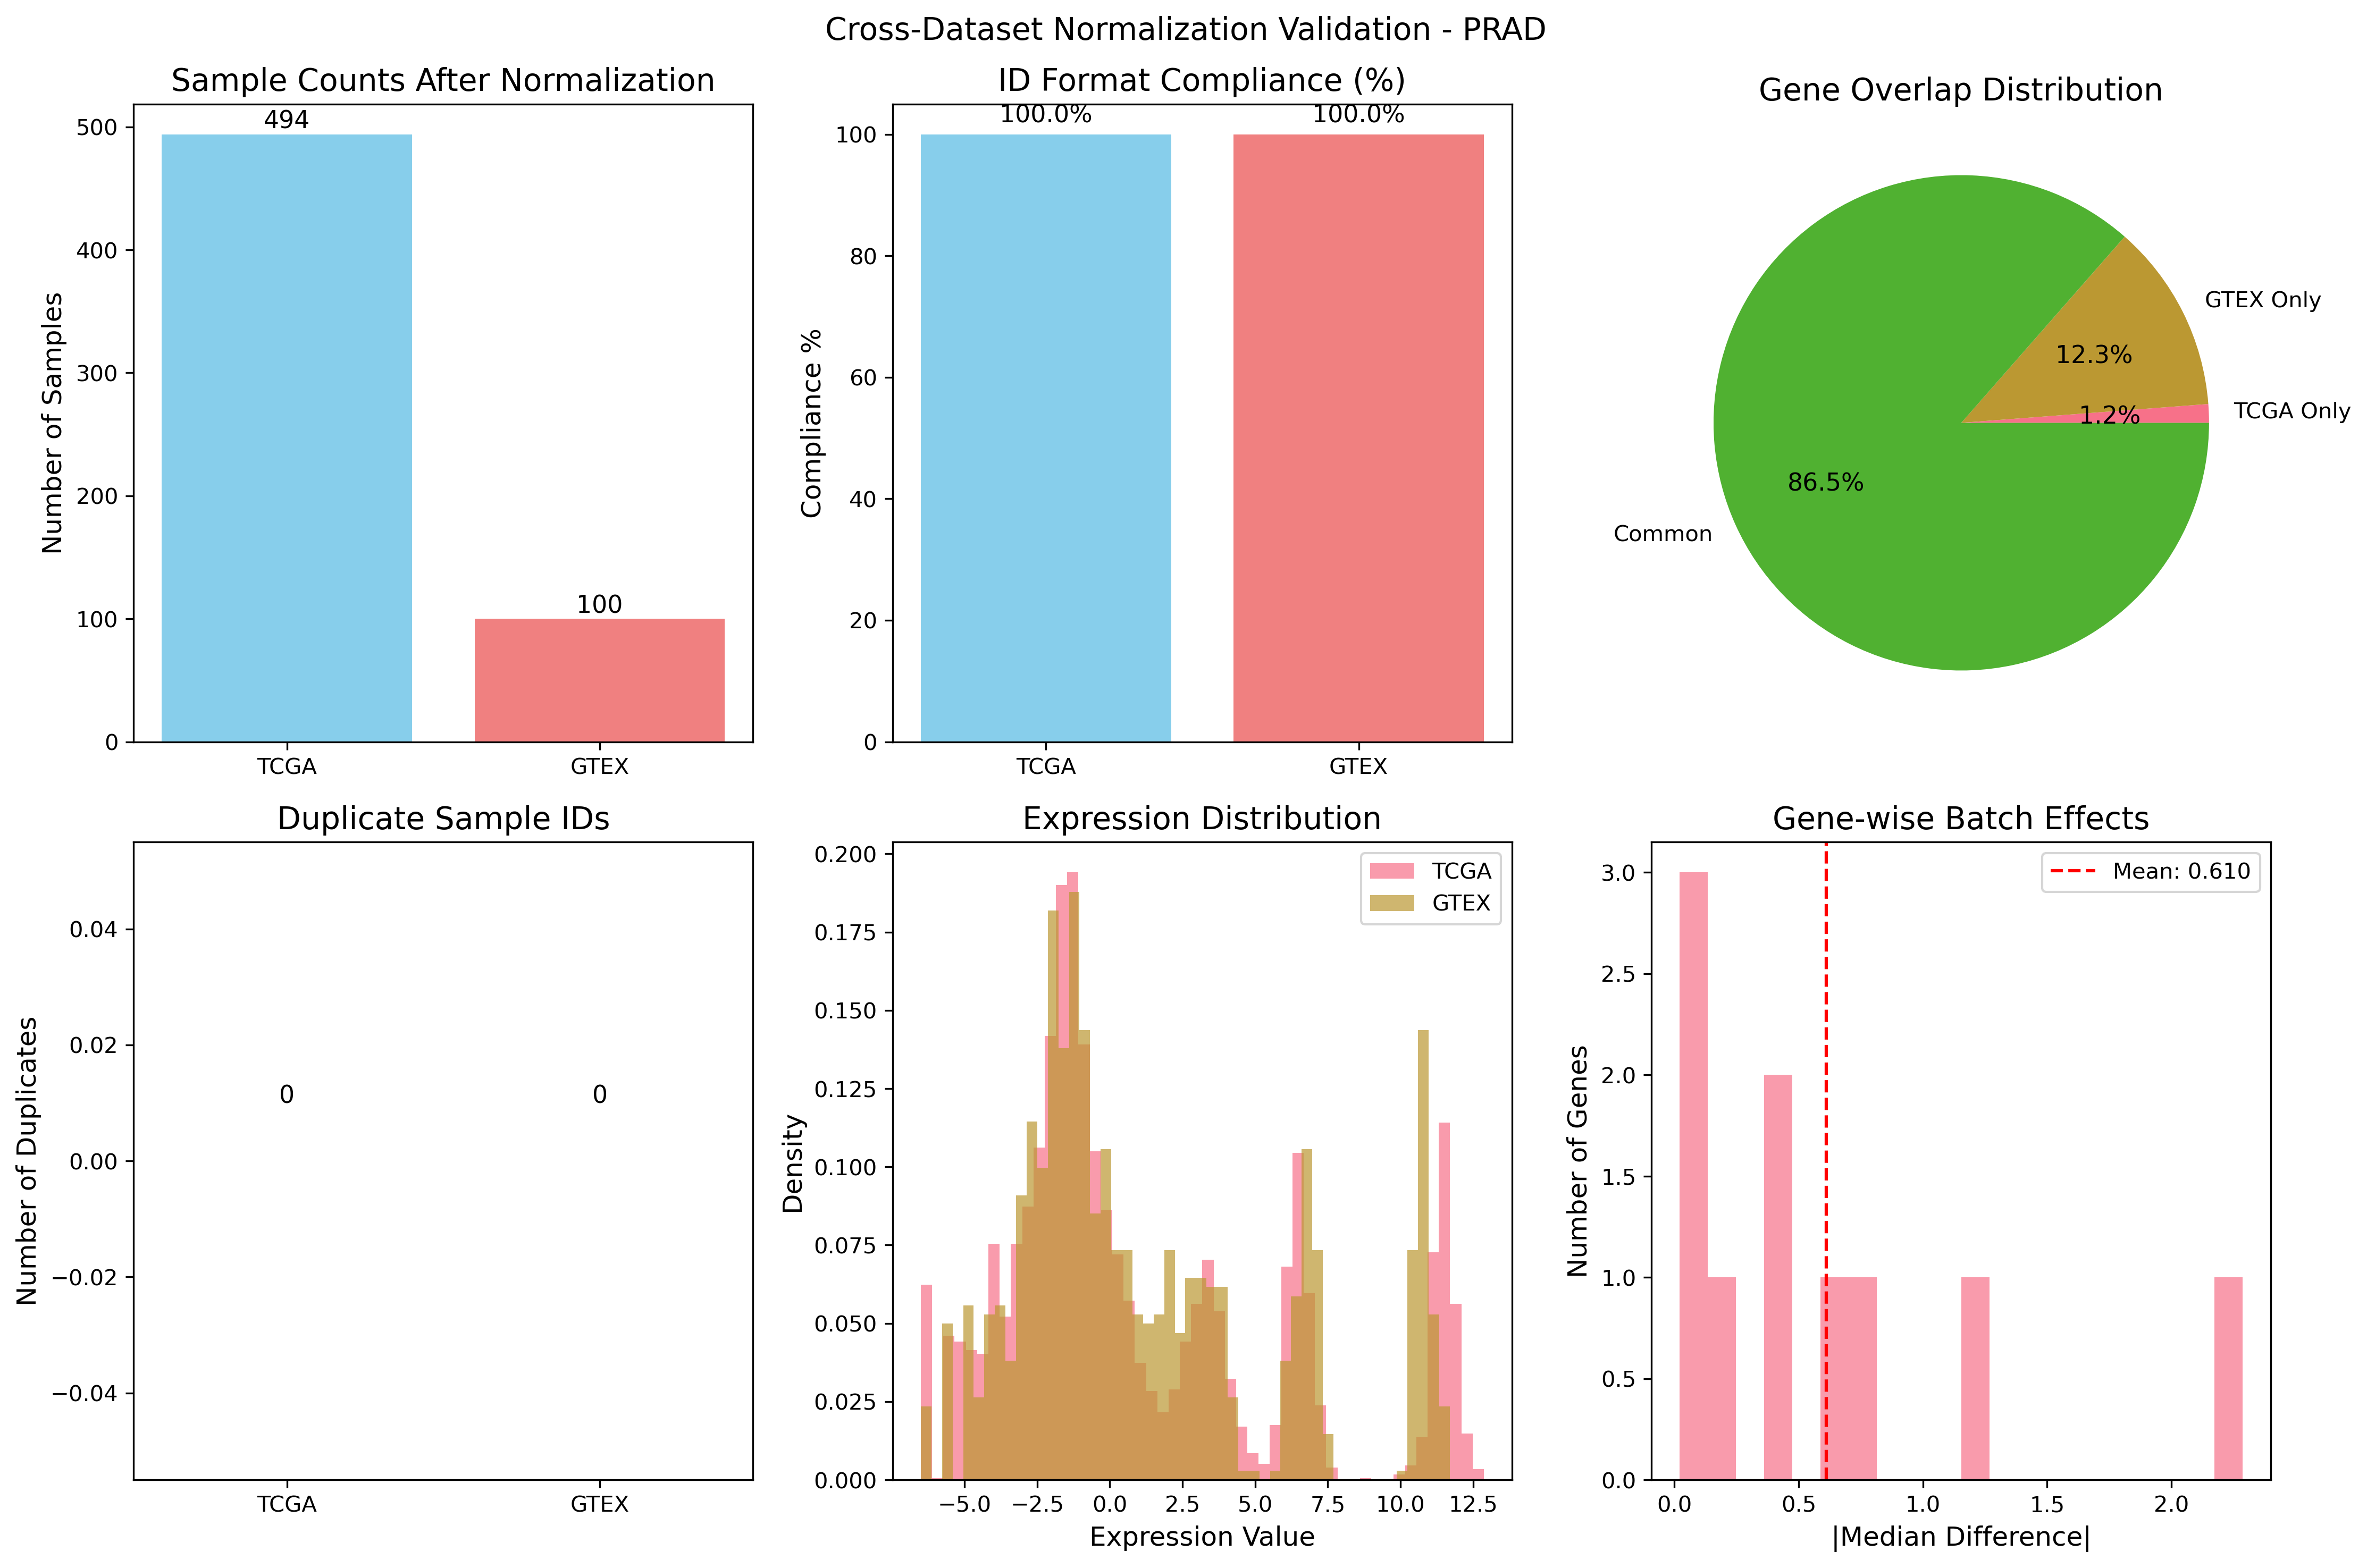

All normalization validation checks passed
Datasets are ready for differential expression analysis


In [45]:

#NORMALIZATION VALIDATION 


def comprehensive_normalization_validation():
    """Validate normalization effectiveness across both datasets"""
    
    hr("Cross-Dataset Normalization Validation")
    
    try:

        tcga_normalized = pd.read_csv(PATHS["cancer_expr_normalized"])
        gtex_normalized = pd.read_csv(PATHS["normal_expr_final"])
        
        print(f"TCGA normalized: {tcga_normalized.shape}")
        print(f"GTEX normalized: {gtex_normalized.shape}")
        
    except Exception as e:
        print(f"Error loading normalized data: {e}")
        return None
    

    tcga_samples = tcga_normalized['sample'].dropna()
    gtex_samples = gtex_normalized['sample'].dropna()
    

    tcga_format_analysis = {
        'Total_samples': len(tcga_samples),
        'TCGA_pattern_matches': tcga_samples.str.match(r'TCGA-\w{2}-\w{4}', na=False).sum(),
        'Contains_underscores': tcga_samples.str.contains('_', na=False).sum(),
        'Contains_dashes': tcga_samples.str.contains('-', na=False).sum(),
        'Duplicates': tcga_samples.duplicated().sum()
    }
    
    gtex_format_analysis = {
        'Total_samples': len(gtex_samples),
        'GTEX_pattern_matches': gtex_samples.str.contains('GTEX', na=False).sum(),
        'Contains_underscores': gtex_samples.str.contains('_', na=False).sum(),
        'Contains_dashes': gtex_samples.str.contains('-', na=False).sum(),
        'Duplicates': gtex_samples.duplicated().sum()
    }
    
    print(f"\nTCGA Sample ID Analysis:")
    for metric, value in tcga_format_analysis.items():
        print(f"  {metric}: {value}")
    
    print(f"\nGTEX Sample ID Analysis:")
    for metric, value in gtex_format_analysis.items():
        print(f"  {metric}: {value}")
    

    print(f"\nCross-Dataset Compatibility:")
    

    tcga_genes = set(tcga_normalized.columns[1:])
    gtex_genes = set(gtex_normalized.columns[1:])
    
    gene_overlap = {
        'TCGA_genes': len(tcga_genes),
        'GTEX_genes': len(gtex_genes),
        'Common_genes': len(tcga_genes & gtex_genes),
        'TCGA_only': len(tcga_genes - gtex_genes),
        'GTEX_only': len(gtex_genes - tcga_genes),
        'Overlap_percentage': len(tcga_genes & gtex_genes) / len(tcga_genes | gtex_genes) * 100
    }
    
    for metric, value in gene_overlap.items():
        if 'percentage' in metric:
            print(f"  {metric}: {value:.1f}%")
        else:
            print(f"  {metric}: {value:,}")
    

    common_genes = list(tcga_genes & gtex_genes)
    
    if len(common_genes) > 10:
        sample_genes = common_genes[:10]
        

        tcga_expr_stats = tcga_normalized[sample_genes].describe()
        gtex_expr_stats = gtex_normalized[sample_genes].describe()
        
        print(f"\nExpression Distribution Comparison (sample genes):")
        comparison_stats = pd.DataFrame({
            'TCGA': tcga_expr_stats.mean(),
            'GTEX': gtex_expr_stats.mean()
        })
        print(comparison_stats.round(3))
        

        tcga_median = tcga_normalized[sample_genes].median().median()
        gtex_median = gtex_normalized[sample_genes].median().median()
        batch_effect_size = abs(tcga_median - gtex_median)
        
        print(f"\nBatch Effect Assessment:")
        print(f"TCGA median expression: {tcga_median:.3f}")
        print(f"GTEX median expression: {gtex_median:.3f}")
        print(f"Batch effect size: {batch_effect_size:.3f}")
    

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Cross-Dataset Normalization Validation - {CANCER_TYPE}', fontsize=14)
    
    #Sample counts
    datasets = ['TCGA', 'GTEX']
    sample_counts = [tcga_format_analysis['Total_samples'], gtex_format_analysis['Total_samples']]
    
    axes[0,0].bar(datasets, sample_counts, color=['skyblue', 'lightcoral'])
    axes[0,0].set_title('Sample Counts After Normalization')
    axes[0,0].set_ylabel('Number of Samples')
    for i, v in enumerate(sample_counts):
        axes[0,0].text(i, v + max(sample_counts)*0.01, str(v), ha='center')
    
    #ID format compliance
    tcga_compliance = tcga_format_analysis['TCGA_pattern_matches'] / tcga_format_analysis['Total_samples'] * 100
    gtex_compliance = gtex_format_analysis['GTEX_pattern_matches'] / gtex_format_analysis['Total_samples'] * 100
    
    compliance_rates = [tcga_compliance, gtex_compliance]
    axes[0,1].bar(datasets, compliance_rates, color=['skyblue', 'lightcoral'])
    axes[0,1].set_title('ID Format Compliance (%)')
    axes[0,1].set_ylabel('Compliance %')
    axes[0,1].set_ylim(0, 105)
    for i, v in enumerate(compliance_rates):
        axes[0,1].text(i, v + 2, f'{v:.1f}%', ha='center')
    
    #Gene overlap
    overlap_data = [gene_overlap['TCGA_only'], gene_overlap['GTEX_only'], gene_overlap['Common_genes']]
    overlap_labels = ['TCGA Only', 'GTEX Only', 'Common']
    
    axes[0,2].pie(overlap_data, labels=overlap_labels, autopct='%1.1f%%')
    axes[0,2].set_title('Gene Overlap Distribution')
    
    # Duplicate detection
    duplicate_counts = [tcga_format_analysis['Duplicates'], gtex_format_analysis['Duplicates']]
    
    axes[1,0].bar(datasets, duplicate_counts, color=['red' if d > 0 else 'green' for d in duplicate_counts])
    axes[1,0].set_title('Duplicate Sample IDs')
    axes[1,0].set_ylabel('Number of Duplicates')
    for i, v in enumerate(duplicate_counts):
        axes[1,0].text(i, v + max(duplicate_counts + [1])*0.01, str(v), ha='center')
    
    #Expression distribution comparison
    if len(common_genes) > 10:
        try:
            tcga_values = tcga_normalized[sample_genes].values.flatten()
            gtex_values = gtex_normalized[sample_genes].values.flatten()
            
            tcga_clean = tcga_values[~pd.isna(tcga_values)]
            gtex_clean = gtex_values[~pd.isna(gtex_values)]
            
            if len(tcga_clean) > 0 and len(gtex_clean) > 0:
                axes[1,1].hist(tcga_clean, bins=50, alpha=0.7, label='TCGA', density=True)
                axes[1,1].hist(gtex_clean, bins=50, alpha=0.7, label='GTEX', density=True)
                axes[1,1].set_title('Expression Distribution')
                axes[1,1].set_xlabel('Expression Value')
                axes[1,1].set_ylabel('Density')
                axes[1,1].legend()
        except:
            axes[1,1].text(0.5, 0.5, 'Distribution plot error', ha='center', va='center')
    
    #Batch effect visualization
    if len(common_genes) > 0:
        try:

            median_diffs = []
            for gene in sample_genes:
                tcga_median = tcga_normalized[gene].median()
                gtex_median = gtex_normalized[gene].median()
                if not (pd.isna(tcga_median) or pd.isna(gtex_median)):
                    median_diffs.append(abs(tcga_median - gtex_median))
            
            if median_diffs:
                axes[1,2].hist(median_diffs, bins=20, alpha=0.7)
                axes[1,2].set_title('Gene-wise Batch Effects')
                axes[1,2].set_xlabel('|Median Difference|')
                axes[1,2].set_ylabel('Number of Genes')
                axes[1,2].axvline(np.mean(median_diffs), color='red', linestyle='--', 
                                 label=f'Mean: {np.mean(median_diffs):.3f}')
                axes[1,2].legend()
        except:
            axes[1,2].text(0.5, 0.5, 'Batch effect plot error', ha='center', va='center')
    
    plt.tight_layout()
    plt.savefig(f'normalization_validation_{CANCER_TYPE.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()
    

    flags = []
    

    if tcga_compliance < 95:
        flags.append(f"LOW TCGA ID COMPLIANCE: {tcga_compliance:.1f}%")
    if gtex_compliance < 95:
        flags.append(f"LOW GTEX ID COMPLIANCE: {gtex_compliance:.1f}%")
    

    if tcga_format_analysis['Duplicates'] > 0:
        flags.append(f"TCGA DUPLICATES: {tcga_format_analysis['Duplicates']} duplicate sample IDs")
    if gtex_format_analysis['Duplicates'] > 0:
        flags.append(f"GTEX DUPLICATES: {gtex_format_analysis['Duplicates']} duplicate sample IDs")
    

    if gene_overlap['Overlap_percentage'] < 70:
        flags.append(f"LOW GENE OVERLAP: {gene_overlap['Overlap_percentage']:.1f}%")
    

    if len(common_genes) > 0 and batch_effect_size > 2:
        flags.append(f"Batch Effects {batch_effect_size:.3f} median difference")
    
    if len(flags) == 0:
        print("All normalization validation checks passed")
        print("Datasets are ready for differential expression analysis")
    else:
        for flag in flags:
            print(flag)
    
    return {
        'tcga_analysis': tcga_format_analysis,
        'gtex_analysis': gtex_format_analysis,
        'gene_overlap': gene_overlap,
        'validation_flags': flags
    }


normalization_validation_results = comprehensive_normalization_validation()



In [46]:
#Filter survival data to match cancer type and expression dataset
import pandas as pd
from pathlib import Path


SURV_PATH = PATHS["survival_data"]
EXPR_PATH = PATHS["cancer_expr_normalized"]
OUT_PATH = PATHS["survival_filtered"]


print("Loading datasets...")
surv_df = pd.read_csv(SURV_PATH)
expr_df = pd.read_csv(EXPR_PATH)

print(f"Original survival records: {len(surv_df)}")
print(f"Original expression samples: {len(expr_df)}")


surv_df = surv_df[surv_df["cancer type abbreviation"] == CANCER_TYPE].copy()
print(f"{CANCER_TYPE} survival records: {len(surv_df)}")


if surv_df.columns[0].startswith('Unnamed'):
    surv_df.drop(columns=surv_df.columns[0], inplace=True)


expr_samples = expr_df["sample"].astype(str).dropna()
expr_patient_ids = expr_samples.str.extract(r'(TCGA-\w{2}-\w{4})')[0].dropna()
expr_patient_set = set(expr_patient_ids.str.replace("_", "-", regex=False))

print(f"Unique expression patient IDs: {len(expr_patient_set)}")


surv_df["_PATIENT"] = surv_df["_PATIENT"].astype(str).str.replace("_", "-", regex=False)
surv_patient_set = set(surv_df["_PATIENT"])

print(f"Survival patient IDs before filtering: {len(surv_patient_set)}")


matched_patients = expr_patient_set.intersection(surv_patient_set)
print(f"Patients found in both datasets: {len(matched_patients)}")

print(f"DEBUG - First 10 expression patients: {list(expr_patient_set)[:10]}")
print(f"DEBUG - First 10 survival patients: {list(surv_patient_set)[:10]}")
print(f"DEBUG - Matched patients: {list(matched_patients)[:10]}")


surv_filtered = surv_df[surv_df["_PATIENT"].isin(matched_patients)].copy()


duplicate_patients = surv_filtered["_PATIENT"].duplicated().sum()
if duplicate_patients > 0:
    print(f"Warning: {duplicate_patients} duplicate patient records found")
    surv_filtered = surv_filtered.drop_duplicates(subset=["_PATIENT"], keep="first")
    print(f"After removing duplicates: {len(surv_filtered)}")

surv_filtered["sample"] = surv_filtered["_PATIENT"].str.extract(r'(TCGA-\w{2}-\w{4})')[0]

print(f"Fixed sample IDs: {surv_filtered['sample'].head().tolist()}")
print(f"Sample data type: {type(surv_filtered['sample'].iloc[0])}")

print("\nDEBUG - Sample verification:")
print(f"Sample column type: {type(surv_filtered['sample'].iloc[0])}")
print(f"First 5 actual sample IDs: {surv_filtered['sample'].head().values.tolist()}")  # Fixed
print(f"Unique samples: {surv_filtered['sample'].nunique()}")

surv_filtered.to_csv(OUT_PATH, index=False)
print(f"Saved to: {OUT_PATH}")

print(f"\nFiltered survival data for {CANCER_TYPE} and matched to expression.")
print(f"Final Statistics:")
print(f"Expression patient IDs: {len(expr_patient_set)}")
print(f"Matched samples: {len(surv_filtered)}")
print(f"Match rate: {len(surv_filtered)/len(expr_patient_set)*100:.1f}%")

if len(surv_filtered) <= len(expr_patient_set):
    print("Match rate validation passed")
else:
    print(" ERROR: Logic error still present")

Loading datasets...
Original survival records: 12591
Original expression samples: 495
PRAD survival records: 566
Unique expression patient IDs: 494
Survival patient IDs before filtering: 498
Patients found in both datasets: 494
DEBUG - First 10 expression patients: ['TCGA-HC-8257', 'TCGA-EJ-A7NM', 'TCGA-VN-A88I', 'TCGA-HC-A6HX', 'TCGA-HC-8264', 'TCGA-KK-A8IB', 'TCGA-HC-7081', 'TCGA-KK-A7B2', 'TCGA-EJ-7785', 'TCGA-J4-A6M7']
DEBUG - First 10 survival patients: ['TCGA-HC-8257', 'TCGA-EJ-A7NM', 'TCGA-VN-A88I', 'TCGA-HC-A6HX', 'TCGA-HC-8264', 'TCGA-HC-7081', 'TCGA-KK-A8IB', 'TCGA-KK-A7B2', 'TCGA-EJ-7785', 'TCGA-J4-A6M7']
DEBUG - Matched patients: ['TCGA-HC-8257', 'TCGA-VN-A88I', 'TCGA-EJ-A7NM', 'TCGA-HC-A6HX', 'TCGA-HC-8264', 'TCGA-HC-7081', 'TCGA-KK-A8IB', 'TCGA-KK-A7B2', 'TCGA-EJ-7785', 'TCGA-J4-A6M7']
After removing duplicates: 494
Fixed sample IDs: ['TCGA-2A-A8VL', 'TCGA-2A-A8VO', 'TCGA-2A-A8VT', 'TCGA-2A-A8VV', 'TCGA-2A-A8VX']
Sample data type: <class 'str'>

DEBUG - Sample verificatio

In [47]:
# Merge PAAD expression and filtered survival data 
import pandas as pd
from pathlib import Path


EXPR_PATH = PATHS["cancer_expr_normalized"]
SURV_PATH = PATHS["survival_filtered"]
OUT_PATH = PATHS["merged_final"]


expr_df = pd.read_csv(EXPR_PATH)
surv_df = pd.read_csv(SURV_PATH)



print("EXACT FILE VERIFICATION:")
print(f"Expression file in merge: {PATHS['cancer_expr_normalized']}")
print(f"Survival file in merge: {PATHS['survival_filtered']}")


merge_expr = pd.read_csv(PATHS["cancer_expr_normalized"])
merge_surv = pd.read_csv(PATHS["survival_filtered"])

print(f"Merge expression samples: {merge_expr['sample'].dropna().head().tolist()}")
print(f"Merge survival samples: {merge_surv['sample'].head().tolist()}")


actual_overlap = set(merge_expr['sample'].dropna()) & set(merge_surv['sample'].dropna())
print(f"ACTUAL overlap in merge files: {len(actual_overlap)}")



print("SAMPLE ID COMPARISON:")
print("Expression sample IDs:")
expr_samples = pd.read_csv(PATHS["cancer_expr_normalized"])['sample'].head()
print(expr_samples.tolist())

print("\nSurvival sample IDs:")  
surv_samples = pd.read_csv(PATHS["survival_filtered"])['sample'].head()
print(surv_samples.tolist())

print("\nNormalized comparison:")
expr_normalized = expr_samples.str.extract(r'(TCGA-\w{2}-\w{4})')[0]
surv_normalized = surv_samples.str.extract(r'(TCGA-\w{2}-\w{4})')[0]
print(f"Expr normalized: {expr_normalized.tolist()}")
print(f"Surv normalized: {surv_normalized.tolist()}")


overlap = set(expr_normalized.dropna()) & set(surv_normalized.dropna())
print(f"Sample ID overlap: {len(overlap)} matches found")


expr_prefixes = set(expr_samples.dropna().str.extract(r'TCGA-(\w{2})-')[0])
surv_prefixes = set(surv_samples.dropna().str.extract(r'TCGA-(\w{2})-')[0])

print(f"Expression cohort prefixes: {sorted(expr_prefixes)}")
print(f"Survival cohort prefixes: {sorted(surv_prefixes)}")
print(f"Overlapping prefixes: {expr_prefixes & surv_prefixes}")


if "sample" not in expr_df.columns or "sample" not in surv_df.columns:
    raise ValueError("Both dataframes must contain a 'sample' column for merging.")


merged_df = pd.merge(expr_df, surv_df, on="sample", how="inner")


merged_df.to_csv(OUT_PATH, index=False)
print(f"Merged dataset saved to: {OUT_PATH}")
print(f"Rows in merged file: {len(merged_df)}")


merged_df = pd.read_csv(PATHS["merged_final"])
print(f"Merged file sample IDs: {merged_df['sample'].head().tolist()}")


print(f"Expression samples: {len(expr_df)}")
print(f"Survival samples: {len(surv_df)}")
print(f"Merged samples: {len(merged_df)}")
print(f"Expression columns: {expr_df.shape[1]}")
print(f"Survival columns: {surv_df.shape[1]}")
print(f"Merged columns: {merged_df.shape[1]}")
print(f"Merge efficiency: {len(merged_df)/max(len(expr_df), len(surv_df))*100:.1f}%")


print("\nMerged dataset structure:")
print(f"Sample column + {merged_df.shape[1]-1} data columns")
print("Gene columns:", sum('ENSG' in str(col) or any(c.isupper() for c in str(col)[:3]) for col in merged_df.columns))

ANALYSIS_PARAMS["merge_stats"] = {
    "expr_samples": len(expr_df),
    "surv_samples": len(surv_df),
    "merged_samples": len(merged_df),
    "merge_efficiency": len(merged_df)/max(len(expr_df), len(surv_df)) * 100
}



EXACT FILE VERIFICATION:
Expression file in merge: /Users/dyuth/Desktop/Data Science Project/Data/expr_for_dea_TOIL_RSEM_TPM_PRAD_NORMALIZED.csv
Survival file in merge: /Users/dyuth/Desktop/Data Science Project/Data/Survival_PRAD_Only.csv
Merge expression samples: ['TCGA-CH-5751', 'TCGA-KK-A7B3', 'TCGA-EJ-8468', 'TCGA-ZG-A8QW', 'TCGA-J4-A83K']
Merge survival samples: ['TCGA-2A-A8VL', 'TCGA-2A-A8VO', 'TCGA-2A-A8VT', 'TCGA-2A-A8VV', 'TCGA-2A-A8VX']
ACTUAL overlap in merge files: 494
SAMPLE ID COMPARISON:
Expression sample IDs:
[nan, 'TCGA-CH-5751', 'TCGA-KK-A7B3', 'TCGA-EJ-8468', 'TCGA-ZG-A8QW']

Survival sample IDs:
['TCGA-2A-A8VL', 'TCGA-2A-A8VO', 'TCGA-2A-A8VT', 'TCGA-2A-A8VV', 'TCGA-2A-A8VX']

Normalized comparison:
Expr normalized: [nan, 'TCGA-CH-5751', 'TCGA-KK-A7B3', 'TCGA-EJ-8468', 'TCGA-ZG-A8QW']
Surv normalized: ['TCGA-2A-A8VL', 'TCGA-2A-A8VO', 'TCGA-2A-A8VT', 'TCGA-2A-A8VV', 'TCGA-2A-A8VX']
Sample ID overlap: 0 matches found
Expression cohort prefixes: ['CH', 'EJ', 'KK', 'ZG']

Loaded: /Users/dyuth/Desktop/Data Science Project/Data/PRAD_Merged_ExprANDSurvival_FINAL.csv
Shape: (494, 22321)
Columns: ['sample', 'TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM', 'FGR', 'CFH', 'FUCA2', 'GCLC']...
Searching for ANY MIR100HG-related columns
Columns containing 'MIR100': ['MIR100HG']
Common variations found: ['MIR100HG']
Case-insensitive matches: ['MIR100HG']
All MIR genes found (first 10): ['MIR9-1HG', 'MIR31HG', 'MIR4435-2HG', 'MIR1-1HG', 'MIR22HG', 'MIR3667HG', 'MIRLET7BHG', 'MIR29B2CHG', 'MIR1915HG', 'MIR99AHG']
MIR genes with '100': ['MIR100HG']

First 20 columns: ['sample', 'TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM', 'FGR', 'CFH', 'FUCA2', 'GCLC', 'NFYA', 'STPG1', 'NIPAL3', 'LAS1L', 'ENPP4', 'SEMA3F', 'CFTR', 'ANKIB1', 'CYP51A1', 'KRIT1']
Last 20 columns: ['tumor_status', 'last_contact_days_to', 'death_days_to', 'cause_of_death', 'new_tumor_event_type', 'new_tumor_event_site', 'new_tumor_event_site_other', 'new_tumor_event_dx_days_to', 'treatment_outcome_first_course',

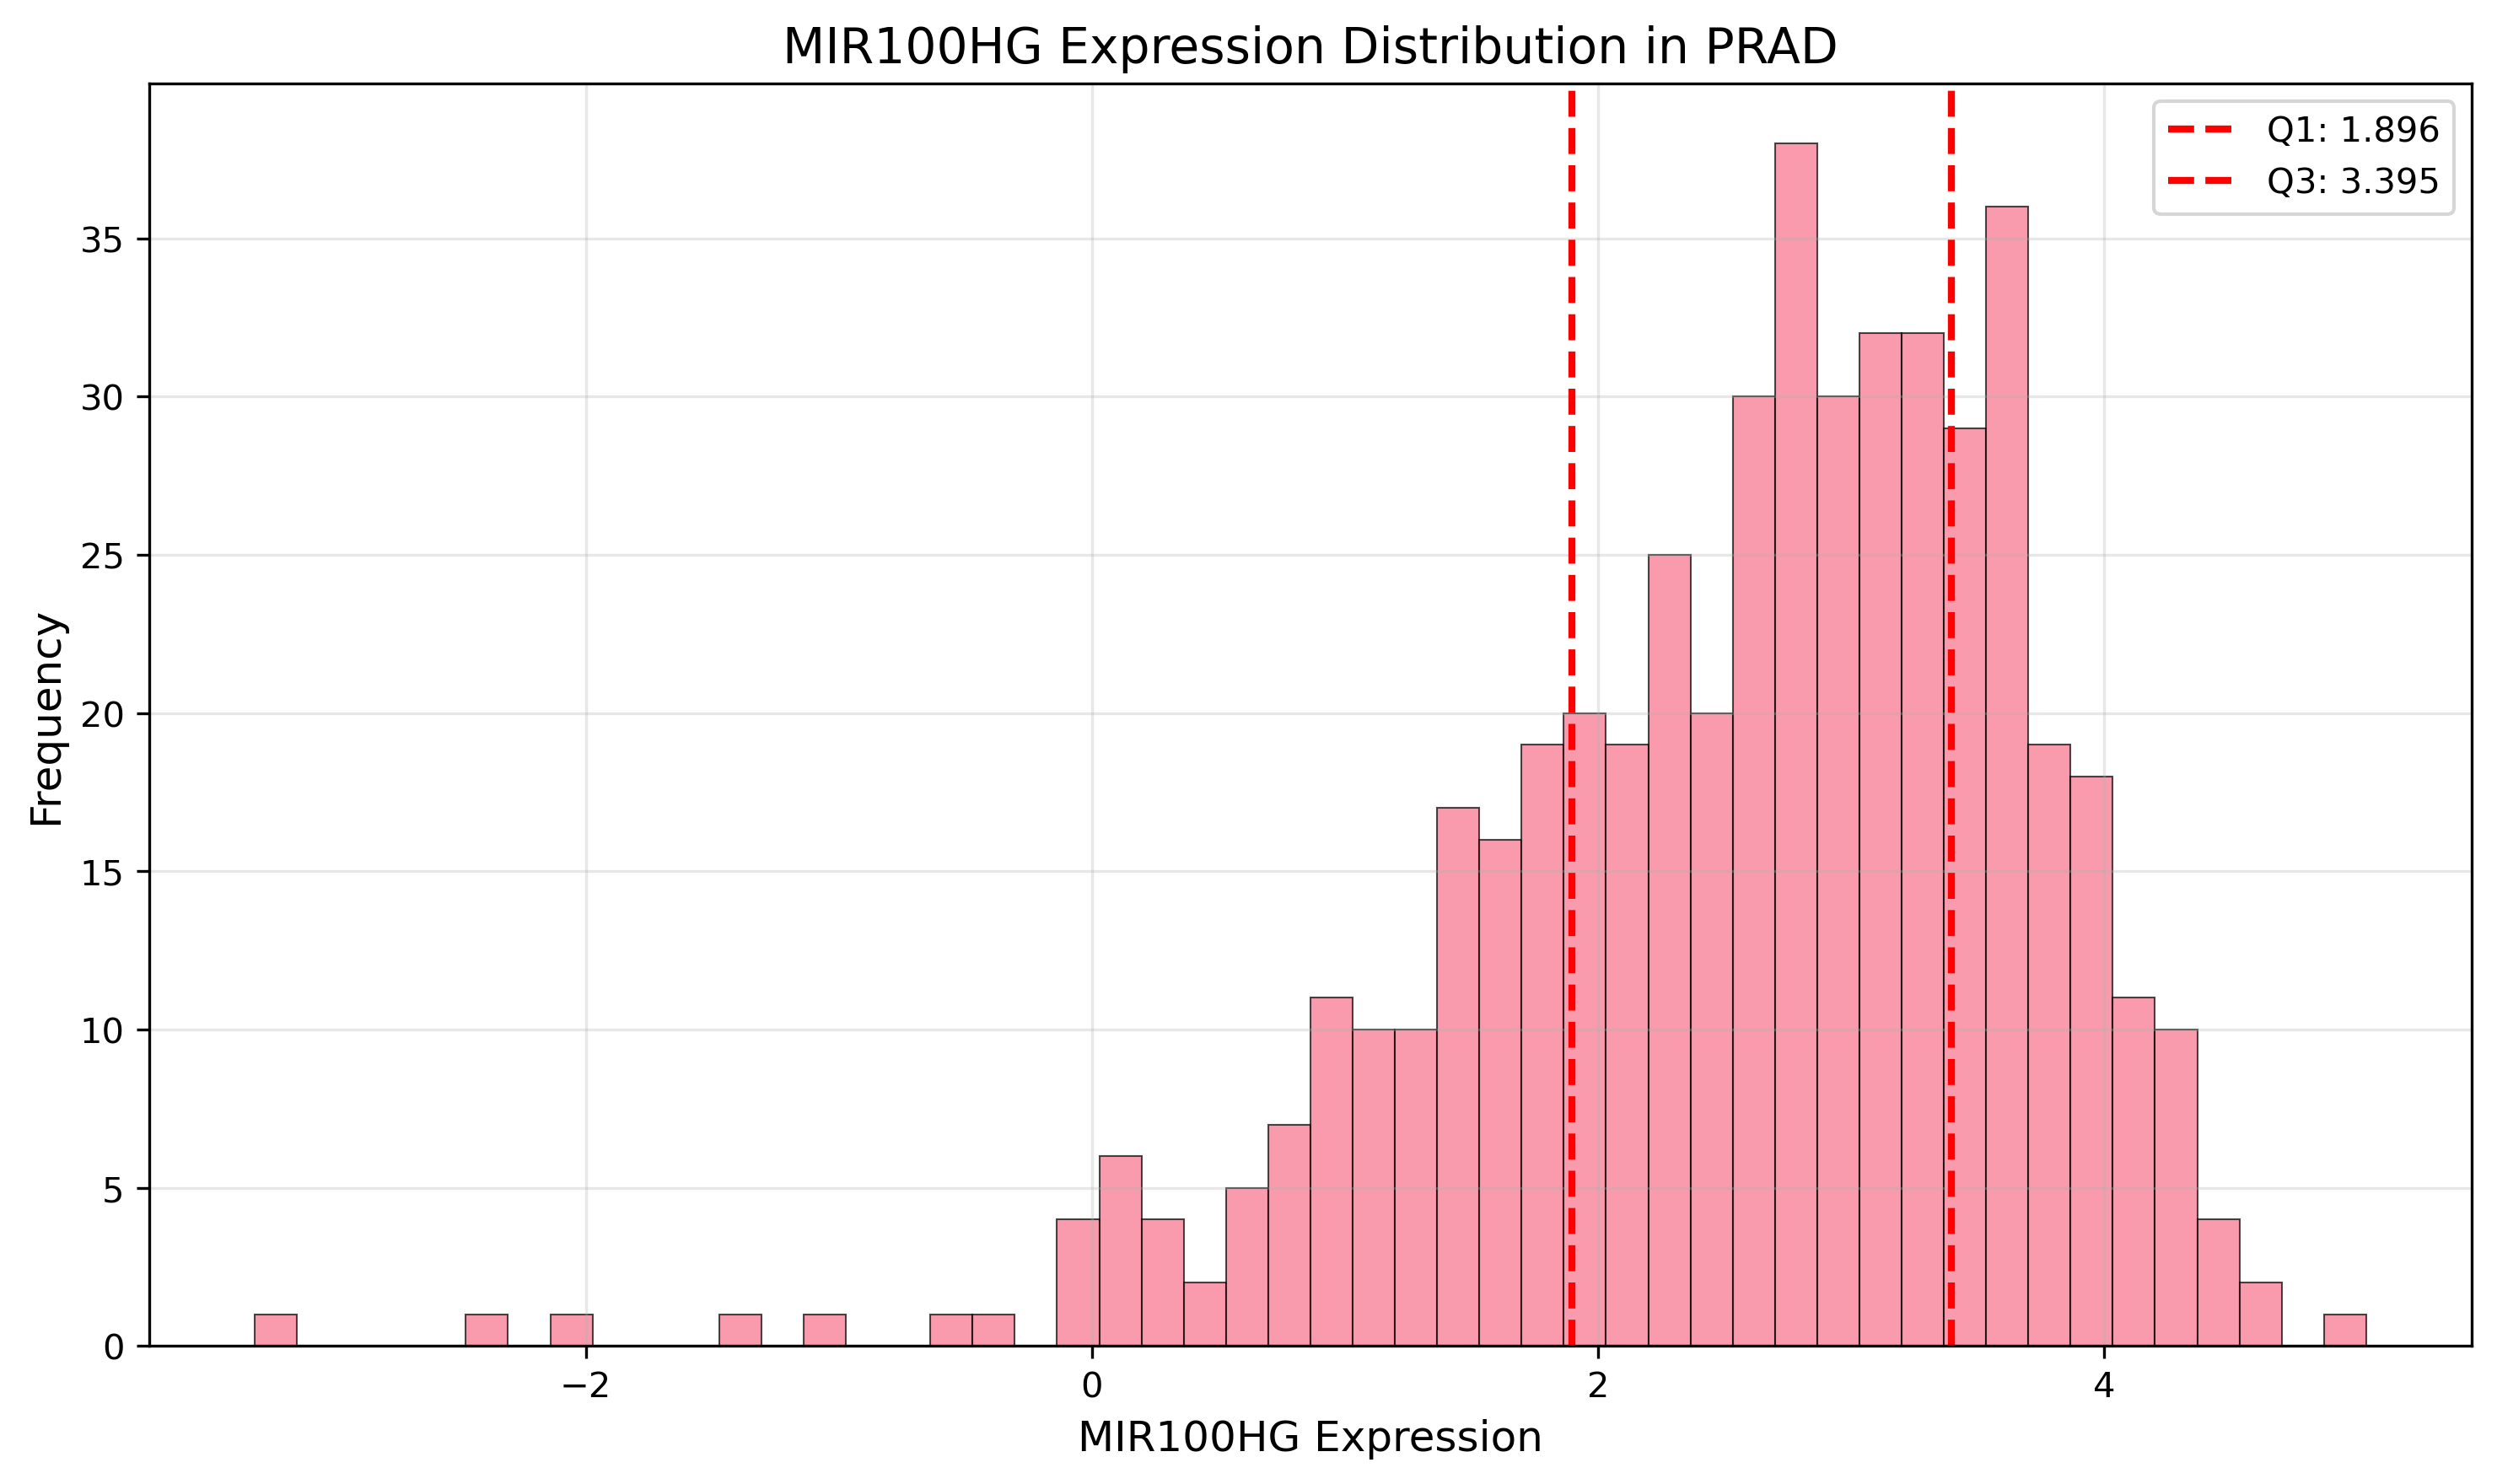

Stratification validation
Low (Q1): n=125, mean=1.059, range=-3.308-1.896
High (Q4): n=123, mean=3.810, range=3.398-5.034
Saving results
Stratified dataset saved to: /Users/dyuth/Desktop/Data Science Project/Data/PRAD_Merged_ExprANDSurvival_STRATIFIED.csv
   Shape: (494, 22324)
Q1 vs Q4 groups only


In [48]:
#Stratify samples by MIR100HG expression 
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


MERGED_FILENAME = str(PATHS["merged_final"])

df0 = pd.read_csv(MERGED_FILENAME)
print(f"Loaded: {MERGED_FILENAME}")
print(f"Shape: {df0.shape}")
print(f"Columns: {df0.columns.tolist()[:10]}{'...' if len(df0.columns) > 10 else ''}")



print("Searching for ANY MIR100HG-related columns")
mir_cols = [col for col in df0.columns if 'MIR100' in col.upper()]
print(f"Columns containing 'MIR100': {mir_cols}")


variations = ['MIR100HG', 'mir100hg', 'MIR100-HG', 'MIRN100HG', 'MIR100_HG']
found_variations = [col for col in df0.columns if col in variations]
print(f"Common variations found: {found_variations}")


case_insensitive = [col for col in df0.columns if col.upper() == 'MIR100HG']
print(f"Case-insensitive matches: {case_insensitive}")


mir_genes = [col for col in df0.columns if col.upper().startswith('MIR')]
print(f"All MIR genes found (first 10): {mir_genes[:10]}")


numbered_mir = [col for col in df0.columns if 'MIR' in col.upper() and '100' in col]
print(f"MIR genes with '100': {numbered_mir}")


print(f"\nFirst 20 columns: {df0.columns[:20].tolist()}")
print(f"Last 20 columns: {df0.columns[-20:].tolist()}")
print(f"Total columns: {len(df0.columns)}")


print(f"\nDataset shape: {df0.shape}")
print(f"Sample column present: {'sample' in df0.columns}")


if not mir_cols and not found_variations and not case_insensitive:
    
    raise ValueError("MIR100HG gene MISSING")



hr("MIR100HG validation")


mir100hg_cols = [col for col in df0.columns if 'MIR100HG' in col]
print(f"MIR100HG-related columns found: {mir100hg_cols}")

if not mir100hg_cols:
    raise ValueError("No MIR100HG column found in merged data.")

if "MIR100HG" in df0.columns:
    mir_col = "MIR100HG"
elif "MIR100HG_x" in df0.columns:
    mir_col = "MIR100HG_x"
    print("Using MIR100HG_x (from merge)")
elif "MIR100HG_y" in df0.columns:
    mir_col = "MIR100HG_y"
    print("Using MIR100HG_y (from merge)")
else:
    mir_col = mir100hg_cols[0]
    print(f"Using first available: {mir_col}")

print(f"Selected column: {mir_col}")

df = df0.copy()

#  DETAILED DEBUGGING:
# print(f"\nMIR100HG data inspection:")
# print(f"Column data type: {df[mir_col].dtype}")
# print(f"Unique value count: {df[mir_col].nunique()}")
# print(f"Non-null values: {df[mir_col].notna().sum()}")
# print(f"Sample values: {df[mir_col].head(10).tolist()}")

# print(f"Contains 'NaN' strings: {(df[mir_col] == 'NaN').sum()}")
# print(f"Contains 'nan' strings: {(df[mir_col] == 'nan').sum()}")
# print(f"Contains empty strings: {(df[mir_col] == '').sum()}")
# print(f"Actual NaN values: {df[mir_col].isna().sum()}")


# print(f"\nConverting to numeric...")
# df["MIR100HG"] = pd.to_numeric(df[mir_col], errors="coerce")

# print(f"After numeric conversion:")
# print(f"Valid numeric values: {df['MIR100HG'].notna().sum()}")
# print(f"NaN after conversion: {df['MIR100HG'].isna().sum()}")
# print(f"Sample converted values: {df['MIR100HG'].dropna().head(10).tolist()}")


before = df.shape[0]
df = df.dropna(subset=["MIR100HG"]).copy()
after = df.shape[0]

print(f"\nRows before dropna: {before}")
print(f"Rows after dropna : {after}")
print(f"Missing MIR100HG removed: {before - after}")

if after == 0:
    print("ALL MIR100HG values were lost during conversion!")
    raise ValueError("No valid MIR100HG values found after cleaning")

cols_to_drop = [col for col in df.columns if 'MIR100HG' in col and col != 'MIR100HG']
if cols_to_drop:
    print(f"Dropping duplicate MIR100HG columns: {cols_to_drop}")
    df = df.drop(columns=cols_to_drop)


df["MIR100HG_z"] = (df["MIR100HG"] - df["MIR100HG"].mean()) / df["MIR100HG"].std(ddof=0)


hr("MIR100HG stratification")


GROUPING = ANALYSIS_PARAMS.get("mir100hg_stratification", "quartile")
print(f"Grouping strategy: {GROUPING}")

if GROUPING == "quartile":
    q1, q3 = df["MIR100HG"].quantile([0.25, 0.75])
    print(f"Q1 (25th percentile): {q1:.3f}")
    print(f"Q3 (75th percentile): {q3:.3f}")
    
    df["MIR100HG_group"] = pd.cut(
        df["MIR100HG"],
        bins=[-np.inf, q1, q3, np.inf],
        labels=["Low (Q1)", "Mid (Q2–Q3)", "High (Q4)"],
        include_lowest=True
    )
    strata_mask = df["MIR100HG_group"].isin(["Low (Q1)", "High (Q4)"])
    
elif GROUPING == "median":
    med = df["MIR100HG"].median()
    print(f"Median: {med:.3f}")
    
    df["MIR100HG_group"] = np.where(df["MIR100HG"] >= med, "High (≥ median)", "Low (< median)")
    strata_mask = df["MIR100HG_group"].isin(["Low (< median)", "High (≥ median)"])
    
else:
    raise ValueError(f"Invalid GROUPING '{GROUPING}': must be 'quartile' or 'median'.")


hr("Creating stratified datasets")

strata_df = df[["sample", "MIR100HG", "MIR100HG_z", "MIR100HG_group"]].copy()


merged_strat = df0.merge(strata_df, on="sample", how="left")


strata_extremes = strata_df[strata_mask].copy()

print(f"Total samples with MIR100HG data: {len(strata_df)}")
print(f"Samples in extreme groups: {len(strata_extremes)}")


hr("Stratification summary")
print("Group counts (all samples):")
group_counts = strata_df["MIR100HG_group"].value_counts(dropna=False)
print(group_counts)

if GROUPING == "quartile":
    print("\nExtreme groups (for survival analysis):")
    extreme_counts = strata_extremes["MIR100HG_group"].value_counts()
    print(extreme_counts)

print(f"\nMIR100HG expression summary:")
mir_summary = df["MIR100HG"].describe()
print(mir_summary)

hr("Preview: strata_df (minimal)")
print(strata_df.head())

hr("Preview: merged_strat (full dataset + stratification)")
with pd.option_context("display.max_columns", 12):
    print(merged_strat.head())


hr("MIR100HG distribution visualization")

plt.figure(figsize=(10, 6))
plt.hist(df["MIR100HG"], bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)

if GROUPING == "quartile":
    plt.axvline(q1, color='red', linestyle='--', linewidth=2, label=f'Q1: {q1:.3f}')
    plt.axvline(q3, color='red', linestyle='--', linewidth=2, label=f'Q3: {q3:.3f}')
elif GROUPING == "median":
    plt.axvline(med, color='blue', linestyle='--', linewidth=2, label=f'Median: {med:.3f}')

plt.xlabel('MIR100HG Expression')
plt.ylabel('Frequency')
plt.title(f'MIR100HG Expression Distribution in {CANCER_TYPE}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


hr("Stratification validation")

if GROUPING == "quartile":
    for group in ["Low (Q1)", "High (Q4)"]:
        if group in strata_extremes["MIR100HG_group"].values:
            subset = strata_extremes[strata_extremes["MIR100HG_group"] == group]
            print(f"{group}: n={len(subset)}, "
                  f"mean={subset['MIR100HG'].mean():.3f}, "
                  f"range={subset['MIR100HG'].min():.3f}-{subset['MIR100HG'].max():.3f}")
        else:
            print(f"{group}: No samples found")
            
elif GROUPING == "median":
    for group in ["Low (< median)", "High (≥ median)"]:
        if group in strata_extremes["MIR100HG_group"].values:
            subset = strata_extremes[strata_extremes["MIR100HG_group"] == group]
            print(f"{group}: n={len(subset)}, "
                  f"mean={subset['MIR100HG'].mean():.3f}, "
                  f"range={subset['MIR100HG'].min():.3f}-{subset['MIR100HG'].max():.3f}")

hr("Saving results")

OUT_PATH = str(PATHS["merged_stratified"])
try:
    merged_strat.to_csv(OUT_PATH, index=False)
    print(f"Stratified dataset saved to: {OUT_PATH}")
    print(f"   Shape: {merged_strat.shape}")
except Exception as e:
    print(f"Error saving stratified dataset: {e}")
    raise


ANALYSIS_PARAMS["stratification_completed"] = True
ANALYSIS_PARAMS["total_stratified_samples"] = len(strata_df)
ANALYSIS_PARAMS["extreme_group_samples"] = len(strata_extremes)
ANALYSIS_PARAMS["grouping_method"] = GROUPING


merged_for_survival = merged_strat
if GROUPING == "quartile":
    print("Q1 vs Q4 groups only")
elif GROUPING == "median":
    print("Low vs High groups (median split)")


Loaded stratified dataset: 494 samples, 22324 columns

Detecting MIR100HG columns
Available MIR100HG columns: ['MIR100HG_x', 'MIR100HG_y', 'MIR100HG_z', 'MIR100HG_group']
Using columns:
  Expression: MIR100HG_x
  Z-score: MIR100HG_z
  Groups: MIR100HG_group

Preparing survival analysis data...
Removed 0 samples with missing data
Final survival cohort: 494 samples

Survival Data Summary:
Median follow-up time: 924.0 days (2.5 years)
Max follow-up time: 5024.0 days
Number of events (deaths): 10.0
Event rate: 2.0%

MIR100HG Group Distribution:
  Mid (Q2–Q3): 246 patients, 4.0 events (1.6%)
  Low (Q1): 125 patients, 4.0 events (3.2%)
  High (Q4): 123 patients, 2.0 events (1.6%)

Extreme groups analysis: 248 samples

Performing Kaplan-Meier survival analysis
Available groups for analysis: ['Mid (Q2–Q3)', 'High (Q4)', 'Low (Q1)']
Categories (3, object): ['Low (Q1)' < 'Mid (Q2–Q3)' < 'High (Q4)']


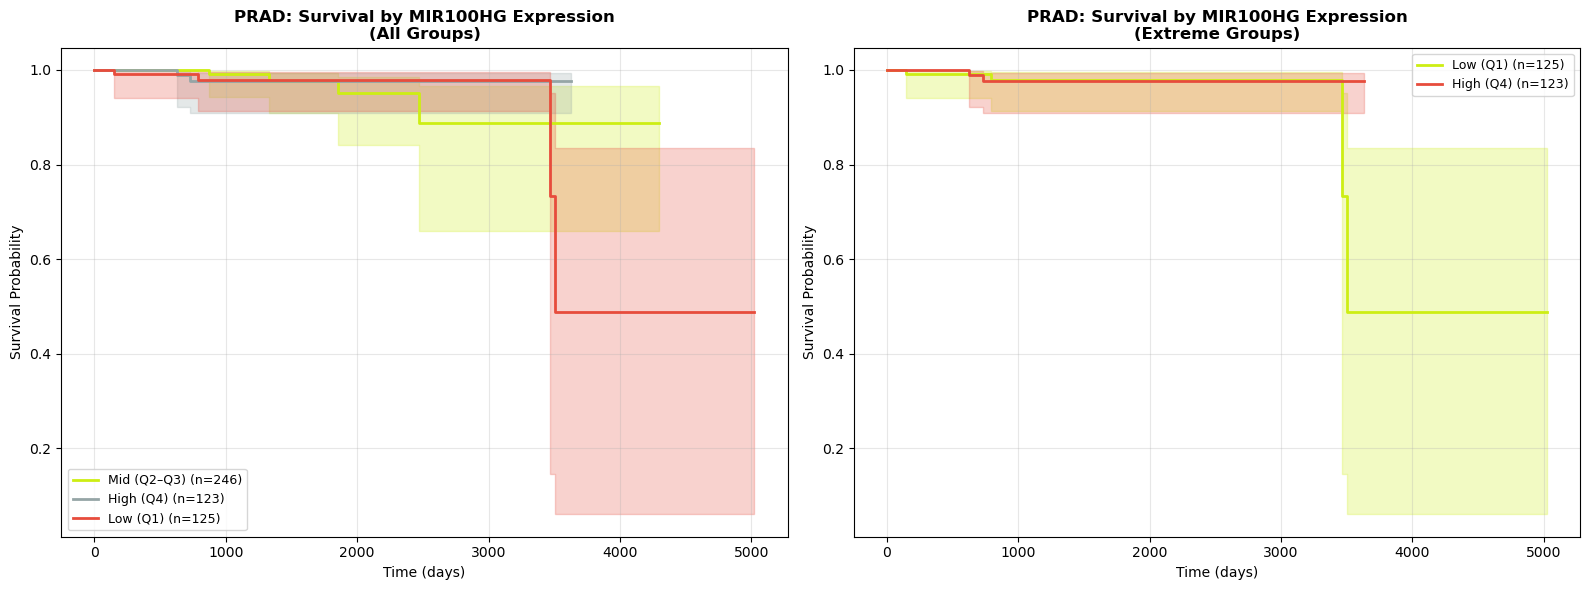


Median Survival Times:
  Mid (Q2–Q3): inf days (inf years)
  High (Q4): inf days (inf years)
  Low (Q1): 3502.0 days (9.6 years)

Performing log-rank test...
Log-rank test results (Low (Q1) vs High (Q4)):
  Test statistic: 0.154
  p-value: 0.695074
  Significant (p < 0.05): No
Clinical significance: No significant difference in survival between MIR100HG groups

Multivariate log-rank test (all groups):
Test statistic: 0.314
p-value: 0.854861
Overall group effect: Not significant

Performing Cox Proportional Hazards analysis...
Clinical variables available for Cox model: ['gender']

Attempting Cox Model 1 - Binary MIR100HG (High vs Low)...
  ✓ Model converged successfully
  Samples: 248
Hazard Ratio: 0.706 (95% CI: 0.122-4.065)
p-value: 0.696319
High MIR100HG associated with decreased risk of death (29.4%)


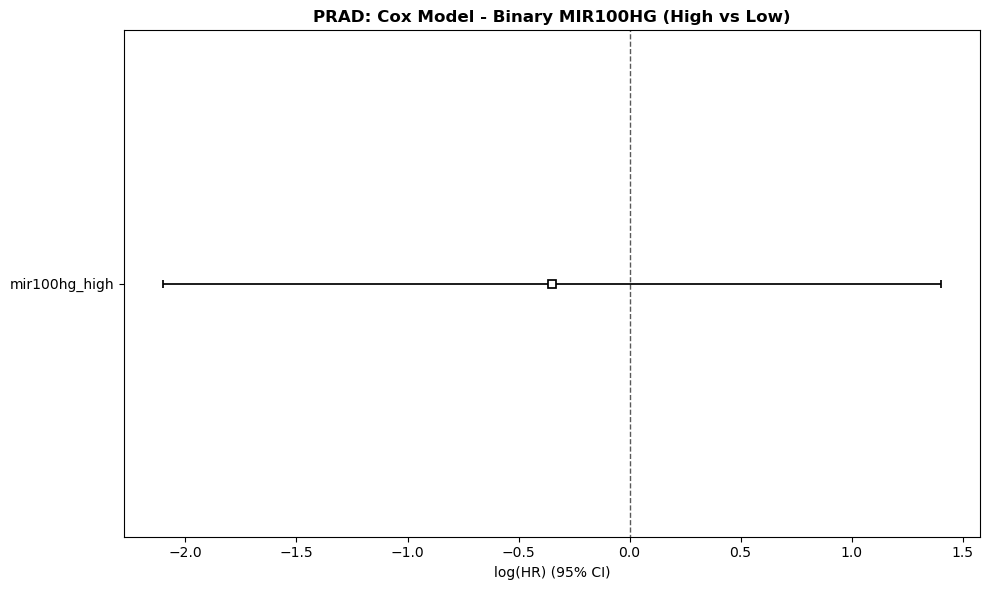


Attempting Cox Model 2 - Continuous MIR100HG (Z-score)...
Continuous model converged successfully
HR per 1 SD increase: 0.691 (p = 0.219938)


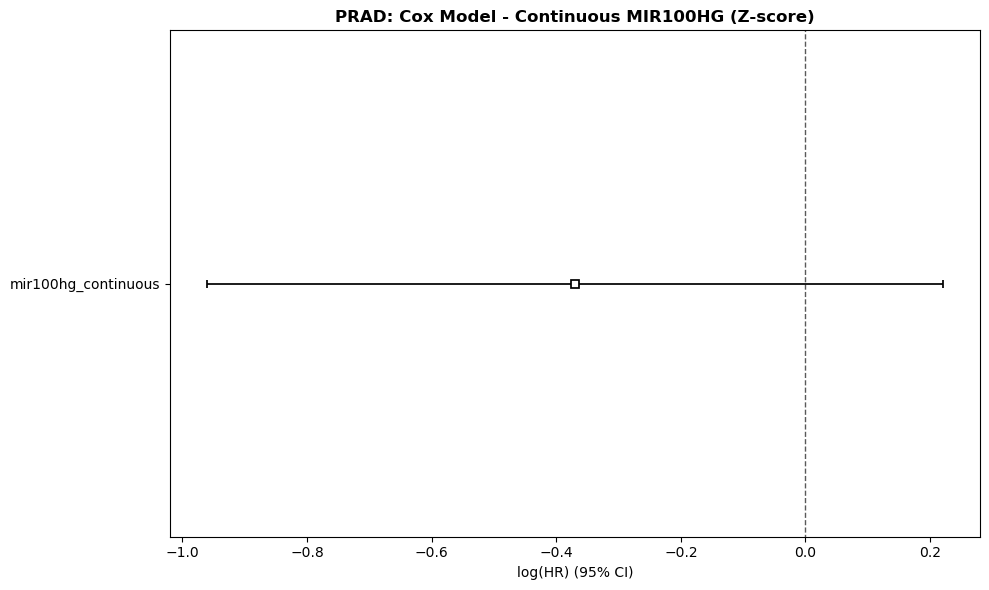


Attempting Cox Model 3 - Adjusted for clinical variables...
  ✗ Adjusted Cox model failed: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model

Cox Model Summary:
  Binary model: ✓ Success
  Continuous model: ✓ Success
  Adjusted model: ✗ Failed

Cohort Characteristics:
  Total samples with survival and MIR100HG data: 494
  Median follow-up: 924.0 days (2.5 years)
  Overall events (deaths): 10.0 (2.0%)

MIR100HG Stratification Results:
  Mid (Q2–Q3): 246 patients, 4.0 deaths (1.6% mortality)
  Low (Q1): 125 patients, 4.0 deaths (3.2% mortality)
  High (Q4): 123 patients, 2.0 deaths (1.6% mortality)

Statistical Results:
  Extreme groups survival difference: not significant (log-rank p = 0.695074)
  Overall group effect: not significant (p = 0.854861)

Clinical Interpretation for PRAD:
  MIR100HG expression no

In [61]:
# Survival Analysis Cell 

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


plt.style.use('default')
sns.set_palette("husl")





if 'merged_for_survival' not in locals():
    raise ValueError("merged_for_survival not found. Please run the stratification cell first.")

df = merged_for_survival.copy()

print(f"Loaded stratified dataset: {df.shape[0]} samples, {df.shape[1]} columns")


required_cols = ['sample', 'OS.time', 'OS']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"Warning: Missing required columns: {missing_cols}")
    print("Available columns containing 'OS' or 'time':")
    survival_cols = [col for col in df.columns if 'OS' in col.upper() or 'time' in col.lower()]
    for col in survival_cols:
        print(f"  - {col}")
    
 
    time_cols = [col for col in df.columns if 'time' in col.lower() and 'OS' in col.upper()]
    event_cols = [col for col in df.columns if col.upper() == 'OS' or 'event' in col.lower()]
    
    if time_cols:
        time_col = time_cols[0]
        print(f"Using time column: {time_col}")
    else:
        raise ValueError("Cannot find survival time column")
        
    if event_cols:
        event_col = event_cols[0] 
        print(f"Using event column: {event_col}")
    else:
        raise ValueError("Cannot find survival event column")
else:
    time_col = 'OS.time'
    event_col = 'OS'





print("\nDetecting MIR100HG columns")


mir_cols = [col for col in df.columns if 'MIR100HG' in col.upper()]
print(f"Available MIR100HG columns: {mir_cols}")


mir_expr_col = None
for col in mir_cols:
    if col.upper() == 'MIR100HG' and '_' not in col:
        mir_expr_col = col
        break
    elif 'MIR100HG_y' in col.upper() or 'MIR100HG_x' in col.upper():
        mir_expr_col = col
        break

if mir_expr_col is None and mir_cols:

    candidates = [col for col in mir_cols if '_group' not in col.lower() and '_z' not in col.lower()]
    if candidates:
        mir_expr_col = candidates[0]


mir_z_col = None
for col in mir_cols:
    if '_z' in col.lower():
        mir_z_col = col
        break


mir_group_col = None
for col in mir_cols:
    if '_group' in col.lower():
        mir_group_col = col
        break

if mir_group_col is None:
    raise ValueError("Cannot find MIR100HG_group column from stratification")

print(f"Using columns:")
print(f"  Expression: {mir_expr_col}")
print(f"  Z-score: {mir_z_col}")
print(f"  Groups: {mir_group_col}")





print("\nPreparing survival analysis data...")


analysis_cols = ['sample', time_col, event_col, mir_group_col]
if mir_expr_col:
    analysis_cols.append(mir_expr_col)
if mir_z_col:
    analysis_cols.append(mir_z_col)

analysis_df = df[analysis_cols].copy()


analysis_df[time_col] = pd.to_numeric(analysis_df[time_col], errors='coerce')
analysis_df[event_col] = pd.to_numeric(analysis_df[event_col], errors='coerce')


before_clean = len(analysis_df)
analysis_df = analysis_df.dropna(subset=[time_col, event_col, mir_group_col])
after_clean = len(analysis_df)

print(f"Removed {before_clean - after_clean} samples with missing data")
print(f"Final survival cohort: {after_clean} samples")

if after_clean == 0:
    raise ValueError("No samples remaining after data cleaning")


print(f"\nSurvival Data Summary:")
print(f"Median follow-up time: {analysis_df[time_col].median():.1f} days ({analysis_df[time_col].median()/365.25:.1f} years)")
print(f"Max follow-up time: {analysis_df[time_col].max():.1f} days")
print(f"Number of events (deaths): {analysis_df[event_col].sum()}")
print(f"Event rate: {analysis_df[event_col].mean()*100:.1f}%")


print(f"\nMIR100HG Group Distribution:")
group_counts = analysis_df[mir_group_col].value_counts()
for group, count in group_counts.items():
    events = analysis_df[analysis_df[mir_group_col] == group][event_col].sum()
    event_rate = (events / count) * 100 if count > 0 else 0
    print(f"  {group}: {count} patients, {events} events ({event_rate:.1f}%)")


extreme_groups = ['Low (Q1)', 'High (Q4)']
extreme_df = analysis_df[analysis_df[mir_group_col].isin(extreme_groups)].copy()
print(f"\nExtreme groups analysis: {len(extreme_df)} samples")

if len(extreme_df) == 0:
    print("Warning: No extreme groups found. Using all available groups.")
    extreme_df = analysis_df.copy()
    extreme_groups = analysis_df[mir_group_col].unique().tolist()





print("\nPerforming Kaplan-Meier survival analysis")


output_dir = Path(BASE_DIR) / PATHS["output_dir"]
output_dir.mkdir(exist_ok=True)


kmf = KaplanMeierFitter()


available_groups = analysis_df[mir_group_col].unique()
print(f"Available groups for analysis: {available_groups}")


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax1, ax2 = axes

#All groups
colors = [CANCER_COLOR, '#95A5A6', '#E74C3C']
median_survivals = {}

for i, group in enumerate(available_groups):
    group_data = analysis_df[analysis_df[mir_group_col] == group]
    if len(group_data) > 0:
        color = colors[i] if i < len(colors) else plt.cm.tab10(i)
        kmf.fit(group_data[time_col], group_data[event_col], label=f'{group} (n={len(group_data)})')
        kmf.plot_survival_function(ax=ax1, color=color, linewidth=2)
        median_survivals[group] = kmf.median_survival_time_

ax1.set_title(f'{CANCER_TYPE}: Survival by MIR100HG Expression\n(All Groups)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Time (days)', fontsize=10)
ax1.set_ylabel('Survival Probability', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9)

#Extreme groups only
extreme_available = [g for g in extreme_groups if g in available_groups]
colors_extreme = [CANCER_COLOR, '#E74C3C']

extreme_median_survivals = {}
for i, group in enumerate(extreme_available):
    group_data = extreme_df[extreme_df[mir_group_col] == group]
    if len(group_data) > 0:
        color = colors_extreme[i] if i < len(colors_extreme) else plt.cm.tab10(i)
        kmf.fit(group_data[time_col], group_data[event_col], label=f'{group} (n={len(group_data)})')
        kmf.plot_survival_function(ax=ax2, color=color, linewidth=2)
        extreme_median_survivals[group] = kmf.median_survival_time_

ax2.set_title(f'{CANCER_TYPE}: Survival by MIR100HG Expression\n(Extreme Groups)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Time (days)', fontsize=10)
ax2.set_ylabel('Survival Probability', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=9)

plt.tight_layout()
plt.savefig(output_dir / f"survival_kaplan_meier_{CANCER_TYPE.lower()}.png", dpi=300, bbox_inches='tight')
plt.show()


print(f"\nMedian Survival Times:")
for group, median_time in median_survivals.items():
    if pd.notna(median_time):
        print(f"  {group}: {median_time:.1f} days ({median_time/365.25:.1f} years)")
    else:
        print(f"  {group}: Not reached")





print("\nPerforming log-rank test...")


if len(extreme_available) >= 2:
    group1_name, group2_name = extreme_available[:2]
    group1_data = extreme_df[extreme_df[mir_group_col] == group1_name]
    group2_data = extreme_df[extreme_df[mir_group_col] == group2_name]

    if len(group1_data) > 0 and len(group2_data) > 0:
        results = logrank_test(
            group1_data[time_col], group2_data[time_col],
            group1_data[event_col], group2_data[event_col],
            alpha=0.05
        )
        
        print(f"Log-rank test results ({group1_name} vs {group2_name}):")
        print(f"  Test statistic: {results.test_statistic:.3f}")
        print(f"  p-value: {results.p_value:.6f}")
        print(f"  Significant (p < 0.05): {'Yes' if results.p_value < 0.05 else 'No'}")
        
        if results.p_value < 0.05:
            print(f"Clinical significance: MIR100HG expression levels significantly affect survival in {CANCER_TYPE}")
        else:
            print(f"Clinical significance: No significant difference in survival between MIR100HG groups")
    else:
        print("Insufficient data for log-rank test")
        results = None
else:
    print("Insufficient groups for pairwise log-rank test")
    results = None


if len(available_groups) > 2:
    try:
        multivar_results = multivariate_logrank_test(
            analysis_df[time_col], 
            analysis_df[mir_group_col], 
            analysis_df[event_col]
        )
        print(f"\nMultivariate log-rank test (all groups):")
        print(f"Test statistic: {multivar_results.test_statistic:.3f}")
        print(f"p-value: {multivar_results.p_value:.6f}")
        print(f"Overall group effect: {'Significant' if multivar_results.p_value < 0.05 else 'Not significant'}")
    except Exception as e:
        print(f"\nMultivariate log-rank test could not be performed: {str(e)}")
        multivar_results = None
else:
    multivar_results = None


#COX 


print("\nPerforming Cox Proportional Hazards analysis...")


cox_df = extreme_df.copy()


if len(extreme_available) >= 2:
    cox_df['mir100hg_high'] = (cox_df[mir_group_col] == high_group).astype(int)
else:
    print("Warning: Insufficient extreme groups for Cox regression")
    cox_df['mir100hg_high'] = 0


if mir_z_col and mir_z_col in cox_df.columns:
    cox_df['mir100hg_continuous'] = cox_df[mir_z_col]  
elif mir_expr_col and mir_expr_col in cox_df.columns:
    cox_df['mir100hg_continuous'] = (cox_df[mir_expr_col] - cox_df[mir_expr_col].mean()) / cox_df[mir_expr_col].std()


clinical_vars = []
potential_clinical = ['age', 'gender', 'stage', 'grade', 'Age', 'Gender', 'Stage', 'Grade', 
                     'pathologic_stage', 'histologic_grade', 'tumor_grade']

for var in potential_clinical:
    if var in df.columns:
        cox_df = pd.merge(cox_df, df[['sample', var]], on='sample', how='left')
        
       
        if cox_df[var].dtype == 'object':
   
            unique_vals = cox_df[var].dropna().unique()
            if len(unique_vals) <= 5:  
                cox_df[var] = pd.Categorical(cox_df[var]).codes
                cox_df[var] = cox_df[var].replace(-1, np.nan) 
        else:
            cox_df[var] = pd.to_numeric(cox_df[var], errors='coerce')
        
     
        if cox_df[var].notna().sum() > len(cox_df) * 0.5:
            clinical_vars.append(var)

print(f"Clinical variables available for Cox model: {clinical_vars}")


cox_binary_success = False
cox_continuous_success = False
cox_adjusted_success = False

#MIR100HG binary (High vs Low)
print(f"\nAttempting Cox Model 1 - Binary MIR100HG (High vs Low)...")
cox_columns_binary = [time_col, event_col, 'mir100hg_high']
cox_data_binary = cox_df[cox_columns_binary].dropna()

if len(cox_data_binary) > 10 and cox_data_binary['mir100hg_high'].nunique() > 1:
    try:
        cph = CoxPHFitter()
        cph.fit(cox_data_binary, duration_col=time_col, event_col=event_col)
        
        print(f"  ✓ Model converged successfully")
        print(f"  Samples: {len(cox_data_binary)}")
        
        hr_binary = cph.summary.loc['mir100hg_high', 'exp(coef)']
        ci_lower = cph.summary.loc['mir100hg_high', 'exp(coef) lower 95%']
        ci_upper = cph.summary.loc['mir100hg_high', 'exp(coef) upper 95%']
        p_val = cph.summary.loc['mir100hg_high', 'p']
        
        print(f"Hazard Ratio: {hr_binary:.3f} (95% CI: {ci_lower:.3f}-{ci_upper:.3f})")
        print(f"p-value: {p_val:.6f}")
        
        risk_interpretation = "increased" if hr_binary > 1 else "decreased"
        risk_magnitude = abs((hr_binary - 1) * 100)
        print(f"High MIR100HG associated with {risk_interpretation} risk of death ({risk_magnitude:.1f}%)")
        
     
        plt.figure(figsize=(10, 6))
        cph.plot()
        plt.title(f'{CANCER_TYPE}: Cox Model - Binary MIR100HG (High vs Low)', 
                 fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.savefig(output_dir / f"survival_cox_binary_{CANCER_TYPE.lower()}.png", 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        cox_binary_success = True
        
    except Exception as e:
        print(f"Binary Cox model failed: {str(e)}")
        

#MIR100HG continuous 
if 'mir100hg_continuous' in cox_df.columns:
    print(f"\nAttempting Cox Model 2 - Continuous MIR100HG (Z-score)...")
    cox_columns_continuous = [time_col, event_col, 'mir100hg_continuous']
    cox_data_continuous = cox_df[cox_columns_continuous].dropna()
    
    if len(cox_data_continuous) > 10 and cox_data_continuous['mir100hg_continuous'].std() > 0.1:
        try:
            cph_cont = CoxPHFitter()
            cph_cont.fit(cox_data_continuous, duration_col=time_col, event_col=event_col)
            
            print(f"Continuous model converged successfully")
            hr_cont = cph_cont.summary.loc['mir100hg_continuous', 'exp(coef)']
            p_val_cont = cph_cont.summary.loc['mir100hg_continuous', 'p']
            print(f"HR per 1 SD increase: {hr_cont:.3f} (p = {p_val_cont:.6f})")
            
           
            plt.figure(figsize=(10, 6))
            cph_cont.plot()
            plt.title(f'{CANCER_TYPE}: Cox Model - Continuous MIR100HG (Z-score)', 
                     fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.savefig(output_dir / f"survival_cox_continuous_{CANCER_TYPE.lower()}.png", 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            cox_continuous_success = True
            
        except Exception as e:
            print(f"Continuous Cox model failed: {str(e)}")
    else:
        print(f"Insufficient data or variation for continuous model")

#Adjusted for clinical variables
if clinical_vars and cox_binary_success:
    print(f"\nAttempting Cox Model 3 - Adjusted for clinical variables...")
    cox_columns_adjusted = [time_col, event_col, 'mir100hg_high'] + clinical_vars
    cox_data_adjusted = cox_df[cox_columns_adjusted].dropna()
    
    if len(cox_data_adjusted) > 20: 
        try:
            cph_adj = CoxPHFitter()
            cph_adj.fit(cox_data_adjusted, duration_col=time_col, event_col=event_col)
            
            print(f"  ✓ Adjusted model converged successfully")
            print(f"  Samples: {len(cox_data_adjusted)}")
            
            hr_adj = cph_adj.summary.loc['mir100hg_high', 'exp(coef)']
            ci_lower_adj = cph_adj.summary.loc['mir100hg_high', 'exp(coef) lower 95%']
            ci_upper_adj = cph_adj.summary.loc['mir100hg_high', 'exp(coef) upper 95%']
            p_val_adj = cph_adj.summary.loc['mir100hg_high', 'p']
            
            print(f"  Adjusted HR: {hr_adj:.3f} (95% CI: {ci_lower_adj:.3f}-{ci_upper_adj:.3f})")
            print(f"  Adjusted p-value: {p_val_adj:.6f}")
            
            print(f"  Clinical variables in model: {', '.join(clinical_vars)}")
            
      
            plt.figure(figsize=(10, 6))
            cph_adj.plot()
            plt.title(f'{CANCER_TYPE}: Cox Model - MIR100HG Adjusted for Clinical Variables', 
                     fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.savefig(output_dir / f"survival_cox_adjusted_{CANCER_TYPE.lower()}.png", 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            cox_adjusted_success = True
            
        except Exception as e:
            print(f"  ✗ Adjusted Cox model failed: {str(e)}")
    else:
        print(f"  ⚠ Insufficient samples for multivariate analysis ({len(cox_data_adjusted)} < 20)")
else:
    if not clinical_vars:
        print(f"\nNo clinical variables available for adjusted Cox model")
    if not cox_binary_success:
        print(f"Binary Cox model must succeed before attempting adjusted model")


print(f"\nCox Model Summary:")
print(f"  Binary model: {'✓ Success' if cox_binary_success else '✗ Failed'}")
print(f"  Continuous model: {'✓ Success' if cox_continuous_success else '✗ Failed'}")
print(f"  Adjusted model: {'✓ Success' if cox_adjusted_success else '✗ Failed'}")

if not any([cox_binary_success, cox_continuous_success, cox_adjusted_success]):
    print(f"\n⚠ All Cox models failed to converge.")
    print(f"  This is common with low event rates ({analysis_df[event_col].mean()*100:.1f}% events in {CANCER_TYPE})")
    print(f"  Log-rank test and Kaplan-Meier curves remain valid and informative.")




print(f"\nCohort Characteristics:")
print(f"  Total samples with survival and MIR100HG data: {len(analysis_df)}")
print(f"  Median follow-up: {analysis_df[time_col].median():.1f} days ({analysis_df[time_col].median()/365.25:.1f} years)")
print(f"  Overall events (deaths): {analysis_df[event_col].sum()} ({analysis_df[event_col].mean()*100:.1f}%)")

print(f"\nMIR100HG Stratification Results:")
for group in group_counts.index:
    count = group_counts[group]
    events = analysis_df[analysis_df[mir_group_col] == group][event_col].sum()
    event_rate = (events / count) * 100
    print(f"  {group}: {count} patients, {events} deaths ({event_rate:.1f}% mortality)")

print(f"\nStatistical Results:")
if results is not None:
    significance = "significant" if results.p_value < 0.05 else "not significant"
    print(f"  Extreme groups survival difference: {significance} (log-rank p = {results.p_value:.6f})")

if multivar_results is not None:
    overall_sig = "significant" if multivar_results.p_value < 0.05 else "not significant"
    print(f"  Overall group effect: {overall_sig} (p = {multivar_results.p_value:.6f})")

print(f"\nClinical Interpretation for {CANCER_TYPE}:")
if cox_binary_success and 'hr_binary' in locals():
    if results is not None and results.p_value < 0.05:
        prognostic_value = "prognostic biomarker" if hr_binary > 1.2 or hr_binary < 0.8 else "limited prognostic value"
        direction = "worse" if hr_binary > 1 else "better"
        print(f"  High MIR100HG expression associated with {direction} survival")
        print(f"  MIR100HG shows potential as {prognostic_value} in {CANCER_TYPE}")
        
        if cox_adjusted_success and 'hr_adj' in locals():
            independence = "independent" if p_val_adj < 0.05 else "not independent"
            print(f"  Prognostic effect is {independence} of standard clinical variables")
    else:
        print(f"  MIR100HG expression not significantly associated with survival")
        print(f"  Limited utility as prognostic biomarker in this {CANCER_TYPE} cohort")
else:
    print(f"  Cox regression analysis could not be completed due to convergence issues")
    print(f"  This is common in datasets with very low event rates ({analysis_df[event_col].mean()*100:.1f}%)")
    print(f"  Kaplan-Meier analysis and log-rank tests remain valid")
    if results is not None:
        if results.p_value < 0.05:
            print(f"  Log-rank test suggests MIR100HG may have prognostic value")
        else:
            print(f"  Log-rank test shows no significant survival difference between groups")

print(f"\nFiles Generated:")
print(f"  - survival_kaplan_meier_{CANCER_TYPE.lower()}.png")
if cox_binary_success:
    print(f"  - survival_cox_binary_{CANCER_TYPE.lower()}.png")
if cox_continuous_success:
    print(f"  - survival_cox_continuous_{CANCER_TYPE.lower()}.png")
if cox_adjusted_success:
    print(f"  - survival_cox_adjusted_{CANCER_TYPE.lower()}.png")


summary_data = {
    'Cancer_Type': CANCER_TYPE,
    'Total_Samples': len(analysis_df),
    'Q1_Samples': len(extreme_df[extreme_df[mir_group_col].str.contains('Q1', na=False)]) if len(extreme_df) > 0 else np.nan,
    'Q4_Samples': len(extreme_df[extreme_df[mir_group_col].str.contains('Q4', na=False)]) if len(extreme_df) > 0 else np.nan,
    'Median_Followup_Days': analysis_df[time_col].median(),
    'Overall_Event_Rate': analysis_df[event_col].mean(),
    'LogRank_P_Value': results.p_value if results is not None else np.nan,
    'Multivariate_P_Value': multivar_results.p_value if multivar_results is not None else np.nan,
    'Cox_Binary_Success': cox_binary_success,
    'Cox_Binary_HR': hr_binary if cox_binary_success and 'hr_binary' in locals() else np.nan,
    'Cox_Binary_P_Value': p_val if cox_binary_success and 'p_val' in locals() else np.nan,
    'Cox_Adjusted_Success': cox_adjusted_success,
    'Cox_Adjusted_HR': hr_adj if cox_adjusted_success and 'hr_adj' in locals() else np.nan,
    'Cox_Adjusted_P_Value': p_val_adj if cox_adjusted_success and 'p_val_adj' in locals() else np.nan,
    'Clinical_Variables_Used': ', '.join(clinical_vars) if clinical_vars else 'None'
}

summary_df = pd.DataFrame([summary_data])
summary_df.to_csv(output_dir / f"survival_analysis_summary_{CANCER_TYPE.lower()}.csv", index=False)



Loaded: /Users/dyuth/Desktop/Data Science Project/Data/GTEX_Prostate_Matched_Normal_PRAD.csv
Shape: (101, 25113)
Using tissue-matched Prostate samples: 100
MIR100HG availability (Prostate Normal)
Rows before dropna: 101
Rows after dropna : 101
Missing MIR100HG removed: 0
Outlier Detection
Original MIR100HG range: 2.967 to 7.080
IQR outlier bounds: 3.056 to 7.106
Outliers detected: 2 samples
Outlier values: [2.9674, 3.0038]
Samples after outlier removal: 99 (removed 2)
Clean MIR100HG range: 3.466 to 7.080
MIR100HG Stratification (Clean Data)
Grouping strategy: quartile
Quartile boundaries: Q1=4.577, Q3=5.601
Quality Control Plots


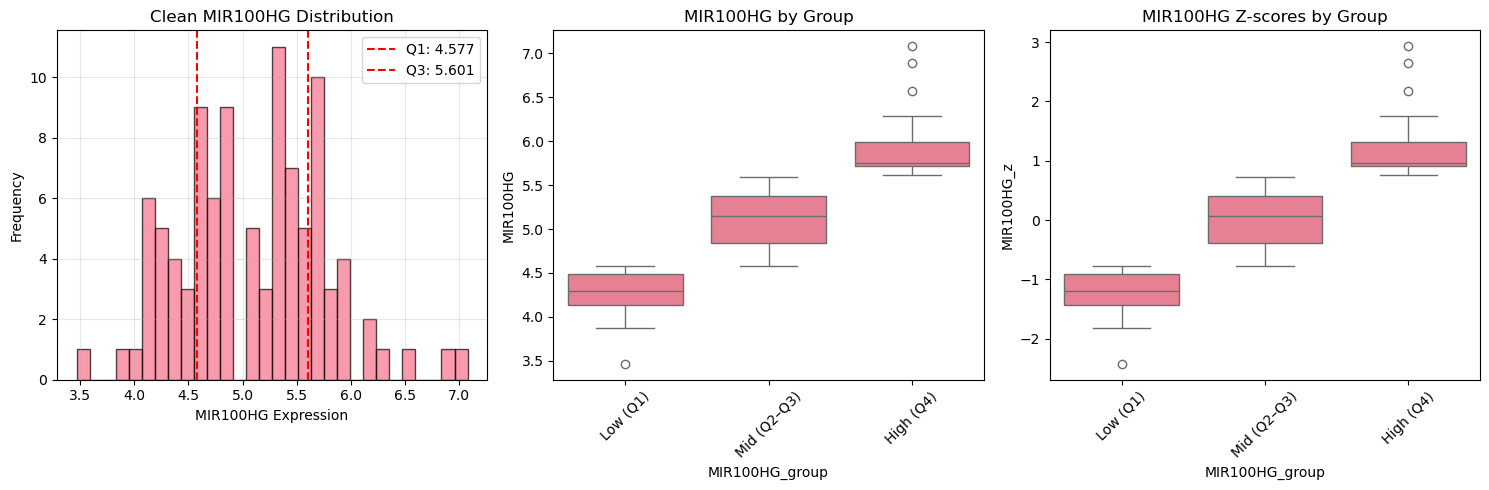

Stratification Summary (Prostate Normal)
Final sample count: 99
Outliers removed: 2
Grouping strategy: quartile

Group counts:
MIR100HG_group
Mid (Q2–Q3)    49
Low (Q1)       25
High (Q4)      25
Name: count, dtype: int64

Extreme groups (for DEA):
MIR100HG_group
Low (Q1)       25
High (Q4)      25
Mid (Q2–Q3)     0
Name: count, dtype: int64

Expected samples per quartile: ~25
Low (Q1): 25 samples (25.3% of total)
High (Q4): 25 samples (25.3% of total)
Mid (Q2–Q3): 0 samples (0.0% of total)

MIR100HG expression summary (clean data):
count    99.000000
mean      5.102284
std       0.678368
min       3.466100
25%       4.577200
50%       5.145700
75%       5.600650
max       7.079700
Name: MIR100HG, dtype: float64

Group-wise statistics:
                count      mean       std     min     25%     50%     75%  \
MIR100HG_group                                                              
Low (Q1)         25.0  4.265948  0.256352  3.4661  4.1302  4.2936  4.4938   
Mid (Q2–Q3)      49.0  

In [50]:
#Stratify GTEX samples by MIR100HG expression 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


normal_dataset_path = get_normal_dataset_path()
MERGED_FILENAME = str(normal_dataset_path)

df0 = pd.read_csv(MERGED_FILENAME)
print(f"Loaded: {MERGED_FILENAME}")
print(f"Shape: {df0.shape}")


if 'Primary_site' in df0.columns:
    target_organ = ANALYSIS_PARAMS['target_organ']
    organ_samples = df0[df0['Primary_site'] == target_organ]
    print(f"Using tissue-matched {target_organ} samples: {len(organ_samples)}")
else:
    print("Using original GTEX data")
    target_organ = ANALYSIS_PARAMS['target_organ']


if "MIR100HG" not in df0.columns:
    raise ValueError("'MIR100HG' not found in expression file. Check that gene symbols are columns.")

df = df0.copy()


if isinstance(df.iloc[0]["MIR100HG"], str) and df.iloc[0]["MIR100HG"].startswith('ENSG'):
    print("Detected gene IDs in first row, removing...")
    df = df.iloc[1:].reset_index(drop=True)
    print(f"Shape after removing header row: {df.shape}")


df["MIR100HG"] = pd.to_numeric(df["MIR100HG"], errors="coerce")

before = df.shape[0]
df = df.dropna(subset=["MIR100HG"]).copy()
after = df.shape[0]

hr(f"MIR100HG availability ({target_organ} Normal)")
print(f"Rows before dropna: {before}")
print(f"Rows after dropna : {after}")
print(f"Missing MIR100HG removed: {before - after}")


hr("Outlier Detection")
print(f"Original MIR100HG range: {df['MIR100HG'].min():.3f} to {df['MIR100HG'].max():.3f}")


Q1_orig = df['MIR100HG'].quantile(0.25)
Q3_orig = df['MIR100HG'].quantile(0.75)
IQR = Q3_orig - Q1_orig
lower_bound = Q1_orig - 1.5 * IQR
upper_bound = Q3_orig + 1.5 * IQR

print(f"IQR outlier bounds: {lower_bound:.3f} to {upper_bound:.3f}")


outliers = df[(df['MIR100HG'] < lower_bound) | (df['MIR100HG'] > upper_bound)]
print(f"Outliers detected: {len(outliers)} samples")

if len(outliers) > 0:
    print("Outlier values:", outliers['MIR100HG'].tolist())
    

    df_clean = df[(df['MIR100HG'] >= lower_bound) & (df['MIR100HG'] <= upper_bound)].copy()
    print(f"Samples after outlier removal: {len(df_clean)} (removed {len(outliers)})")
    
 
    df = df_clean.copy()
else:
    print("No outliers detected")

print(f"Clean MIR100HG range: {df['MIR100HG'].min():.3f} to {df['MIR100HG'].max():.3f}")


df["MIR100HG_z"] = (df["MIR100HG"] - df["MIR100HG"].mean()) / df["MIR100HG"].std(ddof=0)


hr("MIR100HG Stratification (Clean Data)")
GROUPING = ANALYSIS_PARAMS.get("mir100hg_stratification", "quartile")
print(f"Grouping strategy: {GROUPING}")

if GROUPING == "quartile":
    q1, q3 = df["MIR100HG"].quantile([0.25, 0.75])
    print(f"Quartile boundaries: Q1={q1:.3f}, Q3={q3:.3f}")
    
    df["MIR100HG_group"] = pd.cut(
        df["MIR100HG"],
        bins=[-np.inf, q1, q3, np.inf],
        labels=["Low (Q1)", "Mid (Q2–Q3)", "High (Q4)"],
        include_lowest=True
    )
    strata_mask = df["MIR100HG_group"].isin(["Low (Q1)", "High (Q4)"])
    
elif GROUPING == "median":
    med = df["MIR100HG"].median()
    print(f"Median: {med:.3f}")
    df["MIR100HG_group"] = np.where(df["MIR100HG"] >= med, "High (≥ median)", "Low (< median)")
    strata_mask = df["MIR100HG_group"].isin(["Low (< median)", "High (≥ median)"])
else:
    raise ValueError("Invalid GROUPING: must be 'quartile' or 'median'.")


hr("Quality Control Plots")

plt.figure(figsize=(15, 5))

#Distribution with quartile lines
plt.subplot(1, 3, 1)
plt.hist(df['MIR100HG'], bins=30, alpha=0.7, edgecolor='black')
if GROUPING == "quartile":
    plt.axvline(q1, color='red', linestyle='--', label=f'Q1: {q1:.3f}')
    plt.axvline(q3, color='red', linestyle='--', label=f'Q3: {q3:.3f}')
elif GROUPING == "median":
    plt.axvline(med, color='blue', linestyle='--', label=f'Median: {med:.3f}')
plt.xlabel('MIR100HG Expression')
plt.ylabel('Frequency')
plt.title('Clean MIR100HG Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

#Boxplot by group
plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='MIR100HG_group', y='MIR100HG')
plt.title('MIR100HG by Group')
plt.xticks(rotation=45)

#Z-score distribution
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='MIR100HG_group', y='MIR100HG_z')
plt.title('MIR100HG Z-scores by Group')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

strata_df = df[["sample", "MIR100HG", "MIR100HG_z", "MIR100HG_group"]].copy()


merged_strat = df0[df0['sample'].isin(strata_df['sample'])].merge(strata_df, on="sample", how="left")

strata_extremes = strata_df[strata_mask].copy()

hr(f"Stratification Summary ({target_organ} Normal)")
print(f"Final sample count: {len(df)}")
print(f"Outliers removed: {len(outliers) if len(outliers) > 0 else 0}")
print(f"Grouping strategy: {GROUPING}")

print("\nGroup counts:")
group_counts = strata_df["MIR100HG_group"].value_counts(dropna=False)
print(group_counts)

if GROUPING == "quartile":
    print("\nExtreme groups (for DEA):")
    extreme_counts = strata_extremes["MIR100HG_group"].value_counts()
    print(extreme_counts)
    
 
    total_samples = len(strata_df)
    expected_per_quartile = total_samples / 4
    print(f"\nExpected samples per quartile: ~{expected_per_quartile:.0f}")
    
    for group, count in extreme_counts.items():
        percentage = (count / total_samples) * 100
        print(f"{group}: {count} samples ({percentage:.1f}% of total)")

print("\nMIR100HG expression summary (clean data):")
print(df["MIR100HG"].describe())

print("\nGroup-wise statistics:")
group_stats = df.groupby('MIR100HG_group')['MIR100HG'].describe()
print(group_stats)

hr("Data Quality Validation")


if GROUPING == "quartile":
    q1_max = df[df['MIR100HG_group'] == 'Low (Q1)']['MIR100HG'].max()
    q4_min = df[df['MIR100HG_group'] == 'High (Q4)']['MIR100HG'].min()
    gap = q4_min - q1_max
    print(f"Gap between Q1 max ({q1_max:.3f}) and Q4 min ({q4_min:.3f}): {gap:.3f}")
    
    if gap > 0:
        print("Clear separation between Q1 and Q4 groups")
    else:
        print("Overlap detected between Q1 and Q4 groups")


print("\nWithin-group variance:")
for group in df['MIR100HG_group'].unique():
    group_data = df[df['MIR100HG_group'] == group]['MIR100HG']
    print(f"{group}: std = {group_data.std():.3f}, range = {group_data.max() - group_data.min():.3f}")


hr("Saving Results")


if get_normal_dataset_type() == "tissue_matched":
    OUT_PATH = PATHS["tissue_matched_normal"].parent / f"GTEX_{target_organ}_Matched_Normal_{CANCER_TYPE}_STRATIFIED_CLEAN.csv"
else:
    OUT_PATH = Path(str(PATHS["gtex_expr_normalized"]).replace("_NORMALIZED.csv", "_STRATIFIED_CLEAN.csv"))

merged_strat.to_csv(OUT_PATH, index=False)
print(f"Clean stratified normal expression saved to: {OUT_PATH}")


PATHS["normal_expr_stratified"] = OUT_PATH
PATHS["normal_expr_stratified_clean"] = OUT_PATH


summary_data = {
    'cancer_type': CANCER_TYPE,
    'target_organ': target_organ,
    'original_samples': before,
    'samples_after_na_removal': after,
    'outliers_detected': len(outliers) if len(outliers) > 0 else 0,
    'final_samples': len(df),
    'grouping_method': GROUPING,
    'q1_samples': extreme_counts.get('Low (Q1)', 0) if GROUPING == "quartile" else 0,
    'q4_samples': extreme_counts.get('High (Q4)', 0) if GROUPING == "quartile" else 0,
    'mir100hg_range_min': df['MIR100HG'].min(),
    'mir100hg_range_max': df['MIR100HG'].max(),
    'quartile_gap': gap if GROUPING == "quartile" else None
}

summary_df = pd.DataFrame([summary_data])
summary_path = OUT_PATH.parent / f"stratification_summary_{target_organ}_{CANCER_TYPE}.csv"
summary_df.to_csv(summary_path, index=False)
print(f"Stratification summary saved to: {summary_path}")



In [51]:
#Filtering to just Protein Coding and MIR100HG

import pandas as pd


map_path = str(PATHS["gene_mapping"])
with open(map_path, "r", encoding="utf-8") as f:
    lines = f.readlines()


split_lines = [line.strip().replace('"', '').split("\t") for line in lines]
map_df = pd.DataFrame(split_lines, columns=["Ensembl_ID", "Biotype", "Symbol"])
print("Loaded mapping file:", map_df.shape)


map_df["Ensembl_ID"] = map_df["Ensembl_ID"].str.replace(r"\.\d+$", "", regex=True)
map_df["Biotype"] = map_df["Biotype"].str.strip().str.lower()
map_df["Symbol"] = map_df["Symbol"].str.strip()


print("Unique Biotypes:", sorted(map_df["Biotype"].unique()))
print("MIR100HG match:", map_df[map_df["Symbol"].str.upper() == "MIR100HG"])


filtered_map = map_df[
    (map_df["Biotype"] == "protein_coding") |
    (map_df["Symbol"].str.upper() == "MIR100HG")
].copy()


out_path = str(PATHS["gene_mapping_filtered"])

filtered_map.to_csv(out_path, index=False)
print(f"Filtered mapping saved to: {out_path}")
print(f"Total retained genes: {filtered_map.shape[0]}")

print(f"Original genes: {len(map_df)}")
print(f"Protein-coding: {sum(map_df['Biotype'] == 'protein_coding')}")
print(f"MIR100HG retained: {sum(map_df['Symbol'].str.upper() == 'MIR100HG')}")
print(f"Final filtered: {len(filtered_map)}")

mir100hg_entry = map_df[map_df["Symbol"].str.upper() == "MIR100HG"]
if not mir100hg_entry.empty:
    print(f"MIR100HG biotype: {mir100hg_entry['Biotype'].iloc[0]}")


Loaded mapping file: (60662, 3)
Unique Biotypes: ['ig_c_gene', 'ig_c_pseudogene', 'ig_d_gene', 'ig_j_gene', 'ig_j_pseudogene', 'ig_pseudogene', 'ig_v_gene', 'ig_v_pseudogene', 'lncrna', 'mirna', 'misc_rna', 'mt_rrna', 'mt_trna', 'polymorphic_pseudogene', 'processed_pseudogene', 'protein_coding', 'pseudogene', 'ribozyme', 'rrna', 'rrna_pseudogene', 'scarna', 'scrna', 'snorna', 'snrna', 'srna', 'tec', 'tr_c_gene', 'tr_d_gene', 'tr_j_gene', 'tr_j_pseudogene', 'tr_v_gene', 'tr_v_pseudogene', 'transcribed_processed_pseudogene', 'transcribed_unitary_pseudogene', 'transcribed_unprocessed_pseudogene', 'translated_processed_pseudogene', 'translated_unprocessed_pseudogene', 'unitary_pseudogene', 'unprocessed_pseudogene', 'vaultrna']
MIR100HG match:             Ensembl_ID Biotype    Symbol
34773  ENSG00000255248  lncrna  MIR100HG
Filtered mapping saved to: /Users/dyuth/Desktop/Data Science Project/Data/Filtered_HGNC_ProteinCoding_MIR100HG.csv
Total retained genes: 20005
Original genes: 60662
Prot

In [52]:
#Filtering for Cancer Dataset

import pandas as pd
import re


merged_path = str(PATHS["merged_stratified"])
merged_df = pd.read_csv(merged_path, low_memory=False)
print("Loaded merged dataset:", merged_df.shape)


map_path = str(PATHS["gene_mapping_filtered"])
map_df = pd.read_csv(map_path)
print("Loaded mapping file:", map_df.shape)


map_df["Symbol"] = map_df["Symbol"].astype(str).str.strip()
keep_symbols = set(map_df["Symbol"].unique())
print("Total HGNC symbols to retain:", len(keep_symbols))


merged_df.columns = [col.strip() for col in merged_df.columns]


meta_cols = ["sample", "MIR100HG_x", "MIR100HG_y", "MIR100HG_z", "MIR100HG_group"]
missing_meta = [col for col in meta_cols if col not in merged_df.columns]
if missing_meta:
    raise ValueError(f"Missing metadata columns: {missing_meta}")


expr_cols = [col for col in merged_df.columns if col in keep_symbols]
keep_cols = meta_cols + expr_cols

filtered_df = merged_df[keep_cols].copy()
filtered_df = filtered_df.dropna(subset=["MIR100HG_y"])

print("Final filtered shape:", filtered_df.shape)


out_path = str(PATHS["cancer_filtered"])
filtered_df.to_csv(out_path, index=False)
print(f"Saved filtered dataset to: {out_path}")



print(f"Original columns: {len(merged_df.columns)}")
print(f"Expression columns matched: {len(expr_cols)}")
print(f"Metadata columns: {len(meta_cols)}")
print(f"Final columns: {len(keep_cols)}")
print(f"Samples before dropna: {len(merged_df)}")
print(f"Samples after dropna: {len(filtered_df)}")


mir_cols = [col for col in filtered_df.columns if 'MIR100HG' in col]
print(f"MIR100HG columns retained: {mir_cols}")


Loaded merged dataset: (494, 22324)
Loaded mapping file: (20005, 3)
Total HGNC symbols to retain: 19972
Final filtered shape: (494, 16601)
Saved filtered dataset to: /Users/dyuth/Desktop/Data Science Project/Data/PRAD_Merged_Filtered_ProteinCoding_MIR100HG_FIXED.csv
Original columns: 22324
Expression columns matched: 16596
Metadata columns: 5
Final columns: 16601
Samples before dropna: 494
Samples after dropna: 494
MIR100HG columns retained: ['MIR100HG_x', 'MIR100HG_y', 'MIR100HG_z', 'MIR100HG_group']


In [53]:
#Filtering for Tissue-Matched Normal

import pandas as pd

gene_list_path = str(PATHS["gene_mapping_filtered"])
gene_df = pd.read_csv(gene_list_path)
valid_symbols = set(gene_df["Symbol"].astype(str).str.strip())

print(f"Loaded gene list: {len(valid_symbols)} genes")

if "normal_expr_stratified" in PATHS:
    expr_path = str(PATHS["normal_expr_stratified"])
else:
   
    target_organ = ANALYSIS_PARAMS['target_organ']
    expr_path = str(PATHS["tissue_matched_normal"]).replace(".csv", "_STRATIFIED.csv")

expr_df = pd.read_csv(expr_path, low_memory=False)
print(f"Loaded GTEX stratified file: {expr_df.shape}")
print(f"Available columns: {expr_df.columns.tolist()[:10]}...")

has_phenotype = 'Primary_site' in expr_df.columns
if has_phenotype:
    target_organ = ANALYSIS_PARAMS['target_organ']
    print(f"Using tissue-matched {target_organ} normal samples")


mir_cols = [col for col in expr_df.columns if 'MIR100HG' in col]
print(f"Available MIR100HG columns: {mir_cols}")


if 'MIR100HG' in expr_df.columns:
    mir_col = 'MIR100HG'
elif mir_cols:
    mir_col = mir_cols[0] 
else:
    raise ValueError("No MIR100HG column found")


meta_cols = ["sample", mir_col, "MIR100HG_z", "MIR100HG_group"]

if has_phenotype:
    meta_cols.extend(['Primary_site', 'Gender', 'Site_details', 'Patient', 'Cohort'])

expr_cols = [col for col in expr_df.columns if col in valid_symbols]
keep_cols = meta_cols + expr_cols


missing_meta = [col for col in meta_cols if col not in expr_df.columns]
if missing_meta:
    print(f"Warning: Missing metadata columns: {missing_meta}")

    meta_cols = [col for col in meta_cols if col in expr_df.columns]
    keep_cols = meta_cols + expr_cols

print(f"Final columns to keep: {len(keep_cols)}")

filtered_df = expr_df[keep_cols].copy()
filtered_df = filtered_df.dropna(subset=[mir_col])
print(f"Final filtered shape: {filtered_df.shape}")

if has_phenotype:
    out_path = str(PATHS["tissue_matched_normal"]).replace(".csv", "_FILTERED.csv")
    PATHS["gtex_filtered"] = out_path
else:
    out_path = str(PATHS["original_gtex"]).replace(".csv", "_FILTERED.csv")

filtered_df.to_csv(out_path, index=False)
print(f"Saved filtered dataset to: {out_path}")

print(f"Genes retained: {len(expr_cols)}")
print(f"MIR100HG present: {'MIR100HG' in expr_cols}")
print(f"Sample counts by group:")
print(filtered_df['MIR100HG_group'].value_counts())


if has_phenotype and 'Primary_site' in filtered_df.columns:
    print(f"Organ distribution:")
    print(filtered_df['Primary_site'].value_counts())

Loaded gene list: 19972 genes
Loaded GTEX stratified file: (99, 25116)
Available columns: ['sample', 'TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM', 'FGR', 'CFH', 'FUCA2', 'GCLC']...
Using tissue-matched Prostate normal samples
Available MIR100HG columns: ['MIR100HG_x', 'MIR100HG_y', 'MIR100HG_z', 'MIR100HG_group']
Final columns to keep: 17489
Final filtered shape: (99, 17489)
Saved filtered dataset to: /Users/dyuth/Desktop/Data Science Project/Data/GTEX_Prostate_Matched_Normal_PRAD_FILTERED.csv
Genes retained: 17480
MIR100HG present: False
Sample counts by group:
MIR100HG_group
Mid (Q2–Q3)    49
High (Q4)      25
Low (Q1)       25
Name: count, dtype: int64
Organ distribution:
Primary_site
Prostate    98
Name: count, dtype: int64


Normal DEA Results Summary - PRAD (Prostate)
Loaded complete DEA results: (16792, 19)
Significance Threshold Analysis
Key significance thresholds:
  p < 0.001 & |logFC| ≥ 0: 548 genes (476 up, 72 down)
  p < 0.001 & |logFC| ≥ 0.5: 545 genes (473 up, 72 down)
  p < 0.001 & |logFC| ≥ 1.0: 360 genes (306 up, 54 down)
  p < 0.001 & |logFC| ≥ 1.5: 115 genes (88 up, 27 down)
  p < 0.01 & |logFC| ≥ 1.0: 1,815 genes (1,193 up, 622 down)
Expression Distribution Analysis
Total genes analyzed: 16,792
LogFC range: -3.926 to 3.316
Mean absolute logFC: 0.498

Overall significance:
  Bonferroni p ≤ 0.001: 548 genes (3.3%)
  Bonferroni p ≤ 0.01: 970 genes (5.8%)
  BH p ≤ 0.05: 7,323 genes (43.6%)

Direction bias (p ≤ 0.001):
  Upregulated: 476 genes (86.9%)
  Downregulated: 72 genes (13.1%)
  Up/Down ratio: 6.5:1
Top Differentially Expressed Genes
Top 10 upregulated genes:
   1. BMP5            | logFC:  3.316 | Bonf p: 1.00e+00
   2. TRDN            | logFC:  2.964 | Bonf p: 1.44e-02
   3. XPNPEP2   

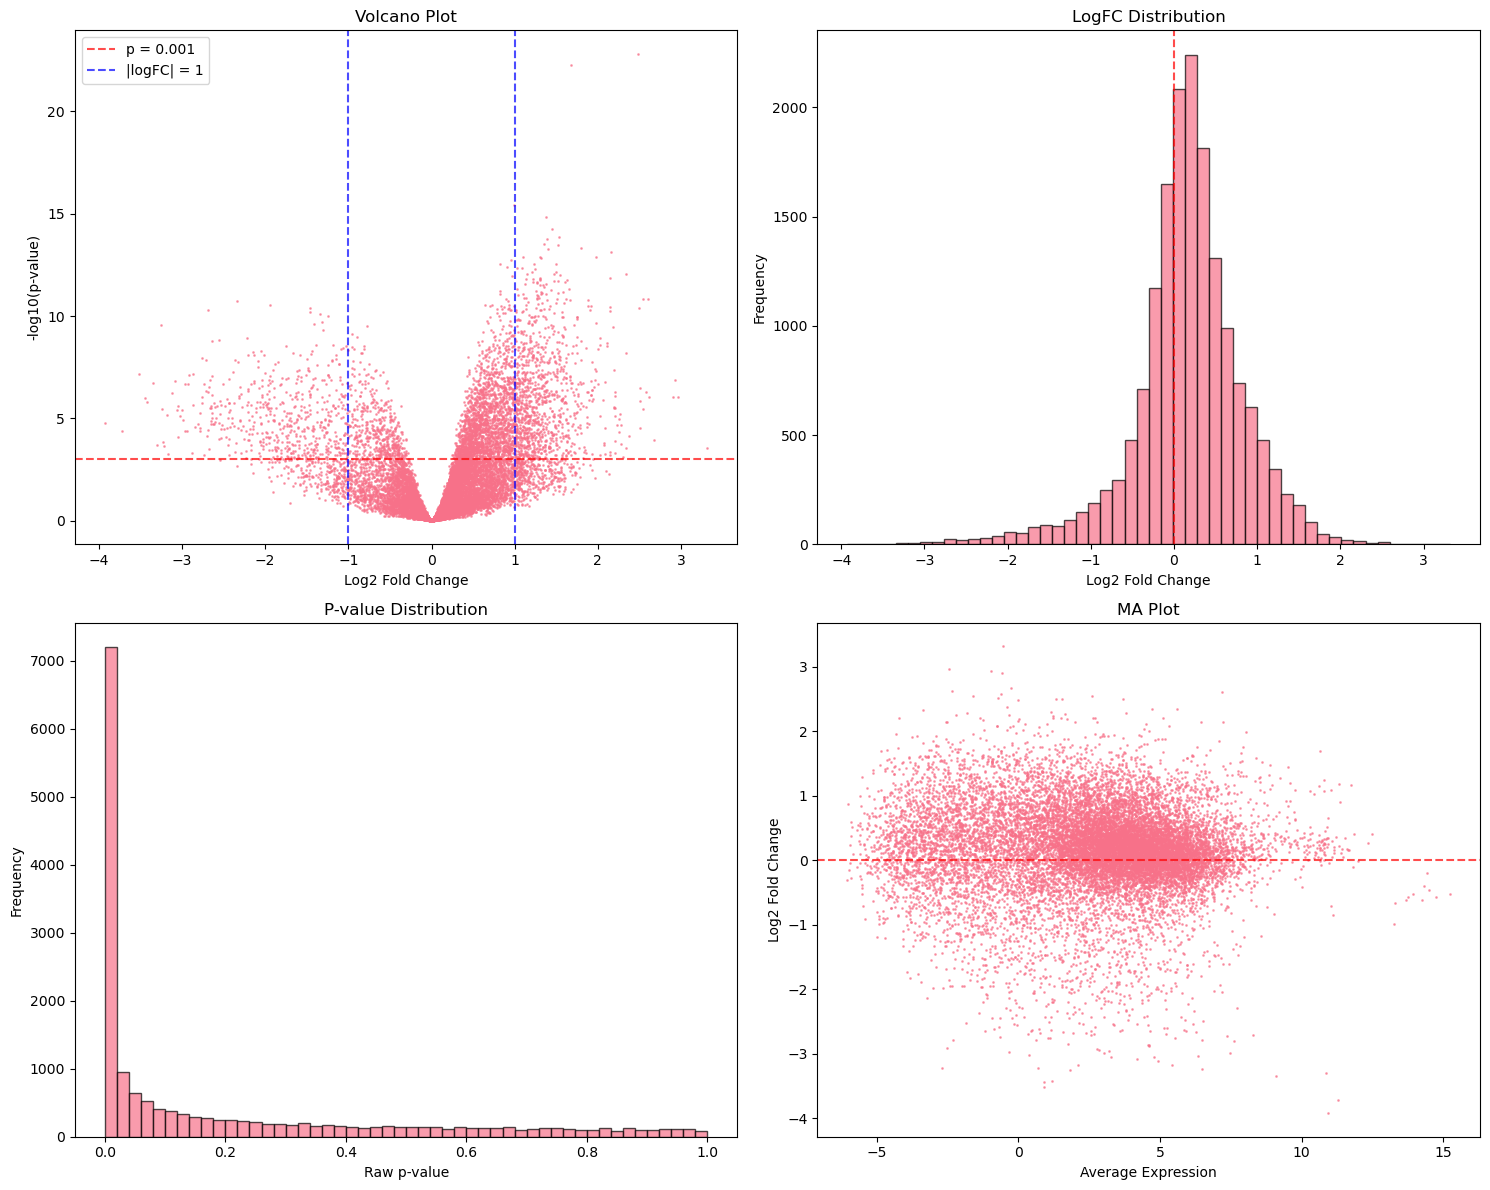

Saving Results Summary
Detailed summary saved to: /Users/dyuth/Desktop/Data Science Project/dea/normal_dea_summary_Prostate_PRAD.csv
Top genes saved to: /Users/dyuth/Desktop/Data Science Project/dea/normal_top_genes_Prostate_PRAD.csv

Normal DEA Analysis Complete for Prostate (PRAD)
Files saved to: /Users/dyuth/Desktop/Data Science Project/dea


In [54]:

# NORMAL DEA RESULTS SUMMAR

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


hr(f"Normal DEA Results Summary - {CANCER_TYPE} ({ANALYSIS_PARAMS['target_organ']})")


dea_dir = Path("/Users/dyuth/Desktop/Data Science Project/dea")
complete_results_file = dea_dir / f"limma_DEA_results_complete_{ANALYSIS_PARAMS['target_organ']}_normal_{CANCER_TYPE}.csv"

if not complete_results_file.exists():
    print(f"Complete results file not found: {complete_results_file}")
    print("Available files in dea directory:")
    for file in dea_dir.glob("*normal*CLEAN*"):
        print(f"  - {file.name}")
else:

    dea_complete = pd.read_csv(complete_results_file, index_col=0)
    print(f"Loaded complete DEA results: {dea_complete.shape}")

    

    
    hr("Significance Threshold Analysis")

 
    p_thresholds = [0.05, 0.01, 0.001, 0.0001, 0.00001]
    logfc_thresholds = [0, 0.5, 1.0, 1.5, 2.0]

  
    summary_data = []

    for p_thresh in p_thresholds:
        for lfc_thresh in logfc_thresholds:
   
            if p_thresh <= 0.001:
                sig_genes = dea_complete[dea_complete['adj.P.Val.Bonf'] <= p_thresh]
            else:
                sig_genes = dea_complete[dea_complete['adj.P.Val.BH'] <= p_thresh]
            
            if lfc_thresh > 0:
                sig_genes = sig_genes[abs(sig_genes['logFC']) >= lfc_thresh]
            
        
            total_sig = len(sig_genes)
            upregulated = (sig_genes['logFC'] > 0).sum()
            downregulated = (sig_genes['logFC'] < 0).sum()
            
            summary_data.append({
                'p_threshold': p_thresh,
                'logFC_threshold': lfc_thresh,
                'correction': 'Bonferroni' if p_thresh <= 0.001 else 'BH',
                'total_significant': total_sig,
                'upregulated': upregulated,
                'downregulated': downregulated,
                'up_percentage': (upregulated / total_sig * 100) if total_sig > 0 else 0,
                'down_percentage': (downregulated / total_sig * 100) if total_sig > 0 else 0
            })

    summary_df = pd.DataFrame(summary_data)


    print("Key significance thresholds:")
    key_thresholds = [
        (0.001, 0, 'Bonferroni'),
        (0.001, 0.5, 'Bonferroni'), 
        (0.001, 1.0, 'Bonferroni'),
        (0.001, 1.5, 'Bonferroni'),
        (0.01, 1.0, 'BH')
    ]

    for p_val, lfc_val, correction in key_thresholds:
        row = summary_df[(summary_df['p_threshold'] == p_val) & 
                        (summary_df['logFC_threshold'] == lfc_val)]
        if not row.empty:
            r = row.iloc[0]
            print(f"  p < {p_val:g} & |logFC| ≥ {lfc_val}: {r['total_significant']:,} genes "
                  f"({r['upregulated']:,} up, {r['downregulated']:,} down)")

    

    
    hr("Expression Distribution Analysis")


    print(f"Total genes analyzed: {len(dea_complete):,}")
    print(f"LogFC range: {dea_complete['logFC'].min():.3f} to {dea_complete['logFC'].max():.3f}")
    print(f"Mean absolute logFC: {abs(dea_complete['logFC']).mean():.3f}")


    bonf_001 = (dea_complete['adj.P.Val.Bonf'] <= 0.001).sum()
    bonf_01 = (dea_complete['adj.P.Val.Bonf'] <= 0.01).sum()
    bh_05 = (dea_complete['adj.P.Val.BH'] <= 0.05).sum()

    print(f"\nOverall significance:")
    print(f"  Bonferroni p ≤ 0.001: {bonf_001:,} genes ({bonf_001/len(dea_complete)*100:.1f}%)")
    print(f"  Bonferroni p ≤ 0.01: {bonf_01:,} genes ({bonf_01/len(dea_complete)*100:.1f}%)")
    print(f"  BH p ≤ 0.05: {bh_05:,} genes ({bh_05/len(dea_complete)*100:.1f}%)")


    sig_genes_001 = dea_complete[dea_complete['adj.P.Val.Bonf'] <= 0.001]
    if len(sig_genes_001) > 0:
        up_001 = (sig_genes_001['logFC'] > 0).sum()
        down_001 = (sig_genes_001['logFC'] < 0).sum()
        bias_ratio = up_001 / (down_001 + 1)  
        
        print(f"\nDirection bias (p ≤ 0.001):")
        print(f"  Upregulated: {up_001:,} genes ({up_001/len(sig_genes_001)*100:.1f}%)")
        print(f"  Downregulated: {down_001:,} genes ({down_001/len(sig_genes_001)*100:.1f}%)")
        print(f"  Up/Down ratio: {bias_ratio:.1f}:1")
        
        if bias_ratio > 10:
            print("HIGH BIAS")

    

    
    hr("Top Differentially Expressed Genes")


    top_up = dea_complete.nlargest(10, 'logFC')
    print("Top 10 upregulated genes:")
    for i, (gene, row) in enumerate(top_up.iterrows(), 1):
        print(f"  {i:2d}. {gene:15s} | logFC: {row['logFC']:6.3f} | "
              f"Bonf p: {row['adj.P.Val.Bonf']:.2e}")

  
    top_down = dea_complete.nsmallest(10, 'logFC')
    print(f"\nTop 10 downregulated genes:")
    for i, (gene, row) in enumerate(top_down.iterrows(), 1):
        print(f"  {i:2d}. {gene:15s} | logFC: {row['logFC']:6.3f} | "
              f"Bonf p: {row['adj.P.Val.Bonf']:.2e}")


    top_sig = dea_complete.nsmallest(10, 'adj.P.Val.Bonf')
    print(f"\nTop 10 most significant genes:")
    for i, (gene, row) in enumerate(top_sig.iterrows(), 1):
        print(f"  {i:2d}. {gene:15s} | logFC: {row['logFC']:6.3f} | "
              f"Bonf p: {row['adj.P.Val.Bonf']:.2e}")

    

    
    hr("DEA Results Visualization")

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Volcano plot
    axes[0,0].scatter(dea_complete['logFC'], -np.log10(dea_complete['P.Value.Raw']), 
                     alpha=0.6, s=1)
    axes[0,0].axhline(-np.log10(0.001), color='red', linestyle='--', alpha=0.7, label='p = 0.001')
    axes[0,0].axvline(1, color='blue', linestyle='--', alpha=0.7, label='|logFC| = 1')
    axes[0,0].axvline(-1, color='blue', linestyle='--', alpha=0.7)
    axes[0,0].set_xlabel('Log2 Fold Change')
    axes[0,0].set_ylabel('-log10(p-value)')
    axes[0,0].set_title('Volcano Plot')
    axes[0,0].legend()

    # LogFC distribution
    axes[0,1].hist(dea_complete['logFC'], bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[0,1].set_xlabel('Log2 Fold Change')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('LogFC Distribution')

    # P-value histogram
    axes[1,0].hist(dea_complete['P.Value.Raw'], bins=50, alpha=0.7, edgecolor='black')
    axes[1,0].set_xlabel('Raw p-value')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('P-value Distribution')

    # MA plot
    A = dea_complete['AveExpr']
    M = dea_complete['logFC']
    axes[1,1].scatter(A, M, alpha=0.6, s=1)
    axes[1,1].axhline(0, color='red', linestyle='--', alpha=0.7)
    axes[1,1].set_xlabel('Average Expression')
    axes[1,1].set_ylabel('Log2 Fold Change')
    axes[1,1].set_title('MA Plot')

    plt.tight_layout()
    plt.show()

    

    
    hr("Saving Results Summary")


    summary_path = dea_dir / f"normal_dea_summary_{ANALYSIS_PARAMS['target_organ']}_{CANCER_TYPE}.csv"
    summary_df.to_csv(summary_path, index=False)
    print(f"Detailed summary saved to: {summary_path}")


    top_genes_path = dea_dir / f"normal_top_genes_{ANALYSIS_PARAMS['target_organ']}_{CANCER_TYPE}.csv"
    top_genes_combined = pd.concat([
        top_up.assign(category='top_upregulated'),
        top_down.assign(category='top_downregulated'), 
        top_sig.assign(category='most_significant')
    ])
    top_genes_combined.to_csv(top_genes_path, index=True)
    print(f"Top genes saved to: {top_genes_path}")

    print(f"\nNormal DEA Analysis Complete for {ANALYSIS_PARAMS['target_organ']} ({CANCER_TYPE})")
    print(f"Files saved to: {dea_dir}")

Cancer DEA Results Summary - PRAD
Loaded complete PRAD DEA results: (18599, 19)
Significance Threshold Analysis
Key significance thresholds:
  p < 0.001 & |logFC| ≥ 0: 7,413 genes (6,701 up, 712 down)
  p < 0.001 & |logFC| ≥ 0.5: 6,207 genes (5,971 up, 236 down)
  p < 0.001 & |logFC| ≥ 1.0: 4,126 genes (4,093 up, 33 down)
  p < 0.001 & |logFC| ≥ 1.5: 2,786 genes (2,781 up, 5 down)
  p < 0.01 & |logFC| ≥ 1.0: 4,679 genes (4,578 up, 101 down)
  p < 0.05 & |logFC| ≥ 1.0: 4,685 genes (4,579 up, 106 down)
Expression Distribution Analysis
Total genes analyzed: 18,599
LogFC range: -2.670 to 4.680
Mean absolute logFC: 0.700

Overall significance:
  Bonferroni p ≤ 0.001: 7,413 genes (39.9%)
  Bonferroni p ≤ 0.01: 8,089 genes (43.5%)
  BH p ≤ 0.05: 13,614 genes (73.2%)

Direction bias (p ≤ 0.001):
  Upregulated: 6,701 genes (90.4%)
  Downregulated: 712 genes (9.6%)
  Up/Down ratio: 9.4:1
DIRECTIONAL BIAS DETECTED

Comparison with Normal tissue DEA:
  Cancer: 6,701 up, 712 down
  Normal: 476 up, 

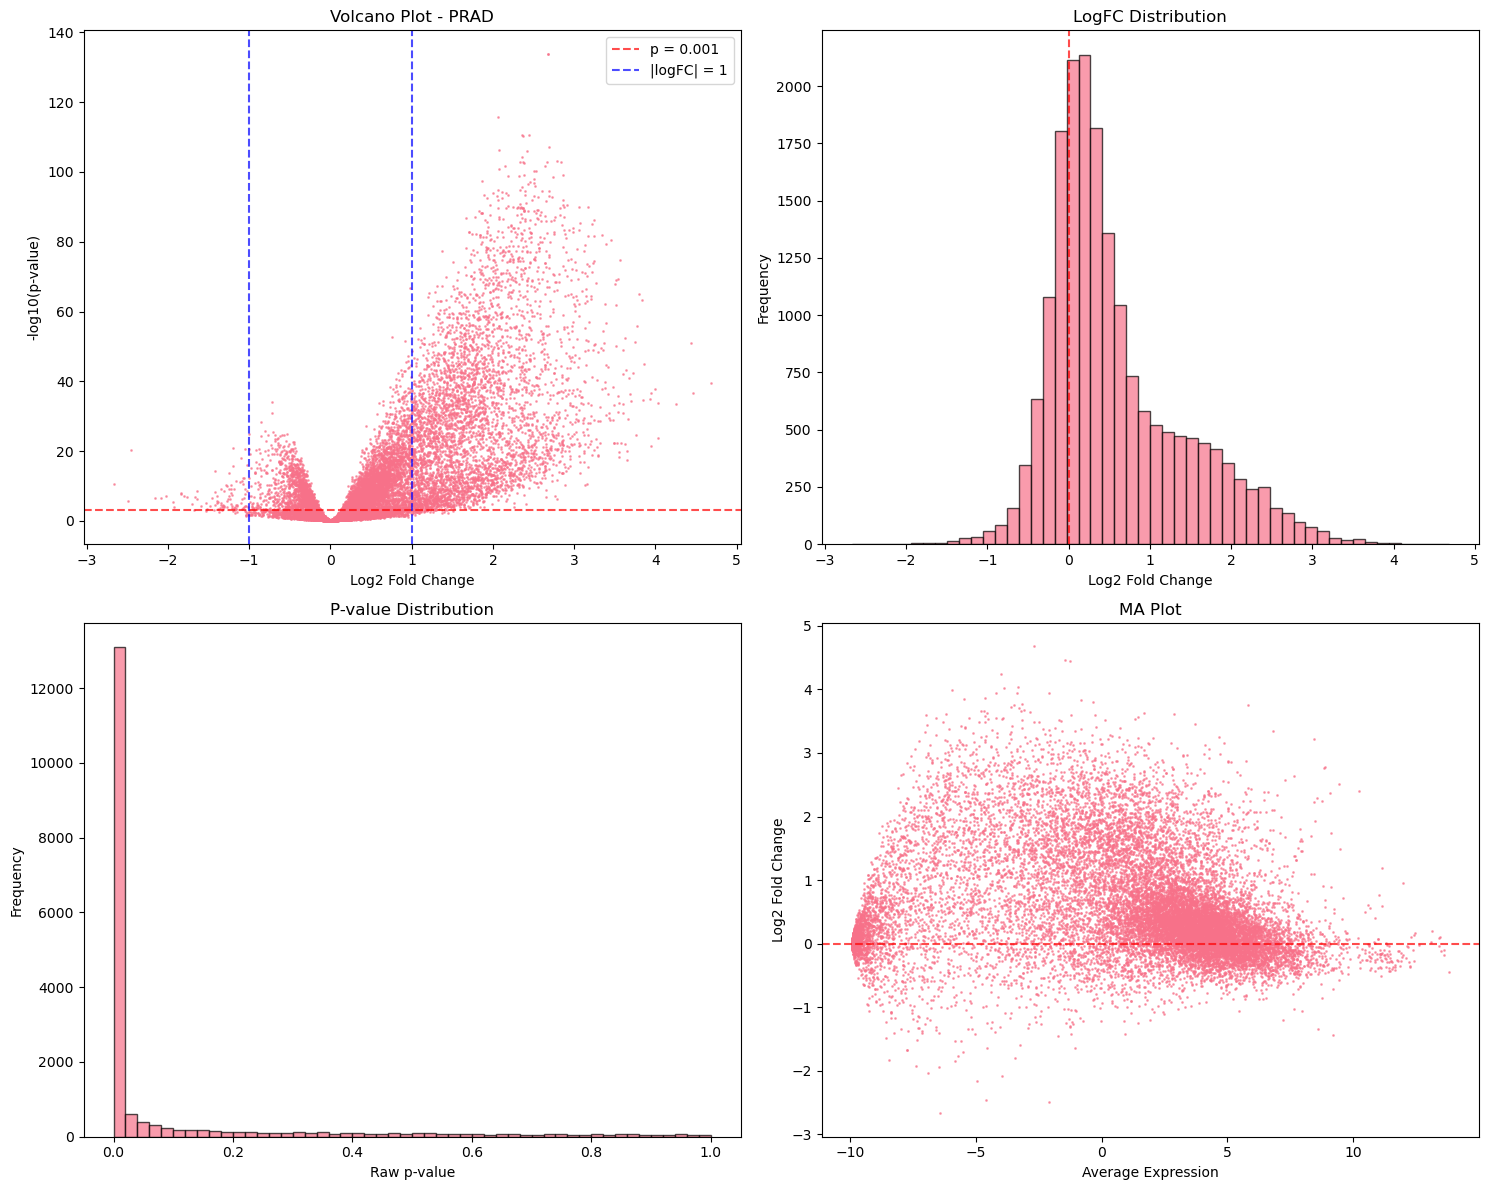

Saving Results Summary
Detailed summary saved to: /Users/dyuth/Desktop/Data Science Project/dea/cancer_dea_summary_PRAD.csv
Top genes saved to: /Users/dyuth/Desktop/Data Science Project/dea/cancer_top_genes_PRAD.csv

PRAD DEA Analysis Complete
Files saved to: /Users/dyuth/Desktop/Data Science Project/dea


In [55]:

# CANCER DEA RESULTS SUMMARY

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path



hr(f"Cancer DEA Results Summary - {CANCER_TYPE}")

dea_dir = Path("/Users/dyuth/Desktop/Data Science Project/dea")
complete_results_file = dea_dir / f"limma_DEA_results_complete_{CANCER_TYPE}.csv"

if not complete_results_file.exists():
    alternative_files = [
        dea_dir / f"limma_DEA_results_complete_{CANCER_TYPE}_CLEAN.csv",
        dea_dir / f"limma_DEA_{CANCER_TYPE}_complete_results.csv",
        dea_dir / f"limma_DEA_complete_{CANCER_TYPE}.csv"
    ]
    
    for alt_file in alternative_files:
        if alt_file.exists():
            complete_results_file = alt_file
            break

if not complete_results_file.exists():
    print(f"Complete {CANCER_TYPE} DEA results file not found")
    print("Looking for files matching patterns:")
    for pattern in ["*complete*", f"*{CANCER_TYPE}*", "*cancer*"]:
        matching_files = list(dea_dir.glob(pattern))
        if matching_files:
            print(f"  Pattern '{pattern}': {[f.name for f in matching_files[:5]]}")
    
    print(f"\nPlease run the {CANCER_TYPE} DEA analysis first or check file naming.")
else:

    dea_complete = pd.read_csv(complete_results_file, index_col=0)
    print(f"Loaded complete {CANCER_TYPE} DEA results: {dea_complete.shape}")

    

    
    hr("Significance Threshold Analysis")


    p_thresholds = [0.05, 0.01, 0.001, 0.0001, 0.00001]
    logfc_thresholds = [0, 0.5, 1.0, 1.5, 2.0]


    summary_data = []

    for p_thresh in p_thresholds:
        for lfc_thresh in logfc_thresholds:
     
            if p_thresh <= 0.001:
                sig_genes = dea_complete[dea_complete['adj.P.Val.Bonf'] <= p_thresh]
            else:
                sig_genes = dea_complete[dea_complete['adj.P.Val.BH'] <= p_thresh]
            
            if lfc_thresh > 0:
                sig_genes = sig_genes[abs(sig_genes['logFC']) >= lfc_thresh]
            
   
            total_sig = len(sig_genes)
            upregulated = (sig_genes['logFC'] > 0).sum()
            downregulated = (sig_genes['logFC'] < 0).sum()
            
            summary_data.append({
                'p_threshold': p_thresh,
                'logFC_threshold': lfc_thresh,
                'correction': 'Bonferroni' if p_thresh <= 0.001 else 'BH',
                'total_significant': total_sig,
                'upregulated': upregulated,
                'downregulated': downregulated,
                'up_percentage': (upregulated / total_sig * 100) if total_sig > 0 else 0,
                'down_percentage': (downregulated / total_sig * 100) if total_sig > 0 else 0
            })

    summary_df = pd.DataFrame(summary_data)


    print("Key significance thresholds:")
    key_thresholds = [
        (0.001, 0, 'Bonferroni'),
        (0.001, 0.5, 'Bonferroni'), 
        (0.001, 1.0, 'Bonferroni'),
        (0.001, 1.5, 'Bonferroni'),
        (0.01, 1.0, 'BH'),
        (0.05, 1.0, 'BH')
    ]

    for p_val, lfc_val, correction in key_thresholds:
        row = summary_df[(summary_df['p_threshold'] == p_val) & 
                        (summary_df['logFC_threshold'] == lfc_val)]
        if not row.empty:
            r = row.iloc[0]
            print(f"  p < {p_val:g} & |logFC| ≥ {lfc_val}: {r['total_significant']:,} genes "
                  f"({r['upregulated']:,} up, {r['downregulated']:,} down)")

    
 
    
    hr("Expression Distribution Analysis")


    print(f"Total genes analyzed: {len(dea_complete):,}")
    print(f"LogFC range: {dea_complete['logFC'].min():.3f} to {dea_complete['logFC'].max():.3f}")
    print(f"Mean absolute logFC: {abs(dea_complete['logFC']).mean():.3f}")


    bonf_001 = (dea_complete['adj.P.Val.Bonf'] <= 0.001).sum()
    bonf_01 = (dea_complete['adj.P.Val.Bonf'] <= 0.01).sum()
    bh_05 = (dea_complete['adj.P.Val.BH'] <= 0.05).sum()

    print(f"\nOverall significance:")
    print(f"  Bonferroni p ≤ 0.001: {bonf_001:,} genes ({bonf_001/len(dea_complete)*100:.1f}%)")
    print(f"  Bonferroni p ≤ 0.01: {bonf_01:,} genes ({bonf_01/len(dea_complete)*100:.1f}%)")
    print(f"  BH p ≤ 0.05: {bh_05:,} genes ({bh_05/len(dea_complete)*100:.1f}%)")


    sig_genes_001 = dea_complete[dea_complete['adj.P.Val.Bonf'] <= 0.001]
    if len(sig_genes_001) > 0:
        up_001 = (sig_genes_001['logFC'] > 0).sum()
        down_001 = (sig_genes_001['logFC'] < 0).sum()
        bias_ratio = up_001 / (down_001 + 1)  
        
        print(f"\nDirection bias (p ≤ 0.001):")
        print(f"  Upregulated: {up_001:,} genes ({up_001/len(sig_genes_001)*100:.1f}%)")
        print(f"  Downregulated: {down_001:,} genes ({down_001/len(sig_genes_001)*100:.1f}%)")
        print(f"  Up/Down ratio: {bias_ratio:.1f}:1")
        
        if bias_ratio > 5:
            print("DIRECTIONAL BIAS DETECTED")
        if bias_ratio > 10:
            print("HIGH BIAS")

    normal_results_file = dea_dir / f"limma_DEA_results_complete_{ANALYSIS_PARAMS['target_organ']}_normal_{CANCER_TYPE}.csv"
    if normal_results_file.exists():
        normal_dea = pd.read_csv(normal_results_file, index_col=0)
        normal_sig_001 = normal_dea[normal_dea['adj.P.Val.Bonf'] <= 0.001]
        normal_up = (normal_sig_001['logFC'] > 0).sum()
        normal_down = (normal_sig_001['logFC'] < 0).sum()
        
        print(f"\nComparison with Normal tissue DEA:")
        print(f"  Cancer: {up_001:,} up, {down_001:,} down")  
        print(f"  Normal: {normal_up:,} up, {normal_down:,} down")
        
        if normal_up == 0 or normal_down == 0:
            print(f"Normal tissue shows severe bias - batch effects likely present")

    
    
    hr("Top Differentially Expressed Genes")


    top_up = dea_complete.nlargest(10, 'logFC')
    print("Top 10 upregulated genes (High vs Low MIR100HG):")
    for i, (gene, row) in enumerate(top_up.iterrows(), 1):
        print(f"  {i:2d}. {gene:15s} | logFC: {row['logFC']:6.3f} | "
              f"Bonf p: {row['adj.P.Val.Bonf']:.2e}")

  
    top_down = dea_complete.nsmallest(10, 'logFC')
    print(f"\nTop 10 downregulated genes (High vs Low MIR100HG):")
    for i, (gene, row) in enumerate(top_down.iterrows(), 1):
        print(f"  {i:2d}. {gene:15s} | logFC: {row['logFC']:6.3f} | "
              f"Bonf p: {row['adj.P.Val.Bonf']:.2e}")


    top_sig = dea_complete.nsmallest(10, 'adj.P.Val.Bonf')
    print(f"\nTop 10 most significant genes:")
    for i, (gene, row) in enumerate(top_sig.iterrows(), 1):
        print(f"  {i:2d}. {gene:15s} | logFC: {row['logFC']:6.3f} | "
              f"Bonf p: {row['adj.P.Val.Bonf']:.2e}")


    if 'MIR100HG' in dea_complete.index:
        mir_row = dea_complete.loc['MIR100HG']
        print(f"\nMIR100HG itself:")
        print(f"  logFC: {mir_row['logFC']:.3f} | Bonf p: {mir_row['adj.P.Val.Bonf']:.2e}")
        if mir_row['adj.P.Val.Bonf'] <= 0.001:
            print("MIR100HG is significantly differentially expressed (expected)")
        else:
            print("MIR100HG is not significantly DE - check stratification")

    
    # # BIOLOGICAL PATHWAY CONTEXT
    
    # hr("Biological Context Analysis")


    # cancer_genes = ['TP53', 'KRAS', 'PIK3CA', 'APC', 'EGFR', 'MYC', 'PTEN', 'RB1', 'BRCA1', 'BRCA2']
    # pancreas_genes = ['PDAC1', 'KLF4', 'GATA4', 'GATA6', 'FOXA2', 'PDX1'] if CANCER_TYPE == 'PAAD' else []
    
    # print("Cancer-related genes in results:")
    # for gene in cancer_genes + pancreas_genes:
    #     if gene in dea_complete.index:
    #         row = dea_complete.loc[gene]
    #         significance = "***" if row['adj.P.Val.Bonf'] <= 0.001 else "**" if row['adj.P.Val.Bonf'] <= 0.01 else "*" if row['adj.P.Val.BH'] <= 0.05 else ""
    #         print(f"  {gene:10s}: logFC {row['logFC']:6.3f} | p {row['adj.P.Val.Bonf']:.2e} {significance}")

    

    
    hr("DEA Results Visualization")

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Volcano plot
    axes[0,0].scatter(dea_complete['logFC'], -np.log10(dea_complete['P.Value.Raw']), 
                     alpha=0.6, s=1)
    axes[0,0].axhline(-np.log10(0.001), color='red', linestyle='--', alpha=0.7, label='p = 0.001')
    axes[0,0].axvline(1, color='blue', linestyle='--', alpha=0.7, label='|logFC| = 1')
    axes[0,0].axvline(-1, color='blue', linestyle='--', alpha=0.7)
    axes[0,0].set_xlabel('Log2 Fold Change')
    axes[0,0].set_ylabel('-log10(p-value)')
    axes[0,0].set_title(f'Volcano Plot - {CANCER_TYPE}')
    axes[0,0].legend()

    # LogFC distribution
    axes[0,1].hist(dea_complete['logFC'], bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[0,1].set_xlabel('Log2 Fold Change')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('LogFC Distribution')

    # P-value histogram
    axes[1,0].hist(dea_complete['P.Value.Raw'], bins=50, alpha=0.7, edgecolor='black')
    axes[1,0].set_xlabel('Raw p-value')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('P-value Distribution')

    # MA plot
    A = dea_complete['AveExpr']
    M = dea_complete['logFC']
    axes[1,1].scatter(A, M, alpha=0.6, s=1)
    axes[1,1].axhline(0, color='red', linestyle='--', alpha=0.7)
    axes[1,1].set_xlabel('Average Expression')
    axes[1,1].set_ylabel('Log2 Fold Change')
    axes[1,1].set_title('MA Plot')

    plt.tight_layout()
    plt.show()

    
    hr("Saving Results Summary")


    summary_path = dea_dir / f"cancer_dea_summary_{CANCER_TYPE}.csv"
    summary_df.to_csv(summary_path, index=False)
    print(f"Detailed summary saved to: {summary_path}")


    top_genes_path = dea_dir / f"cancer_top_genes_{CANCER_TYPE}.csv"
    top_genes_combined = pd.concat([
        top_up.assign(category='top_upregulated'),
        top_down.assign(category='top_downregulated'), 
        top_sig.assign(category='most_significant')
    ])
    top_genes_combined.to_csv(top_genes_path, index=True)
    print(f"Top genes saved to: {top_genes_path}")

    print(f"\n{CANCER_TYPE} DEA Analysis Complete")
    print(f"Files saved to: {dea_dir}")



In [56]:

# MIR100HG Expression AnalysiS

import pandas as pd
import numpy as np
from pathlib import Path


def extract_tf_regulators(edges_df):
   mir100hg_regulators = edges_df[
       edges_df['targetGene'].str.contains('MIR100HG', na=False)
   ].copy()
   

   mir100hg_regulators = mir100hg_regulators[
       mir100hg_regulators['TranscriptionFactor'].notna() & 
       (mir100hg_regulators['TranscriptionFactor'] != 'na')
   ]
   
   return mir100hg_regulators['TranscriptionFactor'].unique().tolist()

def classify_coexpression(row, sig_threshold=0.001, logfc_threshold=0.5):

   bonf_col = 'adj.P.Val.Bonf'
   if bonf_col not in row:
       bonf_col = next((col for col in row.index if 'Bonf' in col), None)
   

   is_significant = False
   if bonf_col and pd.notna(row[bonf_col]):
       is_significant = row[bonf_col] <= sig_threshold
   

   abs_logfc = abs(row['logFC'])
   meets_fc_threshold = abs_logfc >= logfc_threshold
   
   if is_significant and meets_fc_threshold:
       if row['logFC'] > 0:
           return 'Positively Co-expressed'
       elif row['logFC'] < 0:
           return 'Negatively Co-expressed'
   else:
       return 'Not Significant'


hr(f"MIR100HG Expression Analysis - {CANCER_TYPE}")

dea_dir = Path(PATHS["dea_dir"])
output_dir = Path(PATHS["output_dir"])


target_organ = ANALYSIS_PARAMS['target_organ']
normal_complete_file = dea_dir / f"limma_DEA_results_complete_{target_organ}_normal_{CANCER_TYPE}.csv"
cancer_complete_file = dea_dir / f"limma_DEA_results_complete_{CANCER_TYPE}.csv"


edges_path = Path(PATHS["gene_edges"])

print(f"Looking for COMPLETE DEA results files:")
print(f"  Normal DEA: {normal_complete_file}")
print(f"  Cancer DEA: {cancer_complete_file}")
print(f"  Gene edges: {edges_path}")


print(f"\nLoading COMPLETE DEA results...")
datasets_loaded = {}


if normal_complete_file.exists():
   dea_normal = pd.read_csv(normal_complete_file, index_col=0)
   datasets_loaded['Normal'] = dea_normal
   print(f"Loaded normal DEA (complete): {len(dea_normal):,} genes")
else:
   print(f"Normal complete DEA file not found: {normal_complete_file}")
  
   alt_files = list(dea_dir.glob(f"*{target_organ}*normal*{CANCER_TYPE}*complete*.csv"))
   if alt_files:
       print(f"Found alternative files: {[f.name for f in alt_files]}")
       dea_normal = pd.read_csv(alt_files[0], index_col=0)
       datasets_loaded['Normal'] = dea_normal
       print(f"Using: {alt_files[0].name} ({len(dea_normal):,} genes)")


if cancer_complete_file.exists():
   dea_cancer = pd.read_csv(cancer_complete_file, index_col=0)
   datasets_loaded[CANCER_TYPE] = dea_cancer
   print(f"Loaded {CANCER_TYPE} DEA (complete): {len(dea_cancer):,} genes")
else:
   print(f"{CANCER_TYPE} complete DEA file not found: {cancer_complete_file}")

   cancer_files = list(dea_dir.glob(f"*cancer*{CANCER_TYPE}*complete*.csv"))
   if cancer_files:
       print(f"Found cancer files: {[f.name for f in cancer_files]}")
       dea_cancer = pd.read_csv(cancer_files[0], index_col=0)
       datasets_loaded[CANCER_TYPE] = dea_cancer
       print(f" Using: {cancer_files[0].name} ({len(dea_cancer):,} genes)")


if edges_path.exists():
   edges = pd.read_csv(edges_path, sep='\t')
   print(f" Loaded gene edges: {len(edges):,} interactions")
else:
   print(f" Gene edges file not found: {edges_path}")
   edges = None

if not datasets_loaded:
   print(" No complete DEA files could be loaded. Please check file paths.")
   raise FileNotFoundError("Required complete DEA files not found")



hr("miR100HG Co-Expression Analysis - Complete Gene Set")


if edges is not None:
   tf_regulators = extract_tf_regulators(edges)
   print(f"TF regulators found: {len(tf_regulators)}")
else:
   tf_regulators = []
   print("TF regulators: 0 ")


signatures = {}
coexpression_data = []
coexpression_summary = {}

for dataset_name, dea_data in datasets_loaded.items():
   print(f"\nProcessing {dataset_name} dataset...")
   print(f"  Total genes in dataset: {len(dea_data):,}")
   

   mir100hg_rows = pd.DataFrame()


   search_patterns = ['MIR100HG', 'mir100hg', 'MIR-100HG', 'mir-100hg', 'MIR100-HG', 'mir100-hg']

   for pattern in search_patterns:

       if 'SYMBOL' in dea_data.columns:
           matches = dea_data[dea_data['SYMBOL'].str.contains(pattern, na=False, case=False)]
           if len(matches) > 0:
               mir100hg_rows = matches
               print(f"  Found miR100HG using pattern '{pattern}' in SYMBOL column")
               break
       

       matches = dea_data[dea_data.index.str.contains(pattern, na=False, case=False)]
       if len(matches) > 0:
           mir100hg_rows = matches
           print(f"  Found miR100HG using pattern '{pattern}' in index")
           break

   if len(mir100hg_rows) > 0:
       mir100hg_data = mir100hg_rows.iloc[0]
       print(f"MIR100HG logFC: {mir100hg_data['logFC']:.3f} (p={mir100hg_data.get('adj.P.Val.Bonf', 'N/A'):.2e})")
   else:
       print(f"MIR100HG not found in {dataset_name} data with any search pattern")
       mir100hg_data = None
   

   if 'SYMBOL' in dea_data.columns:
       tf_data = dea_data[dea_data['SYMBOL'].isin(tf_regulators)]
   else:
       tf_data = dea_data[dea_data.index.isin(tf_regulators)]
   print(f"  TF regulators found: {len(tf_data)}")
   

   exclude_genes = set(tf_regulators)
   if mir100hg_data is not None:
       mir100hg_symbol = mir100hg_data.get('SYMBOL', 'MIR100HG')
       exclude_genes.add(mir100hg_symbol)
   

   if 'SYMBOL' in dea_data.columns:
       coexpr_genes = dea_data[~dea_data['SYMBOL'].isin(exclude_genes)].copy()
   else:
       coexpr_genes = dea_data[~dea_data.index.isin(exclude_genes)].copy()
   
   print(f"  Genes for co-expression analysis: {len(coexpr_genes):,}")
   

   coexpr_genes['coexpression_category'] = coexpr_genes.apply(classify_coexpression, axis=1)
   

   coexpr_counts = coexpr_genes['coexpression_category'].value_counts()
   print(f"  Co-expression summary:")
   for category, count in coexpr_counts.items():
       print(f"    • {category}: {count:,}")
   

   coexpression_summary[dataset_name] = coexpr_counts.to_dict()
   

   signature_rows = []
   

   for _, row in tf_data.iterrows():
       gene_name = row.get('SYMBOL', row.name)
       coexpression = classify_coexpression(row)
       signature_rows.append({
           'gene_type': 'TF_regulator',
           'gene_name': gene_name,
           'logFC': row['logFC'],
           'adj_pval': row.get('adj.P.Val.Bonf', row.get('adj.P.Val.BH', np.nan)),
           'coexpression_category': coexpression,
           'relationship': 'TF → miR100HG',
           'dataset': dataset_name
       })
   

       mir_coexpression = classify_coexpression(mir100hg_data)
       signature_rows.append({
           'gene_type': 'miRNA_host',
           'gene_name': 'MIR100HG',
           'logFC': mir100hg_data['logFC'],
           'adj_pval': mir100hg_data.get('adj.P.Val.Bonf', mir100hg_data.get('adj.P.Val.BH', np.nan)),
           'coexpression_category': mir_coexpression,
           'relationship': 'miRNA_host_gene',
           'dataset': dataset_name
       })
   

   for _, row in coexpr_genes.iterrows():
       gene_name = row.get('SYMBOL', row.name)
       signature_rows.append({
           'gene_type': 'coexpressed_gene',
           'gene_name': gene_name,
           'logFC': row['logFC'],
           'adj_pval': row.get('adj.P.Val.Bonf', row.get('adj.P.Val.BH', np.nan)),
           'coexpression_category': row['coexpression_category'],
           'relationship': 'Co-expression with miR100HG',
           'dataset': dataset_name
       })
   
   signatures[dataset_name] = pd.DataFrame(signature_rows)
   

   for _, row in coexpr_genes.iterrows():
       gene_name = row.get('SYMBOL', row.name)
       is_significant = row['coexpression_category'] != 'Not Significant'
       coexpression_data.append({
           'SYMBOL': gene_name,
           'logFC': row['logFC'],
           'adj.P.Val.Bonf': row.get('adj.P.Val.Bonf', row.get('adj.P.Val.BH', np.nan)),
           'direction': 'UP' if row['logFC'] > 0 else 'DOWN',
           'significant': is_significant,
           'coexpression_category': row['coexpression_category'],
           'correlation_type': 'Positive correlation' if row['logFC'] > 0 else 'Negative correlation',
           'dataset': dataset_name,
           'abs_logFC': abs(row['logFC'])
       })



hr("Creating Combined Co-Expression Results and Statistics")


if coexpression_data:
   coexpr_combined = pd.DataFrame(coexpression_data)
   print(f"Combined co-expression data: {len(coexpr_combined):,} entries")
   

   print(f"\nCO-EXPRESSION STATISTICS:")
   for dataset in coexpr_combined['dataset'].unique():
       dataset_data = coexpr_combined[coexpr_combined['dataset'] == dataset]
       total_genes = len(dataset_data)
       
       pos_coexpr = len(dataset_data[dataset_data['coexpression_category'] == 'Positively Co-expressed'])
       neg_coexpr = len(dataset_data[dataset_data['coexpression_category'] == 'Negatively Co-expressed'])
       not_sig = len(dataset_data[dataset_data['coexpression_category'] == 'Not Significant'])
       
       print(f"\n{dataset}:")
       print(f"Total genes analyzed: {total_genes:,}")
       print(f"Positively co-expressed with miR100HG: {pos_coexpr:,} ({pos_coexpr/total_genes*100:.1f}%)")
       print(f"Negatively co-expressed with miR100HG: {neg_coexpr:,} ({neg_coexpr/total_genes*100:.1f}%)")
       print(f"Not significantly correlated: {not_sig:,} ({not_sig/total_genes*100:.1f}%)")
       print(f"Total significantly co-expressed: {pos_coexpr + neg_coexpr:,} ({(pos_coexpr + neg_coexpr)/total_genes*100:.1f}%)")
           
else:
   print("No co-expression data available")
   coexpr_combined = pd.DataFrame()


hr("Saving Co-Expression Results")

output_dir.mkdir(exist_ok=True)


for dataset_name, signature_df in signatures.items():
   sig_file = output_dir / f"mir100hg_coexpression_signature_{dataset_name.lower()}.csv"
   signature_df.to_csv(sig_file, index=False)
   print(f" Saved {dataset_name} signature: {sig_file}")


if not coexpr_combined.empty:
   coexpr_file = output_dir / "mir100hg_coexpression_analysis_{CANCER_TYPE}.csv"
   coexpr_combined.to_csv(coexpr_file, index=False)
   print(f"Saved co-expression analysis: {coexpr_file}")


if tf_regulators:
   tf_file = output_dir / "mir100hg_tf_regulators_{CANCER_TYPE}.csv"
   pd.DataFrame({'TF_regulator': tf_regulators}).to_csv(tf_file, index=False)
   print(f" Saved TF regulators: {tf_file}")


summary_data = []
for dataset_name in datasets_loaded.keys():
   if dataset_name in signatures:
       sig_df = signatures[dataset_name]
       
 
       tf_count = len(sig_df[sig_df['gene_type'] == 'TF_regulator'])
       mir_count = len(sig_df[sig_df['gene_type'] == 'miRNA_host'])
       coexpr_count = len(sig_df[sig_df['gene_type'] == 'coexpressed_gene'])
       

       coexpr_genes = sig_df[sig_df['gene_type'] == 'coexpressed_gene']
       pos_coexpr = len(coexpr_genes[coexpr_genes['coexpression_category'] == 'Positively Co-expressed'])
       neg_coexpr = len(coexpr_genes[coexpr_genes['coexpression_category'] == 'Negatively Co-expressed'])
       not_sig = len(coexpr_genes[coexpr_genes['coexpression_category'] == 'Not Significant'])
       
       summary_data.append({
           'Dataset': dataset_name,
           'TF_regulators': tf_count,
           'miR100HG_found': mir_count > 0,
           'Total_genes_analyzed': coexpr_count,
           'Positively_coexpressed': pos_coexpr,
           'Negatively_coexpressed': neg_coexpr,
           'Not_significant': not_sig,
           'Percent_significantly_coexpressed': round((pos_coexpr + neg_coexpr) / coexpr_count * 100, 2) if coexpr_count > 0 else 0
       })

if summary_data:
   summary_df = pd.DataFrame(summary_data)
   summary_file = output_dir / "mir100hg_coexpression_summary_{CANCER_TYPE}.csv"
   summary_df.to_csv(summary_file, index=False)
   print(f" Saved summary statistics: {summary_file}")


if coexpression_summary:
   coexpr_breakdown = []
   for dataset, coexpr_dict in coexpression_summary.items():
       for category, count in coexpr_dict.items():
           coexpr_breakdown.append({
               'Dataset': dataset,
               'Coexpression_Category': category,
               'Gene_Count': count
           })
   
   breakdown_df = pd.DataFrame(coexpr_breakdown)
   breakdown_file = output_dir / "mir100hg_coexpression_breakdown_{CANCER_TYPE}.csv"
   breakdown_df.to_csv(breakdown_file, index=False)
   print(f" Saved co-expression breakdown: {breakdown_file}")


if not coexpr_combined.empty:

   pos_coexpr_genes = coexpr_combined[
       coexpr_combined['coexpression_category'] == 'Positively Co-expressed'
   ]['SYMBOL'].unique()
   

   neg_coexpr_genes = coexpr_combined[
       coexpr_combined['coexpression_category'] == 'Negatively Co-expressed'
   ]['SYMBOL'].unique()
   

   all_sig_coexpr = coexpr_combined[
       coexpr_combined['coexpression_category'] != 'Not Significant'
   ]['SYMBOL'].unique()
   
   if len(pos_coexpr_genes) > 0:
       pos_file = output_dir / "mir100hg_positively_coexpressed_genes_{CANCER_TYPE}.txt"
       with open(pos_file, 'w') as f:
           for gene in pos_coexpr_genes:
               f.write(f"{gene}\n")
       print(f" Saved positively co-expressed genes: {pos_file}")
   
   if len(neg_coexpr_genes) > 0:
       neg_file = output_dir / "mir100hg_negatively_coexpressed_genes_{CANCER_TYPE}.txt"
       with open(neg_file, 'w') as f:
           for gene in neg_coexpr_genes:
               f.write(f"{gene}\n")
       print(f"Saved negatively co-expressed genes: {neg_file}")
   
   if len(all_sig_coexpr) > 0:
       all_file = output_dir / "mir100hg_all_significantly_coexpressed_genes_{CANCER_TYPE}.txt"
       with open(all_file, 'w') as f:
           for gene in all_sig_coexpr:
               f.write(f"{gene}\n")
       print(f" Saved all significantly co-expressed genes: {all_file}")



print(f"Datasets analyzed: {list(datasets_loaded.keys())}")
print(f"TF regulators identified: {len(tf_regulators)}")

if summary_data:
   print(f"\nDETAILED SUMMARY BY DATASET:")
   for data in summary_data:
       dataset = data['Dataset']
       print(f"\n{dataset}:")
       print(f"TF regulators found: {data['TF_regulators']}")
       print(f"miR100HG detected: {'Yes' if data['miR100HG_found'] else 'No'}")
       print(f"Total genes analyzed: {data['Total_genes_analyzed']:,}")
       print(f"Positively co-expressed: {data['Positively_coexpressed']:,} (positive correlation with miR100HG)")
       print(f"Negatively co-expressed: {data['Negatively_coexpressed']:,} (negative correlation with miR100HG)")
       print(f"Not significant: {data['Not_significant']:,}")
       print(f"Percent significantly co-expressed: {data['Percent_significantly_coexpressed']:.2f}%")


globals().update({
   'mir100hg_coexpression_signatures': signatures,
   'mir100hg_coexpression_data': coexpr_combined,
   'mir100hg_tf_regulators_list': tf_regulators,
   'mir100hg_coexpression_summary': coexpression_summary
})



MIR100HG Expression Analysis - PRAD
Looking for COMPLETE DEA results files:
  Normal DEA: /Users/dyuth/Desktop/Data Science Project/dea/limma_DEA_results_complete_Prostate_normal_PRAD.csv
  Cancer DEA: /Users/dyuth/Desktop/Data Science Project/dea/limma_DEA_results_complete_PRAD.csv
  Gene edges: /Users/dyuth/Desktop/Data Science Project/Data/gene_attribute_edges.txt

Loading COMPLETE DEA results...
Loaded normal DEA (complete): 16,792 genes
Loaded PRAD DEA (complete): 18,599 genes
 Loaded gene edges: 1,655,384 interactions
miR100HG Co-Expression Analysis - Complete Gene Set
TF regulators found: 57

Processing Normal dataset...
  Total genes in dataset: 16,792
  Found miR100HG using pattern 'MIR100HG' in SYMBOL column
MIR100HG logFC: 1.676 (p=8.99e-19)
  TF regulators found: 56
  Genes for co-expression analysis: 16,735
  Co-expression summary:
    • Not Significant: 16,191
    • Positively Co-expressed: 472
    • Negatively Co-expressed: 72

Processing PRAD dataset...
  Total genes in

Cancer vs Normal Comparison for PRAD
 Using signature analysis datasets:
  Cancer (PRAD): 18,599 genes
  Normal (Normal): 16,792 genes

Merging datasets for comprehensive comparison...
 Merged dataset: 16,791 common genes

Classifying genes with enhanced signature-aware system...

Integrating miR100HG signature analysis results...
 Found miR100HG variants: ['MIR100HG_x']
 Marked 56 TF regulators
Available columns in merged dataset:
['SYMBOL', 'logFC_cancer', 'adj.P.Val.Bonf_cancer', 'logFC_normal', 'adj.P.Val.Bonf_normal', 'cancer_significant', 'normal_significant', 'cancer_status', 'normal_status', 'combined_pattern', 'gene_category']

1. Raw pattern counts (before strict filtering):
  Raw up-cancer/down-normal genes: 3297
  Raw down-cancer/up-normal genes: 1545
  Raw up-cancer/up-normal genes: 9533
  Significant up-cancer/down-normal (any logFC): 0

2. Known cancer gene examples:
  MYC: Cancer logFC=0.539 (sig=True), Normal logFC=0.466 (sig=False)
  KRAS: Cancer logFC=0.379 (sig=Fals

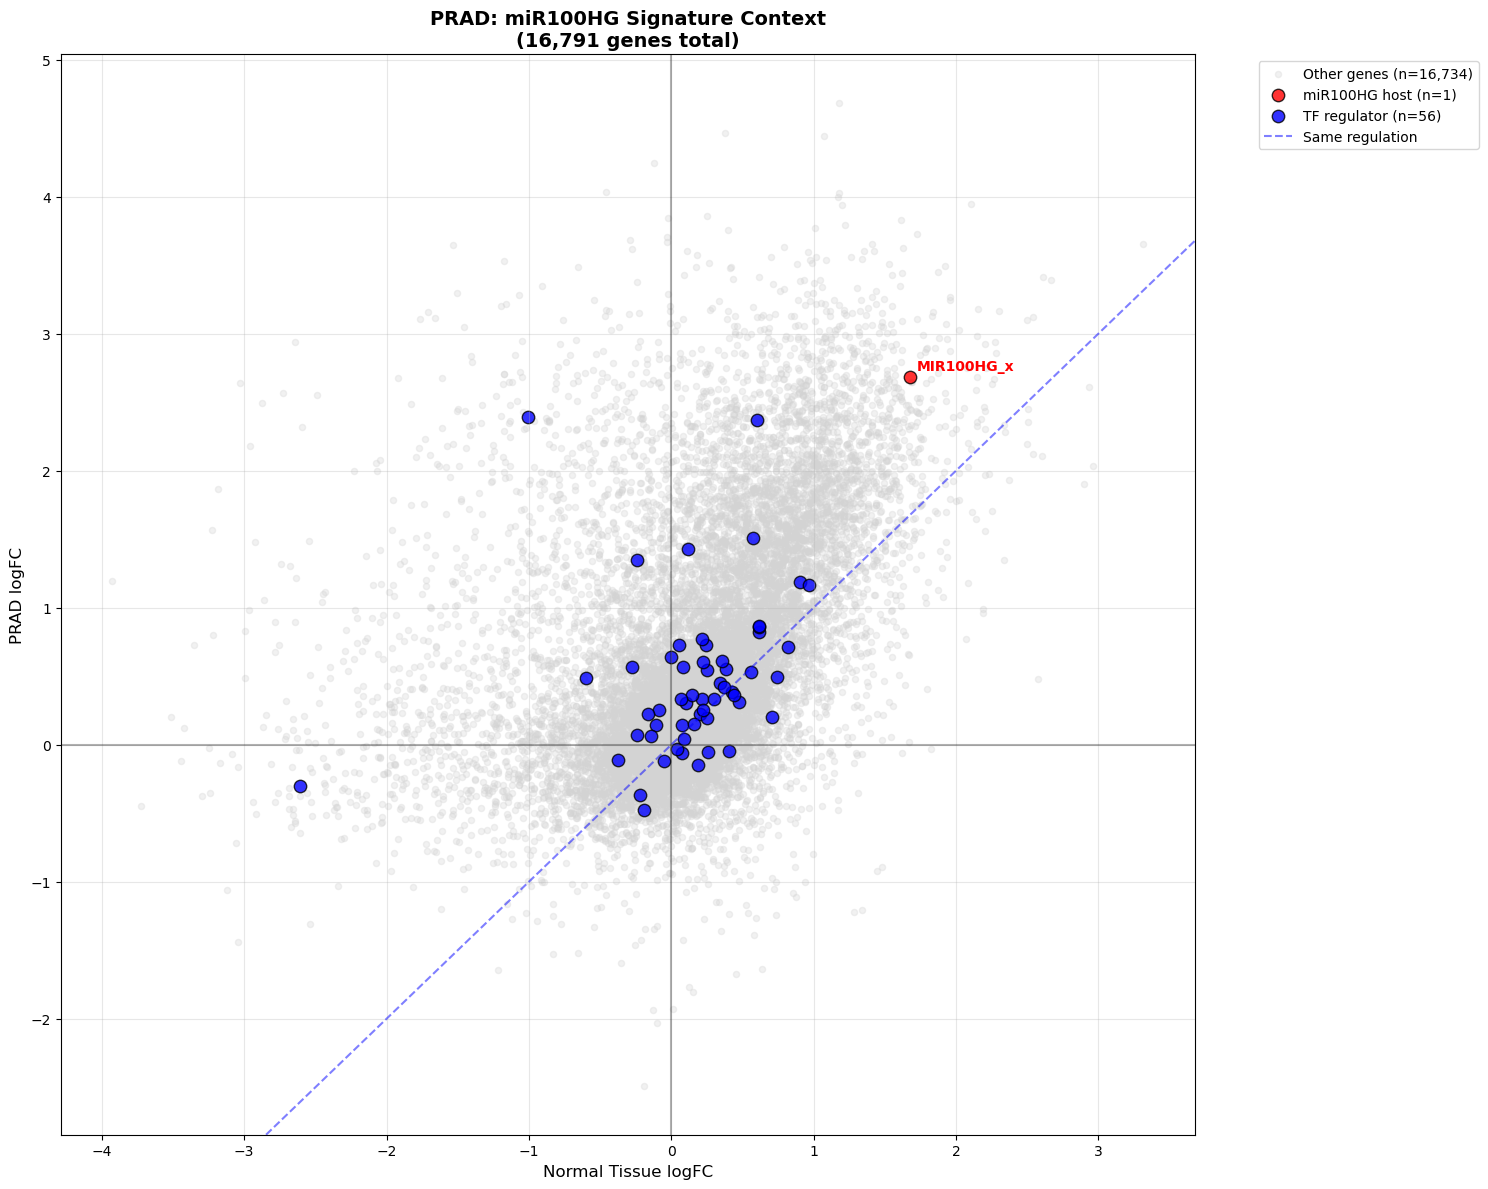

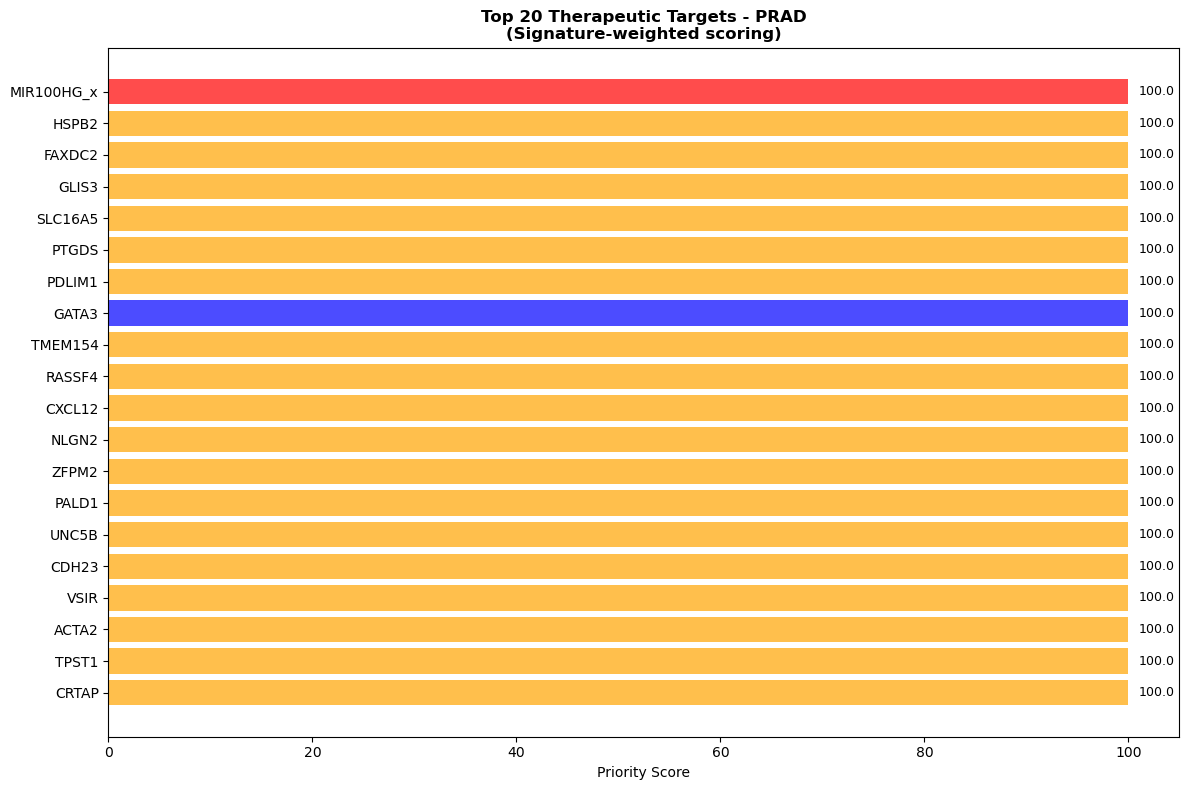

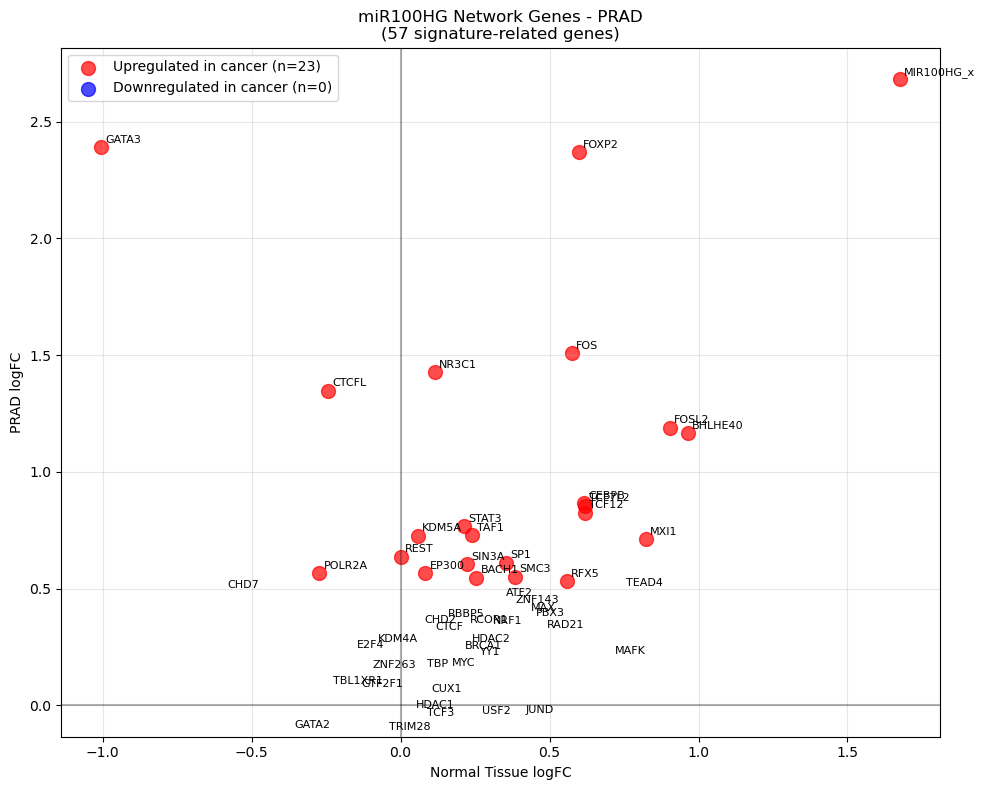


Saving signature-integrated analysis results...
 Saved main results: /Users/dyuth/Desktop/Data Science Project/Data/mir100hg_analysis_prad/signature_integrated_comparison_prad.csv
 Saved PRIME_ONCOGENES: 883 genes
 Saved CANCER_SPECIFIC_ONCOGENES: 6178 genes
 Saved CANCER_SPECIFIC_SUPPRESSORS: 692 genes
 Saved CANCER_DOMINANT_UP: 6178 genes
 Saved CANCER_DOMINANT_DOWN: 692 genes
 Saved CONSISTENT_ACTIVATION: 440 genes
 Saved CONSISTENT_SUPPRESSION: 15 genes
 Saved NORMAL_SPECIFIC_UP: 35 genes
 Saved NORMAL_SPECIFIC_DOWN: 57 genes
 Saved BACKGROUND_GENES: 9374 genes
 Saved signature genes analysis: 57 genes

Creating pathway analysis gene lists...
 Saved pathway analysis gene lists to /Users/dyuth/Desktop/Data Science Project/Data/mir100hg_analysis_prad/pathway_analysis
  Total genes analyzed: 16,791
  miR100HG signature genes: 57 found
  miR100HG host gene: YES

TOP THERAPEUTIC TARGETS (Signature-weighted):
   1. 🔴 MIR100HG_x (Score: 100.0, miR100HG_host)
   2. ⚪ HSPB2 (Score: 100.0, 

In [57]:

# Cancer vs Normal Comparison Analysis 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import os


hr(f"Cancer vs Normal Comparison for {CANCER_TYPE}")


try:
  
    if 'datasets_loaded' in globals() and len(datasets_loaded) >= 2:
        dataset_names = list(datasets_loaded.keys())
        normal_name = [name for name in dataset_names if 'normal' in name.lower()][0]
        cancer_name = [name for name in dataset_names if 'normal' not in name.lower()][0]
        
        cancer_dea_complete = datasets_loaded[cancer_name].copy()
        normal_dea_complete = datasets_loaded[normal_name].copy()
        
        print(f" Using signature analysis datasets:")
        print(f"  Cancer ({cancer_name}): {len(cancer_dea_complete):,} genes")
        print(f"  Normal ({normal_name}): {len(normal_dea_complete):,} genes")
        
    else:
        raise ValueError("Signature analysis datasets not found")
        
except Exception as e:
    print(f"  Could not use signature analysis datasets: {e}")
    print("Loading DEA files directly...")
    

    dea_dir = Path(PATHS["dea_dir"])
    target_organ = ANALYSIS_PARAMS['target_organ']
    

    cancer_file = dea_dir / f"limma_DEA_results_complete_cancer_{CANCER_TYPE}.csv"
    normal_file = dea_dir / f"limma_DEA_results_complete_{target_organ}_normal_{CANCER_TYPE}.csv"
    
    if not cancer_file.exists():
        alt_cancer_files = list(dea_dir.glob(f"*cancer*{CANCER_TYPE}*complete*.csv"))
        if alt_cancer_files:
            cancer_file = alt_cancer_files[0]
            print(f"Using alternative cancer file: {cancer_file.name}")
    
    if not normal_file.exists():
        alt_normal_files = list(dea_dir.glob(f"*{target_organ}*normal*{CANCER_TYPE}*complete*.csv"))
        if alt_normal_files:
            normal_file = alt_normal_files[0]
            print(f"Using alternative normal file: {normal_file.name}")
    
    cancer_dea_complete = pd.read_csv(cancer_file, index_col=0)
    normal_dea_complete = pd.read_csv(normal_file, index_col=0)
    
    print(f" Loaded DEA files:")
    print(f"  Cancer: {len(cancer_dea_complete):,} genes")
    print(f"  Normal: {len(normal_dea_complete):,} genes")


for df_name, df in [('cancer', cancer_dea_complete), ('normal', normal_dea_complete)]:
    if 'SYMBOL' not in df.columns:
        df['SYMBOL'] = df.index
        print(f"Added SYMBOL column to {df_name} dataset")


print(f"\nMerging datasets for comprehensive comparison...")

merged_dea = pd.merge(
    cancer_dea_complete[['SYMBOL', 'logFC', 'adj.P.Val.Bonf']], 
    normal_dea_complete[['SYMBOL', 'logFC', 'adj.P.Val.Bonf']], 
    on='SYMBOL', 
    suffixes=('_cancer', '_normal'),
    how='inner'
)

print(f" Merged dataset: {len(merged_dea):,} common genes")


merged_dea['cancer_significant'] = merged_dea['adj.P.Val.Bonf_cancer'] <= 0.001
merged_dea['normal_significant'] = merged_dea['adj.P.Val.Bonf_normal'] <= 0.001

print("\nClassifying genes with enhanced signature-aware system...")


fc_threshold = 0.5  
sig_threshold = 0.001  

def classify_gene_status_enhanced(logfc, pval, fc_threshold=0.5, sig_threshold=0.001):
  
    is_significant = pval <= sig_threshold
    abs_logfc = abs(logfc)
    
    if is_significant and abs_logfc >= fc_threshold:
        if logfc > 0:
            return 'SIGNIFICANTLY_UP'
        else:
            return 'SIGNIFICANTLY_DOWN'
    elif is_significant and abs_logfc < fc_threshold:
        if logfc > 0:
            return 'WEAKLY_UP'
        else:
            return 'WEAKLY_DOWN'
    else:
        return 'NOT_SIGNIFICANT'


merged_dea['cancer_status'] = merged_dea.apply(
    lambda row: classify_gene_status_enhanced(row['logFC_cancer'], row['adj.P.Val.Bonf_cancer']), axis=1
)

merged_dea['normal_status'] = merged_dea.apply(
    lambda row: classify_gene_status_enhanced(row['logFC_normal'], row['adj.P.Val.Bonf_normal']), axis=1
)


merged_dea['combined_pattern'] = merged_dea['cancer_status'] + '|' + merged_dea['normal_status']


print("\nIntegrating miR100HG signature analysis results...")


merged_dea['gene_category'] = 'Other'


mir_variants = ['MIR100HG', 'MIR100HG_x', 'MIR100HG_y', 'MIR100HG_z']
mir_mask = merged_dea['SYMBOL'].isin(mir_variants)
if mir_mask.any():
    merged_dea.loc[mir_mask, 'gene_category'] = 'miR100HG_host'
    print(f" Found miR100HG variants: {merged_dea.loc[mir_mask, 'SYMBOL'].tolist()}")


if 'mir100hg_tf_regulators_list' in globals():
    tf_mask = merged_dea['SYMBOL'].isin(mir100hg_tf_regulators_list)
    merged_dea.loc[tf_mask, 'gene_category'] = 'TF_regulator'
    print(f" Marked {tf_mask.sum()} TF regulators")


try:
    if 'mir100hg_known_targets' in globals():
        target_mask = merged_dea['SYMBOL'].isin(mir100hg_known_targets)
        merged_dea.loc[target_mask, 'gene_category'] = 'Known_target'
        print(f" Marked {target_mask.sum()} known targets")
except:
    print("No known targets variable found")



print("Available columns in merged dataset:")
print(merged_dea.columns.tolist())


print("\n1. Raw pattern counts (before strict filtering):")
loose_up_down = merged_dea[
    (merged_dea['logFC_cancer'] > 0) & 
    (merged_dea['logFC_normal'] < 0)
]
loose_down_up = merged_dea[
    (merged_dea['logFC_cancer'] < 0) & 
    (merged_dea['logFC_normal'] > 0)
]
loose_up_up = merged_dea[
    (merged_dea['logFC_cancer'] > 0) & 
    (merged_dea['logFC_normal'] > 0)
]

print(f"  Raw up-cancer/down-normal genes: {len(loose_up_down)}")
print(f"  Raw down-cancer/up-normal genes: {len(loose_down_up)}")
print(f"  Raw up-cancer/up-normal genes: {len(loose_up_up)}")


relaxed_up_down = merged_dea[
    (merged_dea['cancer_significant'] == True) &
    (merged_dea['normal_significant'] == True) &
    (merged_dea['logFC_cancer'] > 0) & 
    (merged_dea['logFC_normal'] < 0)
]
print(f"  Significant up-cancer/down-normal (any logFC): {len(relaxed_up_down)}")


print("\n2. Known cancer gene examples:")
known_cancer_genes = ['MYC', 'KRAS', 'TP53', 'EGFR', 'PIK3CA', 'AKT1', 'BRAF', 'CTNNB1']
for gene in known_cancer_genes:
    gene_data = merged_dea[merged_dea['SYMBOL'].str.contains(gene, na=False, case=False)]
    if len(gene_data) > 0:
        row = gene_data.iloc[0]
        cancer_fc = row['logFC_cancer']
        normal_fc = row['logFC_normal']
        cancer_sig = row['cancer_significant']
        normal_sig = row['normal_significant']
        print(f"  {gene}: Cancer logFC={cancer_fc:.3f} (sig={cancer_sig}), Normal logFC={normal_fc:.3f} (sig={normal_sig})")


print("\n3. Threshold impact analysis:")
current_thresh_up_down = merged_dea[
    (merged_dea['cancer_significant'] == True) &
    (merged_dea['normal_significant'] == True) &
    (merged_dea['logFC_cancer'] > 0.5) & 
    (merged_dea['logFC_normal'] < -0.5)
]
print(f"  Current thresholds (p<0.001, |logFC|>0.5): {len(current_thresh_up_down)}")


for fc_thresh in [0.1, 0.3, 0.5, 1.0]:
    test_up_down = merged_dea[
        (merged_dea['cancer_significant'] == True) &
        (merged_dea['normal_significant'] == True) &
        (merged_dea['logFC_cancer'] > fc_thresh) & 
        (merged_dea['logFC_normal'] < -fc_thresh)
    ]
    print(f"  With |logFC| > {fc_thresh}: {len(test_up_down)} genes")


if len(loose_up_down) > 0:
    print("\n4. Top examples of up-cancer/down-normal pattern:")
    examples = loose_up_down.nlargest(10, 'logFC_cancer')[['SYMBOL', 'logFC_cancer', 'logFC_normal', 'cancer_significant', 'normal_significant']]
    print(examples.to_string())
else:
    print("\n4. No up-cancer/down-normal examples found")



print("\nBuilding specific cancer vs normal regulation pattern comparisons...")


merged_dea['cancer_up'] = merged_dea['cancer_status'].str.contains('UP')
merged_dea['cancer_down'] = merged_dea['cancer_status'].str.contains('DOWN') 
merged_dea['cancer_ns'] = merged_dea['cancer_status'] == 'NOT_SIGNIFICANT'

merged_dea['normal_up'] = merged_dea['normal_status'].str.contains('UP')
merged_dea['normal_down'] = merged_dea['normal_status'].str.contains('DOWN')
merged_dea['normal_ns'] = merged_dea['normal_status'] == 'NOT_SIGNIFICANT'


comparison_categories = {

    'CANCER_UP_NORMAL_UP': merged_dea[
        (merged_dea['cancer_up']) & (merged_dea['normal_up'])
    ],
    
    'CANCER_UP_NORMAL_DOWN': merged_dea[
    (merged_dea['cancer_significant'] == True) &
    (merged_dea['logFC_cancer'] > 0.5) & 
    (merged_dea['logFC_normal'] < 0)  
    ],
    
    'CANCER_DOWN_NORMAL_DOWN': merged_dea[
        (merged_dea['cancer_down']) & (merged_dea['normal_down'])
    ],
    
    'CANCER_DOWN_NORMAL_UP': merged_dea[
        (merged_dea['normal_significant'] == True) &
        (merged_dea['logFC_cancer'] < -0.5) & 
        (merged_dea['logFC_normal'] > 0.5)
    ],
    
    'CANCER_UP_NORMAL_NS': merged_dea[
        (merged_dea['cancer_up']) & (merged_dea['normal_ns'])
    ],
    
    'CANCER_DOWN_NORMAL_NS': merged_dea[
        (merged_dea['cancer_down']) & (merged_dea['normal_ns'])
    ],
    

    'CANCER_UP_NORMAL_NOT_UP': merged_dea[
        (merged_dea['cancer_up']) & (~merged_dea['normal_up'])
    ],
    
    'CANCER_DOWN_NORMAL_NOT_DOWN': merged_dea[
        (merged_dea['cancer_down']) & (~merged_dea['normal_down'])
    ],
    

    'CANCER_NS_NORMAL_UP': merged_dea[
        (merged_dea['cancer_ns']) & (merged_dea['normal_up'])
    ],
    
    'CANCER_NS_NORMAL_DOWN': merged_dea[
        (merged_dea['cancer_ns']) & (merged_dea['normal_down'])
    ],
    
    'CANCER_NS_NORMAL_NS': merged_dea[
        (merged_dea['cancer_ns']) & (merged_dea['normal_ns'])
    ]
}

print(f"\nRegulation Pattern Comparison Sizes:")
for pattern, df in comparison_categories.items():
    sig_genes = len(df[df['gene_category'] != 'Other']) if len(df) > 0 else 0
    print(f"  {pattern}: {len(df):,} genes ({sig_genes} signature-related)")


total_genes = len(merged_dea)
print(f"\nRegulation Pattern Percentages (Total: {total_genes:,} genes):")
for pattern, df in comparison_categories.items():
    percentage = (len(df) / total_genes) * 100
    print(f"  {pattern}: {percentage:.1f}%")


therapeutic_categories = {

    'PRIME_ONCOGENES': comparison_categories['CANCER_UP_NORMAL_DOWN'],
    'PRIME_TUMOR_SUPPRESSORS': comparison_categories['CANCER_DOWN_NORMAL_UP'], 
    

    'CANCER_SPECIFIC_ONCOGENES': comparison_categories['CANCER_UP_NORMAL_NS'],
    'CANCER_SPECIFIC_SUPPRESSORS': comparison_categories['CANCER_DOWN_NORMAL_NS'],
    

    'CANCER_DOMINANT_UP': comparison_categories['CANCER_UP_NORMAL_NOT_UP'],
    'CANCER_DOMINANT_DOWN': comparison_categories['CANCER_DOWN_NORMAL_NOT_DOWN'],
    

    'CONSISTENT_ACTIVATION': comparison_categories['CANCER_UP_NORMAL_UP'],
    'CONSISTENT_SUPPRESSION': comparison_categories['CANCER_DOWN_NORMAL_DOWN'],
    
 
    'NORMAL_SPECIFIC_UP': comparison_categories['CANCER_NS_NORMAL_UP'],
    'NORMAL_SPECIFIC_DOWN': comparison_categories['CANCER_NS_NORMAL_DOWN'],
    

    'BACKGROUND_GENES': comparison_categories['CANCER_NS_NORMAL_NS']
}

print(f"\nTarget Category Sizes:")
for category, df in therapeutic_categories.items():
    sig_genes = len(df[df['gene_category'] != 'Other']) if len(df) > 0 else 0
    print(f"  {category}: {len(df):,} genes ({sig_genes} signature-related)")


print("\nCalculating enhanced priority scores with signature weighting...")

def calculate_signature_aware_score(row):
    
    
    cancer_fc = row['logFC_cancer']
    normal_fc = row['logFC_normal']
    cancer_pval = row['adj.P.Val.Bonf_cancer']
    normal_pval = row['adj.P.Val.Bonf_normal']
    gene_category = row['gene_category']
    

    cancer_score = abs(cancer_fc) * (10 if cancer_pval <= 0.001 else 2)
    normal_score = abs(normal_fc) * (10 if normal_pval <= 0.001 else 2)
    
 
    opposition_score = abs(cancer_fc - normal_fc) * 3
    

    sig_score = 0
    if cancer_pval <= 0.001:
        sig_score += -np.log10(cancer_pval) * 2
    if normal_pval <= 0.001:
        sig_score += -np.log10(normal_pval) * 2
    

    signature_bonus = 0
    if gene_category == 'miR100HG_host':
        signature_bonus = 25
    elif gene_category == 'TF_regulator':
        signature_bonus = 15 
    elif gene_category == 'Known_target':
        signature_bonus = 10 
    

    pattern = row['combined_pattern']
    if 'SIGNIFICANTLY_UP|SIGNIFICANTLY_DOWN' in pattern or 'SIGNIFICANTLY_DOWN|SIGNIFICANTLY_UP' in pattern:
        pattern_bonus = 20 
    elif 'SIGNIFICANTLY_UP|NOT_SIGNIFICANT' in pattern or 'SIGNIFICANTLY_DOWN|NOT_SIGNIFICANT' in pattern:
        pattern_bonus = 15 
    else:
        pattern_bonus = 5
    
    total_score = cancer_score + normal_score + opposition_score + sig_score + signature_bonus + pattern_bonus
    return min(total_score, 100)


merged_dea['priority_score'] = merged_dea.apply(calculate_signature_aware_score, axis=1)


merged_dea_scored = merged_dea.sort_values('priority_score', ascending=False)


print("\nGenerating signature-focused visualizations...")

output_dir = Path(PATHS["output_dir"])

plt.figure(figsize=(15, 12))


other_genes = merged_dea[merged_dea['gene_category'] == 'Other']
plt.scatter(other_genes['logFC_normal'], other_genes['logFC_cancer'], 
           alpha=0.3, s=20, color='lightgray', label=f'Other genes (n={len(other_genes):,})')


signature_colors = {
    'miR100HG_host': 'red',
    'TF_regulator': 'blue', 
    'Known_target': 'green'
}

for category, color in signature_colors.items():
    cat_genes = merged_dea[merged_dea['gene_category'] == category]
    if len(cat_genes) > 0:
        plt.scatter(cat_genes['logFC_normal'], cat_genes['logFC_cancer'], 
                   alpha=0.8, s=80, color=color, edgecolors='black', 
                   label=f'{category.replace("_", " ")} (n={len(cat_genes)})')
        

        if category == 'miR100HG_host':
            for _, row in cat_genes.iterrows():
                plt.annotate(row['SYMBOL'], (row['logFC_normal'], row['logFC_cancer']),
                           xytext=(5, 5), textcoords='offset points', fontsize=10, 
                           fontweight='bold', color='red')


plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.axline((0, 0), slope=1, color='blue', linestyle='--', alpha=0.5, label='Same regulation')

plt.xlabel('Normal Tissue logFC', fontsize=12)
plt.ylabel(f'{CANCER_TYPE} logFC', fontsize=12)
plt.title(f'{CANCER_TYPE}: miR100HG Signature Context\n({len(merged_dea):,} genes total)', 
          fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / f"signature_context_{CANCER_TYPE.lower()}.png", 
           dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(12, 8))
top_targets = merged_dea_scored.head(20)


colors = [signature_colors.get(cat, 'orange') for cat in top_targets['gene_category']]
bars = plt.barh(range(len(top_targets)), top_targets['priority_score'], color=colors, alpha=0.7)

plt.yticks(range(len(top_targets)), top_targets['SYMBOL'])
plt.xlabel('Priority Score')
plt.title(f'Top 20 Therapeutic Targets - {CANCER_TYPE}\n(Signature-weighted scoring)', fontweight='bold')
plt.gca().invert_yaxis()


for i, (bar, score) in enumerate(zip(bars, top_targets['priority_score'])):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f'{score:.1f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(output_dir / f"top_targets_{CANCER_TYPE.lower()}.png", 
           dpi=300, bbox_inches='tight')
plt.show()


signature_genes = merged_dea[merged_dea['gene_category'] != 'Other']
if len(signature_genes) > 0:
    plt.figure(figsize=(10, 8))
    

    up_cancer = signature_genes[signature_genes['logFC_cancer'] > 0.5]
    down_cancer = signature_genes[signature_genes['logFC_cancer'] < -0.5]
    
    plt.scatter(up_cancer['logFC_normal'], up_cancer['logFC_cancer'], 
               color='red', s=100, alpha=0.7, label=f'Upregulated in cancer (n={len(up_cancer)})')
    plt.scatter(down_cancer['logFC_normal'], down_cancer['logFC_cancer'], 
               color='blue', s=100, alpha=0.7, label=f'Downregulated in cancer (n={len(down_cancer)})')
    

    for _, row in signature_genes.iterrows():
        plt.annotate(row['SYMBOL'], (row['logFC_normal'], row['logFC_cancer']),
                   xytext=(3, 3), textcoords='offset points', fontsize=8)
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Normal Tissue logFC')
    plt.ylabel(f'{CANCER_TYPE} logFC')
    plt.title(f'miR100HG Network Genes - {CANCER_TYPE}\n({len(signature_genes)} signature-related genes)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_dir / f"mir100hg_network_{CANCER_TYPE.lower()}.png", 
               dpi=300, bbox_inches='tight')
    plt.show()

print("\nSaving signature-integrated analysis results...")


main_results_file = output_dir / f"signature_integrated_comparison_{CANCER_TYPE.lower()}.csv"
merged_dea_scored.to_csv(main_results_file, index=False)
print(f" Saved main results: {main_results_file}")


for category, df in therapeutic_categories.items():
    if len(df) > 0:
      
        df_with_scores = df.copy()
        if 'priority_score' not in df_with_scores.columns:
            df_with_scores['priority_score'] = df_with_scores.apply(calculate_signature_aware_score, axis=1)
        
        df_sorted = df_with_scores.sort_values('priority_score', ascending=False)
        
        category_file = output_dir / f"target_category_{category.lower()}_{CANCER_TYPE.lower()}.csv"
        df_sorted.to_csv(category_file, index=False)
        print(f" Saved {category}: {len(df)} genes")


if len(signature_genes) > 0:
    signature_file = output_dir / f"mir100hg_signature_genes_analysis_{CANCER_TYPE.lower()}.csv"

    signature_genes_with_scores = signature_genes.copy()
    if 'priority_score' not in signature_genes_with_scores.columns:

        signature_genes_with_scores['priority_score'] = signature_genes_with_scores.apply(
            calculate_signature_aware_score, axis=1
        )
    
    signature_analysis = signature_genes_with_scores.sort_values('priority_score', ascending=False)
    signature_analysis.to_csv(signature_file, index=False)
    print(f" Saved signature genes analysis: {len(signature_genes)} genes")


print("\nCreating pathway analysis gene lists...")
pathway_dir = output_dir / "pathway_analysis"
pathway_dir.mkdir(exist_ok=True)

for category, df in therapeutic_categories.items():
    if len(df) > 10:  

        df_for_pathway = df.copy()
        if 'priority_score' not in df_for_pathway.columns:
            df_for_pathway['priority_score'] = df_for_pathway.apply(calculate_signature_aware_score, axis=1)
        
        top_genes = df_for_pathway.sort_values('priority_score', ascending=False)\
                                 .head(min(200, len(df_for_pathway)))['SYMBOL'].tolist()
        
        pathway_file = pathway_dir / f"{category.lower()}_{CANCER_TYPE.lower()}_genes.txt"
        with open(pathway_file, 'w') as f:
            for gene in top_genes:
                f.write(f"{gene}\n")

print(f" Saved pathway analysis gene lists to {pathway_dir}")




print(f"  Total genes analyzed: {len(merged_dea):,}")
print(f"  miR100HG signature genes: {len(signature_genes)} found")
print(f"  miR100HG host gene: {'YES' if mir_mask.any() else 'NO'}")

print(f"\nTOP THERAPEUTIC TARGETS (Signature-weighted):")
for i, (_, row) in enumerate(merged_dea_scored.head(10).iterrows()):
    category = row['gene_category']
    pattern = row['combined_pattern']
    score = row['priority_score']
    symbol = row['SYMBOL']
    
    category_marker = "🔴" if category == 'miR100HG_host' else "🔵" if category == 'TF_regulator' else "🟢" if category == 'Known_target' else "⚪"
    print(f"  {i+1:2d}. {category_marker} {symbol} (Score: {score:.1f}, {category})")

print(f"\nTARGET CATEGORIES:")
priority_categories = ['PRIME_ONCOGENES', 'PRIME_TUMOR_SUPPRESSORS', 'CANCER_SPECIFIC_ONCOGENES', 
                      'CANCER_SPECIFIC_SUPPRESSORS', 'CANCER_DOMINANT_UP']
for category in priority_categories:
    count = len(therapeutic_categories[category])
    sig_count = len(therapeutic_categories[category][therapeutic_categories[category]['gene_category'] != 'Other']) if count > 0 else 0
    print(f"  {category}: {count:,} genes ({sig_count} signature-related)")

print(f"\nKEY INSIGHTS:")
prime_oncogenes = therapeutic_categories['PRIME_ONCOGENES']
prime_suppressors = therapeutic_categories['PRIME_TUMOR_SUPPRESSORS'] 
cancer_specific = therapeutic_categories['CANCER_SPECIFIC_ONCOGENES']
consistent_up = therapeutic_categories['CONSISTENT_ACTIVATION']

print(f"  Prime oncogene targets: {len(prime_oncogenes):,} genes (up in cancer, down in normal)")
print(f"  Prime tumor suppressors: {len(prime_suppressors):,} genes (down in cancer, up in normal)")
print(f"  Cancer-specific oncogenes: {len(cancer_specific):,} genes")
print(f"  Consistent activation: {len(consistent_up):,} genes (up in both)")


globals().update({
    'signature_integrated_results': merged_dea_scored,
    'signature_target_categories': therapeutic_categories,
    'regulation_patterns': comparison_categories,
    'signature_genes_analysis': signature_genes if len(signature_genes) > 0 else None
})



signature_integrated_results = merged_dea_scored.copy()
mir100hg_all_genes_updown_regulation = signature_integrated_results

mir100hg_all_genes_signatures = {
    CANCER_TYPE: signature_integrated_results.copy()
}

try:
    if 'normal_dea_complete' in locals():
        df_normal = normal_dea_complete.copy()
        if 'SYMBOL' not in df_normal.columns:
            df_normal['SYMBOL'] = df_normal.index
        mir100hg_all_genes_signatures["Normal"] = df_normal
except Exception as e:
    print(f" Could not include normal DEA: {e}")

def infer_gene_type(cat):
    if 'TF' in cat:
        return 'TF_regulator'
    elif 'miR100HG' in cat:
        return 'miR100HG_host'
    elif 'Known' in cat:
        return 'Known_target'
    else:
        return 'Other'

for key, df in mir100hg_all_genes_signatures.items():
    if 'gene_category' in df.columns:
        mir100hg_all_genes_signatures[key]['gene_type'] = df['gene_category'].apply(infer_gene_type)
    else:
        print(f" 'gene_category' column missing in '{key}' dataset — skipping gene_type assignment.")




out_dir = Path(PATHS["output_dir"])
out_dir.mkdir(parents=True, exist_ok=True)


target_updown_path = out_dir / f"mir100hg_targets_updown_regulation_{CANCER_TYPE.lower()}.csv"
mir100hg_all_genes_updown_regulation.to_csv(target_updown_path, index=False)
print(f" Saved: {target_updown_path.name}")


signature_cancer_path = out_dir / f"mir100hg_tf_target_signature_{CANCER_TYPE.lower()}.csv"
df_cancer = mir100hg_all_genes_signatures[CANCER_TYPE]
df_cancer.to_csv(signature_cancer_path, index=False)
print(f" Saved: {signature_cancer_path.name}")

signature_normal_path = out_dir / f"mir100hg_tf_target_signature_normal_{CANCER_TYPE.lower()}.csv"
if "Normal" in mir100hg_all_genes_signatures:
    df_normal = mir100hg_all_genes_signatures["Normal"]
    df_normal.to_csv(signature_normal_path, index=False)
    print(f" Saved: {signature_normal_path.name}")
else:
    print("Normal dataset not available — skipping normal signature file.")


MIR100HG Network Visualizations
[NET] CANCER_TYPE=PRAD | OUT_DIR=/Users/dyuth/Desktop/Data Science Project/Data/mir100hg_analysis_prad

 Error: 'gene_type'


Traceback (most recent call last):
  File "/Users/dyuth/miniconda3/envs/text_analytics/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'gene_type'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/var/folders/x6/kqv05_s117qc04n6whrg0fs00000gn/T/ipykernel_25086/2739459481.py", line 179, in <module>
    create_network_graph(mir100hg_all_genes_signatures, plot_files['network'])
  File "/var/folders/x6/kqv05_s117qc04n6whrg0fs00000gn

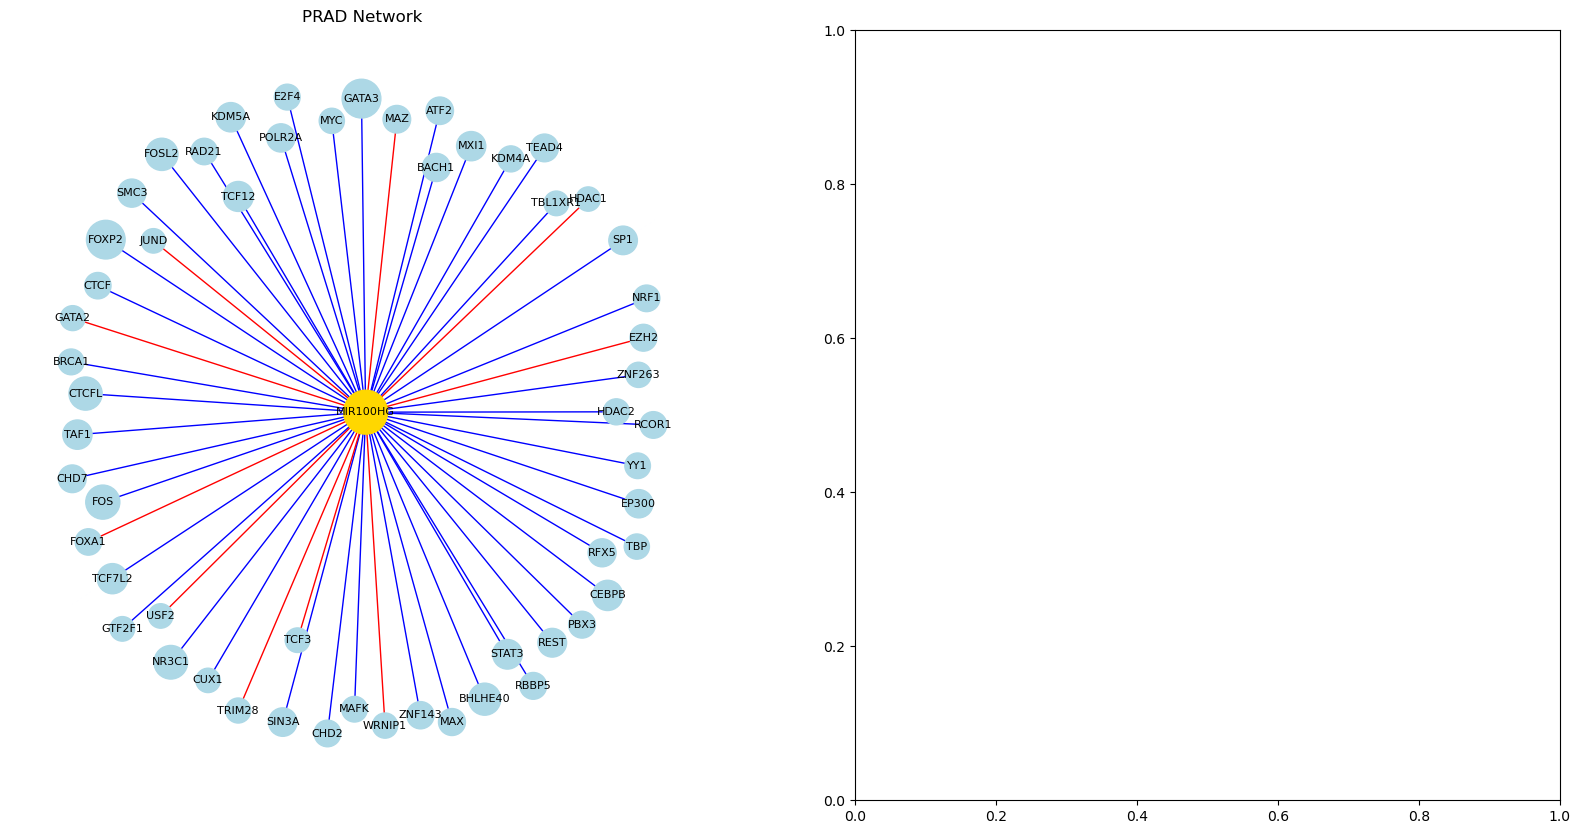

In [58]:
# miR100HG Network Visualizations 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')



hr("MIR100HG Network Visualizations")
NET_OUT = Path(PATHS["output_dir"])
NET_OUT.mkdir(parents=True, exist_ok=True)
print(f"[NET] CANCER_TYPE={CANCER_TYPE} | OUT_DIR={NET_OUT}")
plt.style.use('default')
sns.set_palette("husl")


required_vars = ['mir100hg_all_genes_signatures', 'mir100hg_all_genes_updown_regulation']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Missing: {missing}")
output_dir = Path(PATHS["output_dir"])


if isinstance(mir100hg_all_genes_signatures, pd.DataFrame):
    mir100hg_all_genes_signatures = {CANCER_TYPE: mir100hg_all_genes_signatures.copy()}


for key in mir100hg_all_genes_signatures:
    df = mir100hg_all_genes_signatures[key]
    if "gene_type" not in df.columns and "gene_category" in df.columns:
        df["gene_type"] = df["gene_category"].apply(lambda x:
            "TF_regulator" if "TF" in x else
            "miR100HG_host" if "miR100HG" in x else
            "Known_target" if "Known" in x else
            "potential_target"
        )
        mir100hg_all_genes_signatures[key] = df


df = mir100hg_all_genes_updown_regulation.copy()

if 'dataset' not in df.columns:
    df['dataset'] = CANCER_TYPE

if 'logFC' not in df.columns:
    for alt in ['logFC_cancer', 'logFC_normal']:
        if alt in df.columns:
            df['logFC'] = df[alt]
            break
    else:
        df['logFC'] = 0.0

if 'significant' not in df.columns:
    for alt in ['cancer_significant', 'normal_significant']:
        if alt in df.columns:
            df['significant'] = df[alt]
            break
    else:
        df['significant'] = False

if 'regulation' not in df.columns:
    df['regulation'] = df.apply(lambda row: (
        "Significantly_Up" if row['logFC'] > 0.5 and row['significant'] else
        "Significantly_Down" if row['logFC'] < -0.5 and row['significant'] else
        "Not_Significant"
    ), axis=1)

mir100hg_all_genes_updown_regulation = df

#  Network 
def create_network_graph(sig_dict, path):
    fig, axes = plt.subplots(1, len(sig_dict), figsize=(10 * len(sig_dict), 10))
    if len(sig_dict) == 1: axes = [axes]
    for idx, (name, df) in enumerate(sig_dict.items()):
        G, node_colors, node_sizes, edge_list, edge_colors = nx.DiGraph(), {}, {}, [], []
        tf_df = df[df['gene_type'] == 'TF_regulator']
        tgt_df = df[df['gene_type'] == 'potential_target']
        for _, row in tf_df.iterrows():
            gene = row['SYMBOL']
            val = row.get('logFC', row.get('logFC_cancer', 1))
            G.add_edge(gene, "MIR100HG")
            node_colors[gene] = 'lightblue'
            node_sizes[gene] = min(abs(val)*200 + 300, 800)
            edge_list.append((gene, "MIR100HG"))
            edge_colors.append("blue" if val > 0 else "red")
        if "regulation" in tgt_df.columns:
            tgt_df = tgt_df[tgt_df["regulation"].str.contains("Significantly", na=False)]
        if 'priority_score' in tgt_df.columns:
            tgt_df = tgt_df.nlargest(20, 'priority_score')
        for _, row in tgt_df.iterrows():
            gene = row['SYMBOL']
            val = row.get('logFC', row.get('logFC_cancer', 1))
            G.add_edge("MIR100HG", gene)
            node_colors[gene] = 'lightcoral' if val > 0 else 'lightgreen'
            node_sizes[gene] = min(abs(val)*200 + 300, 800)
            edge_list.append(("MIR100HG", gene))
            edge_colors.append("red" if val > 0 else "green")
        G.add_node("MIR100HG")
        node_colors["MIR100HG"] = "gold"
        node_sizes["MIR100HG"] = 1000
        if len(G.nodes) < 3:
            axes[idx].text(0.5, 0.5, f"No data\n{name}", ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].axis("off")
            continue
        pos = nx.spring_layout(G, k=2, iterations=50, seed=42); pos["MIR100HG"] = np.array([0,0])
        nx.draw_networkx_nodes(G, pos, node_color=[node_colors[n] for n in G], node_size=[node_sizes[n] for n in G], ax=axes[idx])
        nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color=edge_colors, ax=axes[idx])
        nx.draw_networkx_labels(G, pos, labels={n: n[:10] for n in G}, font_size=8, ax=axes[idx])
        axes[idx].set_title(f"{name} Network"); axes[idx].axis("off")
    legend = [
        plt.Line2D([0], [0], marker='o', color='w', label='TF', markerfacecolor='lightblue'),
        plt.Line2D([0], [0], marker='o', color='w', label='miR100HG', markerfacecolor='gold'),
        plt.Line2D([0], [0], marker='o', color='w', label='Target - up', markerfacecolor='lightcoral'),
        plt.Line2D([0], [0], marker='o', color='w', label='Target - down', markerfacecolor='lightgreen')
    ]
    fig.legend(handles=legend, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)
    plt.tight_layout(); plt.savefig(path, dpi=300); plt.show()

# Heatmap 
def create_regulation_heatmap(df, path):
    df = df[df['significant']]
    df['abs_logFC'] = df['logFC'].abs()
    top = df.nlargest(30, 'abs_logFC')
    pivot = top.pivot(index="SYMBOL", columns="dataset", values="logFC").fillna(0)
    plt.figure(figsize=(10, max(6, len(pivot)//2)))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
    plt.title("Top Regulated Genes")
    plt.tight_layout(); plt.savefig(path, dpi=300); plt.show()

#Signature Overview 
def create_signature_overview(sig_dict, path):
    fig, axes = plt.subplots(2, len(sig_dict), figsize=(6*len(sig_dict), 10))
    if len(sig_dict) == 1: axes = axes.reshape(2, 1)
    for idx, (name, df) in enumerate(sig_dict.items()):
        df['regulation'] = df.get('regulation', 'Other')
        tcount = df['gene_type'].value_counts()
        rcount = df['regulation'].value_counts()
        axes[0, idx].bar(tcount.index, tcount.values); axes[0, idx].set_title(f"{name}: Gene Types")
        axes[1, idx].bar(rcount.index, rcount.values); axes[1, idx].set_title(f"{name}: Regulation")
    plt.tight_layout(); plt.savefig(path, dpi=300); plt.show()

# logFC Comparison 
def create_logfc_comparison(df, path):
    pivot = df.pivot(index="SYMBOL", columns="dataset", values="logFC").fillna(0)
    if pivot.shape[1] < 2: return
    x, y = pivot.iloc[:, 0], pivot.iloc[:, 1]
    plt.figure(figsize=(8,6))
    plt.scatter(x, y, c='gray', alpha=0.5)
    plt.axhline(0, ls='--'); plt.axvline(0, ls='--'); plt.plot([-5,5], [-5,5], 'k--')
    plt.xlabel(x.name); plt.ylabel(y.name); plt.title("logFC Comparison")
    plt.tight_layout(); plt.savefig(path, dpi=300); plt.show()

# Pie Chart 
def create_regulation_patterns(df, path):
    datasets = df['dataset'].unique()
    fig, axes = plt.subplots(1, len(datasets), figsize=(6*len(datasets), 6))
    if len(datasets) == 1: axes = [axes]
    for i, d in enumerate(datasets):
        counts = df[df['dataset'] == d]['regulation'].value_counts()
        axes[i].pie(counts, labels=counts.index, autopct="%1.1f%%")
        axes[i].set_title(f"{d}: Regulation")
    plt.tight_layout(); plt.savefig(path, dpi=300); plt.show()


plot_files = {
    'network': output_dir / f"mir100hg_network_plot_{CANCER_TYPE.lower()}.png",
    'heatmap': output_dir / f"mir100hg_regulation_heatmap_{CANCER_TYPE.lower()}.png",
    'overview': output_dir / f"mir100hg_signature_overview_{CANCER_TYPE.lower()}.png", 
    'comparison': output_dir / f"mir100hg_logfc_comparison_{CANCER_TYPE.lower()}.png",
    'patterns': output_dir / f"mir100hg_regulation_patterns_{CANCER_TYPE.lower()}.png"
}

try:
    create_network_graph(mir100hg_all_genes_signatures, plot_files['network'])
    create_regulation_heatmap(mir100hg_all_genes_updown_regulation, plot_files['heatmap'])
    create_signature_overview(mir100hg_all_genes_signatures, plot_files['overview'])
    create_logfc_comparison(mir100hg_all_genes_updown_regulation, plot_files['comparison'])
    create_regulation_patterns(mir100hg_all_genes_updown_regulation, plot_files['patterns'])

    for k, v in plot_files.items():
        print(f"   {k}: {v.name}")
except Exception as e:
    import traceback
    print(f"\n Error: {e}")
    traceback.print_exc()


In [59]:

# MIR100HG Enrichment Analysis 


import pandas as pd
import numpy as np
import requests
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import fisher_exact


OUT_DIR = Path(PATHS["output_dir"])
OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"[ENR] CANCER_TYPE={CANCER_TYPE} | OUT_DIR={OUT_DIR}")

updown_fp = OUT_DIR / f"mir100hg_targets_updown_regulation_{CANCER_TYPE.lower()}.csv"
sig_cancer_fp = OUT_DIR / f"mir100hg_tf_target_signature_{CANCER_TYPE.lower()}.csv"
sig_normal_fp = OUT_DIR / f"mir100hg_tf_target_signature_normal_{CANCER_TYPE.lower()}.csv"

try:
    mir100hg_updown_regulation = pd.read_csv(updown_fp)
    sig_cancer = pd.read_csv(sig_cancer_fp)
    sig_normal = pd.read_csv(sig_normal_fp)
    mir100hg_signatures = {"cancer": sig_cancer, "normal": sig_normal}
    print(" Loaded all required enrichment input files")
except FileNotFoundError as e:
    print(" Required input file missing.", e)
    raise SystemExit("Aborting: upstream analysis missing.")


if 'significant' not in mir100hg_updown_regulation.columns:
    mir100hg_updown_regulation['significant'] = True
if 'direction' not in mir100hg_updown_regulation.columns:
    mir100hg_updown_regulation['direction'] = mir100hg_updown_regulation['logFC_cancer'].apply(
        lambda x: 'UP' if x > 0 else 'DOWN')
if 'mirna_relationship' not in mir100hg_updown_regulation.columns:
    mir100hg_updown_regulation['mirna_relationship'] = 'NA'


all_targets = mir100hg_updown_regulation[mir100hg_updown_regulation['significant']]['SYMBOL'].unique()
upregulated_targets = mir100hg_updown_regulation[
    (mir100hg_updown_regulation['direction'] == 'UP') & (mir100hg_updown_regulation['significant'])
]['SYMBOL'].unique()
downregulated_targets = mir100hg_updown_regulation[
    (mir100hg_updown_regulation['direction'] == 'DOWN') & (mir100hg_updown_regulation['significant'])
]['SYMBOL'].unique()
unexpected_targets = mir100hg_updown_regulation[
    (mir100hg_updown_regulation['mirna_relationship'].str.contains('Unexpected')) &
    (mir100hg_updown_regulation['significant'])
]['SYMBOL'].unique()

def infer_gene_type(row):
    cat = row.get('gene_category', '')
    if 'TF' in cat:
        return 'TF_regulator'
    elif 'MIR100HG' in cat:
        return 'miR100HG_host'
    elif 'Known' in cat:
        return 'Known_target'
    return 'Other'

for name in mir100hg_signatures:
    df = mir100hg_signatures[name]
    if 'gene_type' not in df.columns:
        df['gene_type'] = df.apply(infer_gene_type, axis=1)
    mir100hg_signatures[name] = df


tf_regulators_significant = []
for name, df in mir100hg_signatures.items():
    if 'gene_name' in df.columns and 'adj_pval' in df.columns:
        subset = df[(df['gene_type'] == 'TF_regulator') & (df['adj_pval'] < 0.001)]
        tf_regulators_significant.extend(subset['gene_name'].tolist())
tf_regulators_significant = list(set(tf_regulators_significant))


print(f"All targets: {len(all_targets)}")
print(f" Upregulated targets: {len(upregulated_targets)}")
print(f" Downregulated targets: {len(downregulated_targets)}")
print(f" Unexpected targets: {len(unexpected_targets)}")
print(f" TF regulators: {len(tf_regulators_significant)}")


mir100hg_enrichment_inputs = {
    "all_targets": all_targets,
    "upregulated_targets": upregulated_targets,
    "downregulated_targets": downregulated_targets,
    "unexpected_targets": unexpected_targets,
    "tf_regulators_significant": tf_regulators_significant,
    "mir100hg_signatures": mir100hg_signatures
}

print(" Enrichment inputs prepared successfully")




def enrichr_analysis(gene_list, gene_set_libraries, description=""):
    if len(gene_list) == 0:
        print(f"No genes provided for {description}")
        return pd.DataFrame()
    print(f"Running Enrichr analysis for {description} ({len(gene_list)} genes)")

    genes_str = '\n'.join(gene_list)
    payload = {'list': genes_str, 'description': description}
    try:
        response = requests.post('https://maayanlab.cloud/Enrichr/addList', files=payload)
        if response.status_code != 200:
            print(f"Error submitting gene list: {response.status_code}")
            return pd.DataFrame()

        user_list_id = json.loads(response.text)['userListId']
        time.sleep(1)

        all_results = []
        for library in gene_set_libraries:
            enrichr_url = f'https://maayanlab.cloud/Enrichr/enrich?userListId={user_list_id}&backgroundType={library}'
            try:
                response = requests.get(enrichr_url)
                if response.status_code == 200:
                    data = json.loads(response.text)
                    if library in data and len(data[library]) > 0:
                        for result in data[library][:20]:
                            all_results.append({
                                'library': library,
                                'term': result[1],
                                'p_value': result[2],
                                'adj_p_value': result[6],
                                'genes': result[5],
                                'overlap_ratio': f"{len(result[5])}/{result[3]}",
                                'gene_count': len(result[5]),
                                'description': description,
                                'cancer_type': CANCER_TYPE
                            })
                time.sleep(0.5)
            except Exception as e:
                print(f"Error getting results for {library}: {e}")
                continue
        return pd.DataFrame(all_results)
    except Exception as e:
        print(f"Error in Enrichr analysis: {e}")
        return pd.DataFrame()

from scipy.stats import fisher_exact

def manual_kegg_analysis(gene_list, description=""):
    print(f"Running manual KEGG analysis for {description}...")
    kegg_pathways = {
        'Cell Cycle': ['TP53', 'MYC', 'CDC25A', 'CDK6', 'CCND2', 'E2F2', 'PCNA'],
        'Apoptosis': ['TP53', 'BCL2', 'MCL1', 'BMF', 'PUMA', 'MYC'],
        'Cancer Pathways': ['TP53', 'MYC', 'BCL2', 'FGFR3', 'STAT3', 'ETS1', 'KRAS'],
        'mTOR Signaling': ['MTOR', 'IGF1R', 'IGF2BP1', 'IGF2BP3'],
        'Transcriptional Regulation': ['MYC', 'TP53', 'ETS1', 'IRF4', 'PRDM1', 'ARID3A'],
        'RNA Processing': ['DICER1', 'AGO2', 'ARGONAUTE2', 'LIN28', 'LIN28A'],
        'Growth Factor Signaling': ['IGF1R', 'FGFR3', 'HMGA2'],
        'Chromatin Regulation': ['SMARCA5', 'ARID3A', 'KLF13'],
        'Immune Response': ['STAT3', 'IRF4', 'PRDM1', 'ETS1']
    }
    results = []
    total_genes = 20000
    for pathway_name, pathway_genes in kegg_pathways.items():
        overlap = set(gene_list).intersection(set(pathway_genes))
        if len(overlap) > 0:
            a = len(overlap)
            b = len(pathway_genes) - a
            c = len(gene_list) - a
            d = total_genes - len(pathway_genes) - len(gene_list) + a
            try:
                odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='greater')
            except:
                p_value, odds_ratio = 1.0, 1.0
            results.append({
                'pathway': pathway_name,
                'overlap_genes': list(overlap),
                'overlap_count': a,
                'pathway_size': len(pathway_genes),
                'p_value': p_value,
                'odds_ratio': odds_ratio,
                'gene_ratio': f"{a}/{len(gene_list)}",
                'description': description,
                'cancer_type': CANCER_TYPE
            })
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df['adj_p_value'] = results_df['p_value'] * len(results_df) / (results_df['p_value'].rank())
        results_df = results_df.sort_values('p_value')
    return results_df



def create_enrichment_plot(enrichment_df, title="Enrichment Analysis", top_n=10, save_path=None):
    if enrichment_df.empty:
        print(f"No data to plot for {title}")
        return
    sig_results = enrichment_df[enrichment_df['adj_p_value'] < 0.05].copy()
    if sig_results.empty:
        print(f"No significant results for {title}")
        return


    plot_data = []
    for library in sig_results['library'].unique():
        lib_data = sig_results[sig_results['library'] == library].nsmallest(top_n, 'adj_p_value')
        plot_data.append(lib_data)

    if not plot_data:
        print(f"No data to plot from any libraries in {title}")
        return

    plot_df = pd.concat(plot_data).reset_index(drop=True)
    plot_df['-log10_pval'] = -np.log10(plot_df['adj_p_value'])


    fig, ax = plt.subplots(figsize=(12, max(8, len(plot_df) * 0.4)))
    y_pos = np.arange(len(plot_df))

 
    colors = plt.cm.viridis(plot_df['gene_count'] / plot_df['gene_count'].max())

    ax.barh(y_pos, plot_df['-log10_pval'], color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([
        f"{row['term'][:60]}..." if len(row['term']) > 60 else row['term']
        for _, row in plot_df.iterrows()
    ], fontsize=8)
    ax.set_xlabel('-log10(Adjusted P-value)', fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')


    for i, (_, row) in enumerate(plot_df.iterrows()):
        ax.text(row['-log10_pval'] + 0.1, i, f"[{row['library']}]", va='center', fontsize=7, alpha=0.7)

    ax.axvline(x=-np.log10(0.05), color='red', linestyle='--', alpha=0.5, label='p=0.05')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f" Saved plot to {save_path}")
    plt.show()

    return plot_df



[ENR] CANCER_TYPE=PRAD | OUT_DIR=/Users/dyuth/Desktop/Data Science Project/Data/mir100hg_analysis_prad
 Loaded all required enrichment input files
All targets: 16791
 Upregulated targets: 12830
 Downregulated targets: 3961
 Unexpected targets: 0
 TF regulators: 0
 Enrichment inputs prepared successfully


In [60]:

# RUN ENRICHMENT ANALYSIS

print("Running")


enrichr_libraries = [
    'GO_Biological_Process_2023',
    'GO_Molecular_Function_2023',
    'Reactome_2022',
    'WikiPathways_2023_Human'
]


gene_sets = {
    'All targets': all_targets,
    'Upregulated targets': upregulated_targets,
    'Downregulated targets': downregulated_targets,
    'Unexpected targets': unexpected_targets,
    'TF regulators': tf_regulators_significant
}


all_enrichr_results = []
for label, gene_list in gene_sets.items():
    if len(gene_list) == 0:
        print(f"Skipping {label} (no genes)")
        continue
    result = enrichr_analysis(
        gene_list.tolist() if hasattr(gene_list, 'tolist') else gene_list,
        enrichr_libraries,
        description=f"{CANCER_TYPE} - {label}"
    )
    if not result.empty:
        all_enrichr_results.append(result)


if all_enrichr_results:
    combined_enrichr = pd.concat(all_enrichr_results, ignore_index=True)
    enrichr_file = OUT_DIR / f"enrichr_results_detailed_{CANCER_TYPE}.csv"
    combined_enrichr.to_csv(enrichr_file, index=False)
    print(f" Saved Enrichr results to: {enrichr_file}")
else:
    print("No Enrichr results obtained")
    combined_enrichr = pd.DataFrame()


# Manual KEGG anlaysis

manual_results = []
for label, gene_list in gene_sets.items():
    if len(gene_list) > 0:
        result = manual_kegg_analysis(
            gene_list.tolist() if hasattr(gene_list, 'tolist') else gene_list,
            description=f"{CANCER_TYPE} - {label}"
        )
        if not result.empty:
            manual_results.append(result)

if manual_results:
    combined_manual = pd.concat(manual_results, ignore_index=True)
    manual_file = OUT_DIR / f"manual_kegg_results_{CANCER_TYPE}.csv"
    combined_manual.to_csv(manual_file, index=False)
    print(f" Saved manual KEGG results to: {manual_file}")
else:
    combined_manual = pd.DataFrame()
    print(" No manual KEGG results found")


print("\n Creating enrichment plots...")


if not combined_enrichr.empty:
    for desc in combined_enrichr['description'].unique():
        subset = combined_enrichr[combined_enrichr['description'] == desc]
        if not subset.empty:
            plot_path = OUT_DIR / f"enrichment_{desc.replace(' ', '_').lower()}_{CANCER_TYPE}.png"
            create_enrichment_plot(subset, f"Enrichr Analysis: {desc}", save_path=plot_path)


if not combined_manual.empty:
    for desc in combined_manual['description'].unique():
        subset = combined_manual[combined_manual['description'] == desc]
        sig_subset = subset[subset['adj_p_value'] < 0.1].nsmallest(10, 'adj_p_value')
        if not sig_subset.empty:
            plt.figure(figsize=(12, max(6, len(sig_subset) * 0.4)))
            y_pos = np.arange(len(sig_subset))
            log_pvals = -np.log10(sig_subset['adj_p_value'])
            plt.barh(y_pos, log_pvals,
                     color=plt.cm.plasma(sig_subset['overlap_count'] / sig_subset['overlap_count'].max()))
            plt.yticks(y_pos, sig_subset['pathway'], fontsize=10)
            plt.xlabel('-log10(Adjusted P-value)', fontsize=12)
            plt.title(f'KEGG Pathway Analysis: {desc}', fontsize=14, fontweight='bold')
            for i, (_, row) in enumerate(sig_subset.iterrows()):
                plt.text(log_pvals.iloc[i] + 0.1, i, f"({row['overlap_count']})", va='center', fontsize=8)
            plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
            plt.tight_layout()
            save_path = OUT_DIR / f"kegg_{desc.replace(' ', '_').lower()}_{CANCER_TYPE}.png"
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()
            print(f"✓ Created {save_path.name}")


print("\n Enrichment analysis complete.")
print(f"Combined Enrichr results: {len(combined_enrichr)} terms")
print(f"Combined manual KEGG results: {len(combined_manual)} pathways")




Running
Running Enrichr analysis for PRAD - All targets (16791 genes)
Error in Enrichr analysis: HTTPSConnectionPool(host='maayanlab.cloud', port=443): Max retries exceeded with url: /Enrichr/addList (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x32011fbd0>: Failed to resolve 'maayanlab.cloud' ([Errno 8] nodename nor servname provided, or not known)"))
Running Enrichr analysis for PRAD - Upregulated targets (12830 genes)
Error in Enrichr analysis: HTTPSConnectionPool(host='maayanlab.cloud', port=443): Max retries exceeded with url: /Enrichr/addList (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x32011de50>: Failed to resolve 'maayanlab.cloud' ([Errno 8] nodename nor servname provided, or not known)"))
Running Enrichr analysis for PRAD - Downregulated targets (3961 genes)
Error in Enrichr analysis: HTTPSConnectionPool(host='maayanlab.cloud', port=443): Max retries exceeded with url: /Enrichr/addList (Caused by NameResoluti